# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import json
import datetime
from datetime import datetime
from functools import reduce
import re
import matplotlib.pyplot as plt

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# Download this file manually
# Upload it and read the data into a pandas DataFrame

In [3]:
# Directly download the WeRateDogs Twitter archive data
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# check if the file was correctly imported
twitter_archive_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

Sources:<br>
[Downloading Files in Python using the Requests Library - p.1](https://www.google.com/search?q=Downloading+TSV+files+with+the+Requests+librarye+using+code&sxsrf=APwXEddLOZjMm3DatLBoLnJvw8kpW66mVQ%3A1681418601763&ei=aWk4ZO6RLujb1sQPlt2Z-AU&ved=0ahUKEwiu6uez3Kf-AhXorZUCHZZuBl8Q4dUDCA8&uact=5&oq=Downloading+TSV+files+with+the+Requests+librarye+using+code&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQA0oECEEYAFAAWABgAGgAcAF4AIABAIgBAJIBAJgBAKABAqABAQ&sclient=gws-wiz-serp#fpstate=ive&vld=cid:45301d3c,vid:novaWCMg4Vk)<br>
[geeksforgeeks.org - Simple Ways to Read TSV Files in Python](https://www.geeksforgeeks.org/simple-ways-to-read-tsv-files-in-python/)<br>
[packtpub.com - Reading and writing CSV/TSV files with Python](https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781783551668/1/ch01lvl1sec10/reading-and-writing-csv-tsv-files-with-python)<br>
[stackoverflow.com - Generate and download tsv from a website (with python)](https://stackoverflow.com/questions/64336524/generate-and-download-tsv-from-a-website-with-python)

In [5]:
# To get this data we will need to do web scraping, 
# which allows us to extract data from websites using code
# Downloading TSV file programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
filename = url.split('/')[-1]
# Save to file
with open(filename, mode='wb') as file:
    file.write(response.content)

In [6]:
image_predictions = pd.read_csv(filename,sep='\t')

In [7]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [8]:
consumer_key = '' # V2 Client ID
consumer_secret = '' # V2 Client Secret
access_token = ''
access_secret = ''

In [9]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [10]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [11]:
tweet_id = '892420643555336193'

Before running the loop, I used the code above to test only one `tweet_id.` In all the tests I made, I received a message that I needed more attribution level to read correctly. 
<br><br>When I regenerated the keys and tokens in the last attempt, I received the message "Could not authenticate you." So after these many unsuccessful attempts, I gave up fetching this data. 
<br><br>Below, we can observe the codes and references used in these attempts.

In [12]:
# tweet = api.get_status(tweet_id, tweet_mode='extended')
'''
---------------------------------------------------------------------------
TweepError                                Traceback (most recent call last)
<ipython-input-13-a3b7a167cf84> in <module>()
----> 1 tweet = api.get_status(tweet_id, tweet_mode='extended')

/opt/conda/lib/python3.6/site-packages/tweepy/binder.py in _call(*args, **kwargs)
    243             return method
    244         else:
--> 245             return method.execute()
    246 
    247     # Set pagination mode

/opt/conda/lib/python3.6/site-packages/tweepy/binder.py in execute(self)
    227                     raise RateLimitError(error_msg, resp)
    228                 else:
--> 229                     raise TweepError(error_msg, resp, api_code=api_error_code)
    230 
    231             # Parse the response payload

TweepError: [{'code': 32, 'message': 'Could not authenticate you.'}]
''';
# print(json.dumps(tweet._json))

I had doubts about how to get tweet_id.
<br>I found the solution in [jemc36/Udacity-DAND-DataWrangling-TwitterAPI-WeRateDogs](https://github.com/jemc36/Udacity-DAND-DataWrangling-TwitterAPI-WeRateDogs/blob/master/wrangle_act.ipynb)

In [13]:
tweet_ids = twitter_archive_enhanced.tweet_id.values

I also searched these sources to complete the code below.
<br>[UDACITY - FAQ - Next step after reading twitter id](https://knowledge.udacity.com/questions/280182)

In [14]:
len(tweet_ids)

2356

In [15]:
'''
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
''';

[jemc36/Udacity-DAND-DataWrangling-TwitterAPI-WeRateDogs](https://github.com/jemc36/Udacity-DAND-DataWrangling-TwitterAPI-WeRateDogs/blob/master/wrangle_act.ipynb)
<br>[kHarshit/udacity-nanodegree-projects](https://github.com/kHarshit/udacity-nanodegree-projects/blob/master/DAND_data_analyst_nanodegree/p4_wrangle_and_analyze_data/wrangle_act.ipynb)
<br>[Anderson Uyekita - 3.5 Project 02 - Wrangle and Analyze Data](https://andersonuyekita.github.io/ND111_data_science_foundations_02/project-02-wrangle-and-analyze-data.html)
<br>[AndersonUyekita/ND111_data_science_foundations_02](https://github.com/AndersonUyekita/ND111_data_science_foundations_02/blob/master/03-Chapter03/00-Project_02/wrangle_act.ipynb)
<br>[Project: Wrangle and Analyze Data - FAQ](https://sites.google.com/udacity.com/dataanalyst-project4/home)

In [16]:
# import time
'''
# Initializing the dicitionary to store the raw data from Twitter API JSON file.
dct_twt_raw = {}

# This is the list of error.
df_error = []

# Current time when the Twitter API starts.
str_loop = time.time()

# Loop to find each tweet_id of u_twt_id list.
for tweet in tweet_ids:
    # This is necessary to avoid an interruption if any tweet_id is not find.
    try:
        # The get_status will find a specific tweet_id and return all the tweet.
        twt_status = api.get_status(tweet,
                                    wait_on_rate_limit = True,         # Automatically wait for rate limits to replenish.
                                    wait_on_rate_limit_notify = True,  # Print the notification "Rate limit reached..."
                                    tweet_mode = 'extended')           # I want the full text without "...".
        # The data I want is the _json dictionary.
        dct_twt_raw[str(tweet)] = twt_status._json                     # Bear in mind, _json is a dictionary.
    # In case of a problem, a message will be printed.
    except:
        df_error.append(str(tweet))                                    # Update df_error list.
        print("tweet_id did not found: {}".format(str(tweet)))

# Current time when the Twitter API ends.
end_loop = time.time()
''';

[AndersonUyekita/ND111_data_science_foundations_02](https://github.com/AndersonUyekita/ND111_data_science_foundations_02/blob/master/03-Chapter03/00-Project_02/wrangle_act.ipynb)

In [17]:
'''
# Calculating the elapsed time in minutes.
elapsed_time = (end_loop - str_loop)/60

# Printing the elapsed time of the loop.
print("Elapsed time: {} minutes".format(round(elapsed_time,2)))
''';

As we can see above, I tried many times with many tests, and after unsuccessful attempts, I read the data directly using `tweet_json.txt`.

In [18]:
'''
# To get this data we will need to do web scraping, 
# which allows us to extract data from websites using code
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(url)
filename = url.split('/')[-1]
# Save to file
with open(filename, mode='wb') as file:
    file.write(response.content)
''';

In [19]:
# image_predictions = pd.read_csv(filename,sep='\t')
# dct_twt_raw = pd.DataFrame()
# import json
# Writing the tweet_json.txt in the 01-Dataset folder.
'''
with open('tweet_json.txt', mode = 'w') as file:
    json.dump(dct_twt_raw, file)
''';

In [20]:
# Loading the tweet_json.txt as a panda DataFrame.
# df_twt_raw = pd.read_json('tweet_json.txt', orient = 'index')
# Atention to the orient defined as index.
# Printing the first rows.
# df_twt_raw.head()

In [21]:
df3 = pd.DataFrame(columns = ['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet-json.txt') as f:
    for line in f:
        status = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        df3 = df3.append(pd.DataFrame([[tweet_id,retweet_count,favorite_count]], columns = ['tweet_id', \
                                                                                              'retweet_count', 'favorite_count']))
df3 = df3.reset_index(drop = True)
df3.head(10)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [22]:
'''
df_3 = pd.DataFrame(columns = ['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt') as f:
    for line in f:
        try:
            status = json.loads(line)
            tweet_id = status['id_str']
            retwwet_count = status['retweet_count']
            favorite_count = status['favorite_count']
        except:
            print(status['id_str'])
            print('Erro!\n')
            tweet_id = 'error'
            retwwet_count = 'error'
            favorite_count = 'error'
        df_3 = df_3.append(pd.DataFrame([[tweet_id,retweet_count,favorite_count]], columns = ['tweet_id', \
                                                                                              'retweet_count', 'favorite_count']))
df_3 = df_3.reset_index(drop = True)
df_3
''';

## Assessing Data

In this section, I detected and documented at least **eight (8) quality issues and two (2) tidiness issues**. I used **both** visual and programmatic assessments to assess the data.

It was recommended pay attention to the following key points:
<i>
* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings, and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least eight quality issues and at least two tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.
<i/>

Source: Udacity

#### Review of concepts
<br><i>
Assessing your data is the second step in the data-wrangling process. When assessing, you're inspecting your data set for two things:
<br>•	Data quality issues (i.e., content issues): Data with quality issues have content issues like missing, duplicate, or incorrect data. This is called dirty data.
<br>•	Lack of tidiness (i.e., structural issues): Data that has specific structural issues that slow you down when cleaning and analyzing, visualizing, or modeling your data later.
<br><br>You can search for these issues in two ways:
<br>•	Visually by scrolling
<br>•	Programmatically using code
<br>
When you detect an issue, document it to make cleaning easier.
<br><br>Unclean Data: Dirty vs. Messy
<br>There are two types of unclean data:
<br>•	Dirty data, also known as low-quality data. Low-quality data has content issues.
<br>•	Messy data, also known as untidy data. Untidy data has structural issues.

Regardless of the type of assessment you're using, assessing data can be broken down into two steps;
<br>•	detecting an issue
<br>•	documenting that issue

<br>This process applies whether you assess your data visually or programmatically. When documenting an issue, you don't have to specify how to fix it, which is part of the cleaning step in this data-wrangling framework.
</i>

Source: Udacity

### Assessing  `twitter_archive_enhanced`

I created df1, df2, and df3 to deal with the dataset easily instead of using the full names.

#### Additional review

<br><i>
Types of Assessment. There are two types or styles of assessing your data: visual and programmatic.

•	Visual assessment is just opening it and looking through the data in its entirety, in pandas, a text editor or a spreadsheet application for example.

•	Programmatic assessment, like its name suggests, uses code to view specific parts of the data, like using functions or methods to summarize the data. Like the .info method for example. You can even plot the data, but plotting isn't done very often when wrangling. This is more for exploratory data analysis, which we'll get into later.
Steps to Assessing Data

<br>Programmatic assessment using functions and methods to reveal something about your data's quality and tidiness. For example, in pandas, we can call the .info method to print a concise summary of a DataFrame.

These are the programmatic assessment methods in pandas that you will probably use most often:

•	in DataFrame and Series - `.head`, `.tail`, `.sample`, and `.describe` (Statistics);

•	DataFrame only - `.info`;

•	Series only - `.value_counts`;

•	methods of indexing and selecting data - `.loc` and `.iloc`.

•	`.sort_values()`

•	`.isnull` , `sum` of .isnull;

•	`.duplicated()` , `isduplicated()`
</i>
Source: Udacity

### Visual assessment

Initially, I accessed the CSV file using Notepad++After it, I imported the data to Excel and executed some transformations.

<img src="Images/XLS01.jpg">

After it I imported the data to Excel, and executed some transformations.

<img src="Images/XLS02.jpg">

In the "timestamp" column, we can observe that no elements exist before August 1st, 2017.

<img src="Images/XLS03.jpg">

I checked if the values in the "text" column were the same in columns "reting_numerators" and "rating_denominators".

<img src="Images/XLS05.jpg">

There are many inconsistent values in the "rating_numerator" columns.

<img src="Images/XLS06_numerator.jpg">

rating_denominator

<img src="Images/XLS07_denominator.jpg">

<img src="Images/XLS08_denominator.jpg">

Tidiness issues

<img src="Images/XLS09.jpg">

2356 rows

<img src="Images/XLS10.jpg">

### Programmatic assessment

To avoid writing "twitter_archive_enhanced" many times, I preferred to create "df1."

In [23]:
df1 = twitter_archive_enhanced.copy()
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [24]:
# Reference: Search05
df1.head().T

,0,1,2,3,4
tweet_id,892420643555336193,892177421306343426,891815181378084864,891689557279858688,891327558926688256
in_reply_to_status_id,NaN,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56 +0000,2017-08-01 00:17:27 +0000,2017-07-31 00:18:03 +0000,2017-07-30 15:58:51 +0000,2017-07-29 16:00:24 +0000
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r...","<a href=""http://twitter.com/download/iphone"" r..."
text,This is Phineas. He's a mystical boy. Only eve...,This is Tilly. She's just checking pup on you....,This is Archie. He is a rare Norwegian Pouncin...,This is Darla. She commenced a snooze mid meal...,This is Franklin. He would like you to stop ca...
retweeted_status_id,NaN,NaN,NaN,NaN,NaN
retweeted_status_user_id,NaN,NaN,NaN,NaN,NaN
retweeted_status_timestamp,NaN,NaN,NaN,NaN,NaN
expanded_urls,https://twitter.com/dog_rates/status/892420643...,https://twitter.com/dog_rates/status/892177421...,https://twitter.com/dog_rates/status/891815181...,https://twitter.com/dog_rates/status/891689557...,https://twitter.com/dog_rates/status/891327558...


In [25]:
df1.shape

(2356, 17)

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [27]:
df1.text.sample(10).values

array([ "RT @dog_rates: This is Loki. He smiles like Elvis. Ain't nothin but a hound doggo. 12/10 https://t.co/QV5nx6otZR",
       'Rare submerged pup here. Holds breath for a long time. Frowning because that spoon ignores him. 5/10 would still pet https://t.co/EJzzNHE8bE',
       'Honor to rate this dog. Lots of fur on him. Two massive tumors on back. Should get checked out. Very neat tho. 7/10 https://t.co/bMhs18elNF',
       '@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs',
       'RT @KennyFromDaBlok: 14/10 h*ckin good hats. will wear daily @dog_rates https://t.co/rHLoU5gS30',
       "Meet Colby. He's that one cool friend that gets you into every party. Great hat. Sneaky tongue slip. 10/10 good pup https://t.co/jBnz3MjTzX",
       "This is Bubba. He's a Titted Peebles Aorta. Evolutionary masterpiece. Comfortable with his body. 8/10 great pupper https://t.co/aNkkl5nH3W",
       "This is Dot. He found out you only pretended to throw the ball that one time. You don't fuc

In [28]:
df1.retweeted_status_id.value_counts()

7.757333e+17    1
7.507196e+17    1
6.742918e+17    1
6.833919e+17    1
8.269587e+17    1
8.780576e+17    1
7.320056e+17    1
7.186315e+17    1
6.732953e+17    1
7.914070e+17    1
8.447048e+17    1
7.862340e+17    1
8.685523e+17    1
7.504293e+17    1
8.327664e+17    1
6.690004e+17    1
6.873173e+17    1
7.638376e+17    1
7.815247e+17    1
8.092201e+17    1
8.000650e+17    1
8.174239e+17    1
8.001414e+17    1
7.909461e+17    1
7.867091e+17    1
8.406323e+17    1
8.688804e+17    1
7.869631e+17    1
7.733088e+17    1
8.222448e+17    1
               ..
6.816941e+17    1
7.899865e+17    1
7.939622e+17    1
6.800555e+17    1
7.128090e+17    1
8.164506e+17    1
6.769365e+17    1
6.675487e+17    1
8.083449e+17    1
7.626999e+17    1
6.678667e+17    1
8.479710e+17    1
6.820881e+17    1
8.352641e+17    1
7.761133e+17    1
7.902771e+17    1
6.675484e+17    1
7.677549e+17    1
8.782815e+17    1
8.663350e+17    1
7.399792e+17    1
7.403732e+17    1
8.395493e+17    1
7.001438e+17    1
8.482894e+

I do not need to gather the tweets beyond August 1st, 2017.

In [29]:
df1.timestamp.head()

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object

I checked, and there are no tweets after this date.

In [30]:
df1.query('timestamp >= "2017-08-02"').timestamp.count()

0

In [31]:
df1.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
605        1
1446       1
1869       1
2091       1
2038       1
1940       1
1764       2
2310       2
1761       2
1920       2
2246       2
2237       2
2349       2
2326       2
2079       2
2305       3
1249       3
1898       3
1478       3
1692       3
2202       3
765        3
1928       3
1314       3
2183       3
        ... 
866       14
83        14
291       15
285       15
55        17
1663      20
516       24
1712      26
763       27
1433      44
1274      45
1202      50
1351      60
340       75
695       75
1254      80
433       84
1843      88
1228      99
1635     121
1634     143
1779     144
902      165
290      182
1120     204
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [32]:
df1.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [33]:
df1.rating_numerator.values

array([13, 13, 12, ...,  9,  7,  8])

In [34]:
df1.rating_numerator.count

<bound method Series.count of 0       13
1       13
2       12
3       13
4       12
5       13
6       13
7       13
8       13
9       14
10      13
11      13
12      13
13      12
14      13
15      13
16      12
17      13
18      13
19      13
20      12
21      13
22      14
23      13
24      13
25      12
26      13
27      13
28      13
29      12
        ..
2326     2
2327     7
2328     9
2329    11
2330     6
2331     8
2332    10
2333     9
2334     3
2335     1
2336    11
2337    10
2338     1
2339    11
2340     8
2341     9
2342     6
2343    10
2344     9
2345    10
2346     8
2347     9
2348    10
2349     2
2350    10
2351     5
2352     6
2353     9
2354     7
2355     8
Name: rating_numerator, Length: 2356, dtype: int64>

In [35]:
df1.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
1574     10
1573     10
1572     10
1563     10
1570     10
1569     10
1568     10
1567     10
1566     10
1565     10
1564     10
1577     10
1571     10
0        10
1562     10
1547     10
1548     10
1549     10
1550     10
1551     10
1552     10
1553     10
1554     10
1555     10
1556     10
       ... 
782      10
781      10
775      10
799      10
780      10
779      10
776      10
777      10
778      10
800      10
784      11
1068     11
1662     11
342      15
1663     16
1165     20
1598     20
1433     40
1202     50
1351     50
1274     50
433      70
1843     80
1254     80
1228     90
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [36]:
df1.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### Assessing  `image_predictions`

In [37]:
df2 = image_predictions.copy()
df2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [38]:
df2.shape

(2075, 12)

In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


I checked for duplicate rows.

In [40]:
sum(df2['tweet_id'].duplicated())

0

In [41]:
# duplicates
sum(df2['jpg_url'].duplicated())

66

In [42]:
df2.jpg_url.value_counts()

https://pbs.twimg.com/media/Ct2qO5PXEAE6eB0.jpg                                            2
https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg                                            2
https://pbs.twimg.com/media/CpmyNumW8AAAJGj.jpg                                            2
https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg                                            2
https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg                                            2
https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg                                            2
https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg                                            2
https://pbs.twimg.com/media/CsGnz64WYAEIDHJ.jpg                                            2
https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg                                            2
https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg                                            2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                       

In [43]:
df2.query('jpg_url == "https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1472,779834332596887552,https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg,1,golden_retriever,0.99383,True,cocker_spaniel,0.003143,True,Great_Pyrenees,0.000917,True
1510,786036967502913536,https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg,1,golden_retriever,0.99383,True,cocker_spaniel,0.003143,True,Great_Pyrenees,0.000917,True


In [44]:
df1.query('tweet_id == "779834332596887552"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
747,779834332596887552,NaN,NaN,2016-09-25 00:06:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He really wants to kiss himself...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/779834332...,11,10,Scout,None,None,None,None


In [45]:
df1.query('tweet_id == "786036967502913536"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
702,786036967502913536,NaN,NaN,2016-10-12 02:53:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Scout. He really wants ...,7.798343e+17,4.196984e+09,2016-09-25 00:06:08 +0000,https://twitter.com/dog_rates/status/779834332...,11,10,Scout,None,None,None,None


I realized that the duplicate rows were because of retweets.

### Assessing  data from `tweet-json.txt`

In [46]:
df3.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [47]:
df3.shape

(2354, 3)

In [48]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.2+ KB


### Quality and Tidiness issues

<br>* Quality 01 - In `df1` remove retweets less they may skew the analysis.

<br>* Quality 02 - Convert `df1.tweet_id` from integer to string.

<br>* Quality 03 - Convert `df1.timestamp` from string to date.

<br>* Quality 04 - Split `df1.tex` in text and text_url columns.

<br>* Quality 05 - Check inconsistencies in denominators and transform to float.

<br>* Quality 06 - Check inconsistencies in numerators.

<br>* Tidiness 01 - Merge `df1`, `df2`, and `df3` to create a new data frame, `dfs`. It will also eliminate unreal dog images because of `df2`.

<br>* Quality 07 - In `df2.tweet_id` convert the column from integer to string.

<br>* Tidiness 02 - Create `dfs.dog_stage` joining the columns `doggo`, `floofer`, `pupper`, and `puppo`.

<br>* Tidiness 03 (Extra) - Join the greater probabilities and the respective breeds in only two columns.

<br>* Quality 08 - Remove rows where `dfs.confidence` == 0.0.

<br>* Quality 09 (Extra): Fix dog names.

<br>* Quality 10 (Extra): Transform `dfs.in_reply_to_status_id` to string.

<br>* Quality 11 (Extra): Transform `dfs.in_reply_to_user_id` to string.

<br>* Quality 12 (Extra): Create `dfs.rating`.

## Cleaning Data

As suggested in this section, I cleaned **all** of the issues I documented while assessing. 

Making a copy of the original data before cleaning was also recommended. I made a copy in "Assessment."

In this section I made the tasks in three steps: 
<i>
1.	Define - define how you will clean the issue in words
2.	Code - convert your definitions into executable code
3.	Test - test your data to ensure your code was implemented correctly
<i/>

In [49]:
# Make copies of original pieces of data.
# Instead of using "twitter_archive_enhancedand" and "image_predictions" many times 
# I decided to copy and creating df1, df2 and df3 before in assessment

### Quality #1: Remove retweets

#### Define

I have to consider only original tweets (no retweets), so I keep only the rows where the retweeted_status_id is null.

Reference: Search02

Code before changes

In [50]:
df1.shape

(2356, 17)

In [51]:
df1.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

#### Code

In [52]:
# consider only orignal tweets (no retweets)
df1 = df1[df1['retweeted_status_id'].isnull()]

In [53]:
# remove retweet related columns
df1 = df1.drop(['retweeted_status_id', 
                        'retweeted_status_user_id', 
                        'retweeted_status_timestamp'], 
                       axis=1)

#### Test

In [54]:
df1.shape

(2175, 14)

In [55]:
df1.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Quality #2:  Convert `df1.tweet_id` column from integer to string

#### Define

Transform `df1.tweet_id` from integer to string.

In [56]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ KB


In [57]:
df1['tweet_id'].dtype

dtype('int64')

#### Code

In [58]:
# fix 'tweet_id' to str/object
df1['tweet_id'] = df1['tweet_id'].astype(str)

#### Test

In [59]:
df1.tweet_id.dtype

dtype('O')

In [60]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 254.9+ KB


### Quality #3:  Convert timestamp column to date

#### Define

Transform `df1.timestamp` from string to date.

In [61]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 254.9+ KB


In [62]:
df1.timestamp.dtype

dtype('O')

#### Code

In [63]:
# change the 'timestamp' column to a datetime object
# df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1.timestamp = pd.to_datetime(df1.timestamp)

#### Test

In [64]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 254.9+ KB


### Quality #4: Split `df1.tex` in `text` and `text_url` columns

#### Define

Split `df1.text` in two columns to analyse the text more easly and to access the urls easly.

In [65]:
df1.text.sample(5).values

array([ "Scary dog here. Too many legs. Extra tail. Not soft, let alone fluffy. Won't bark. Moves sideways. Has weapon. 2/10 https://t.co/XOPXCSXiUT",
       "This is Derek. All the dogs adore Derek. He's a great guy. 10/10 really solid pup https://t.co/KgcsGNb61s",
       "This is Boots. She doesn't know what to do with treats so she just holds them. Very good girl. 12/10 would give more treats https://t.co/eAA8lratd3",
       'SHE DID AN ICY ZOOM AND KNEW WHEN TO PUT ON THE BRAKES 13/10 CANCEL THE GAME THIS IS ALL WE NEED https://t.co/4ctgpGcqAd',
       'Strange pup here. Easily manipulated. Rather inbred. Sharp for a dog. Appears uncomfortable. 8/10 would still pet https://t.co/nSQrhwbk1V'], dtype=object)

#### Code

[Datagy - Python: Split a String on Multiple Delimiters](https://datagy.io/python-split-string-multiple-delimiters/)

In [66]:
lst_no_url = []
df1['text_url'] = 'NA'
for idx in df1.index:
    if "https" in df1.loc[idx,'text']:
        df1.loc[idx,'text_url'] = 'https' + df1.loc[idx,'text'].split('https')[1]
        df1.loc[idx,'text'] = df1.loc[idx,'text'].split(' https')[0]
    else:
        lst_no_url.append(df1.loc[idx,'tweet_id'])

[Stack Overflow - Print very long string completely in pandas dataframe](https://stackoverflow.com/questions/29902714/print-very-long-string-completely-in-pandas-dataframe)

[Net-informations - Check if String Contains Substring in Python](https://net-informations.com/python/basics/contains.htm#:~:text=Python%27s%20%22in%22%20operator-,The%20simplest%20and%20fastest%20way%20to%20check%20whether%20a%20string,%2C%20otherwise%2C%20it%20returns%20false%20.)

[Pandas - How do I select a subset of a DataFrame?](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html)

In [67]:
pd.options.display.max_colwidth = 200
for twt in lst_no_url: 
    print(df1.loc[df1["tweet_id"] == twt, "text"])

30    @NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
Name: text, dtype: object
55    @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
Name: text, dtype: object
64    @RealKentMurphy 14/10 confirmed
Name: text, dtype: object
113    @ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs
Name: text, dtype: object
148    @Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10
Name: text, dtype: object
179    @Marc_IRL pixelated af 12/10
Name: text, dtype: object
186    @xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10
Name: text, dtype: object
188    @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
Name: text, dtype: object
189    @s8n You tried very hard

#### Test

In [68]:
df1[['text', 'text_url']].sample(15).values

array([[ 'This is Binky. She appears to be rather h*ckin cozy. Nifty leg cross as well. 12/10 would snug well',
        'https://t.co/WFt82XLyEF'],
       [ "This is Malcolm. He's absolutely terrified of heights. 8/10 hang in there pupper",
        'https://t.co/SVU00Sc9U2'],
       [ "This is Carper. He's a Tortellini Angiosperm. In desperate need of a petting. 11/10 would hug softly",
        'https://t.co/lK9YDkRzPj'],
       [ 'Say hello to Ollie. He conducts this train. He also greets you as you enter. Kind af. 11/10 would pet so firmly',
        'https://t.co/jVxOGKEU0z'],
       ['13/10\n@ABC7', 'NA'],
       [ "This is Deacon. He's the happiest almost dry doggo I've ever seen. 11/10 would smile back",
        'https://t.co/C6fUMnHt1H'],
       [ "Meet Tupawc. He's actually a Christian rapper. Doesn't even understand the concept of dollar signs. 10/10 great guy",
        'https://t.co/mCqgtqLDCW'],
       [ "This sherk must've leapt out of the water and into the canoe, trapping 

### Quality #5: Check inconsistencies in denominators and transform to float.

<b>Request for review by Udacity</b>

<br>Previous item

<i>"Quality 05: I need to fix the denominators with different values from 10.
<br>Define
<br>I will check the different numbers from 10, correct some mistakes, drop wrong values, and convert the numerator to 10 in other cases."</i>


<br>Udacity requested a review because I transformed all the denominators into ten. I had done it to work only with numerator values when I compared the breeds.

In this review, I removed the code to convert denominators from different values to ten to keep the original values in the denominator.

As the user can fill the denominator with all values, I transformed the denominator from integer to float and did the same to the numerators in the following quality activity.

#### Define

I will check the denominator columns to correct mistakes and drop the wrong values.

In [69]:
df1.rating_denominator.value_counts()

10     2153
50        3
80        2
11        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [70]:
df1.query('rating_denominator != 10')[['rating_numerator', 'rating_denominator', 'text', 'expanded_urls']]

,rating_numerator,rating_denominator,text,expanded_urls
313,960,0,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN
342,11,15,@docmisterio account started on 11/15/15,NaN
433,84,70,The floofs have been released I repeat the floofs have been released. 84/70,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1"
516,24,7,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1"
902,165,150,Why does this never happen at my front door... 165/150,https://twitter.com/dog_rates/status/758467244762497024/video/1
1068,9,11,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,http..."
1120,204,170,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,https://twitter.com/dog_rates/status/731156023742988288/photo/1
1165,4,20,Happy 4/20 from the squad! 13/10 for all,https://twitter.com/dog_rates/status/722974582966214656/photo/1
1202,50,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,https://twitter.com/dog_rates/status/716439118184652801/photo/1
1228,99,90,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,https://twitter.com/dog_rates/status/713900603437621249/photo/1


In [71]:
df1.loc[df1['rating_denominator'] != 10][['tweet_id', 'text', 'text_url', 'expanded_urls']].values

array([['835246439529840640',
        "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
        'NA', nan],
       ['832088576586297345', '@docmisterio account started on 11/15/15',
        'NA', nan],
       ['820690176645140481',
        'The floofs have been released I repeat the floofs have been released. 84/70',
        'https://t.co/NIYC820tmd',
        'https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1'],
       ['810984652412424192',
        'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t',
        'https://t.co/98tB8y7y7t ',
        'https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1'],
       ['758467244762497024',
        'Why does this ne

In [72]:
df1.loc[313, ['text']].values

array([ "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"], dtype=object)

In [73]:
df1.loc[313,['rating_numerator']]

rating_numerator    960
Name: 313, dtype: object

In [74]:
df1.loc[313,['rating_denominator']]

rating_denominator    0
Name: 313, dtype: object

In [75]:
df1.loc[1068, ['source']].values

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'], dtype=object)

#### Code

In some cases, I corrected the numerator and denominator; in others, I dropped them.

In [76]:
df1.loc[313].text

"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"

In [77]:
df1.loc[313,['rating_numerator']]=13
df1.loc[313,['rating_denominator']]=10

In [78]:
df1.loc[342].text

'@docmisterio account started on 11/15/15'

[freeCodeCamp - How to Drop a List of Rows by Index in Pandas](https://www.freecodecamp.org/news/drop-list-of-rows-from-pandas-dataframe/)

In [79]:
df1.drop([342], axis=0, inplace=True)

<img src="Images/dog02.jpg">

In [80]:
df1.loc[1068,['rating_numerator']]=14
df1.loc[1068,['rating_denominator']]=10

<img src="Images/dog01.jpg">

In [81]:
df1.loc[1165].text

'Happy 4/20 from the squad! 13/10 for all'

In [82]:
df1.loc[1165,['rating_numerator']]=13
df1.loc[1165,['rating_denominator']]=10

In [83]:
df1.loc[1202].text

'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10'

In [84]:
df1.loc[1202,['rating_numerator']]=11
df1.loc[1202,['rating_denominator']]=10

I decided to drop 1598 because there is not enough information to see the image, and the value is one outlier.

In [85]:
df1.loc[1598]

tweet_id                                                                                                                                       686035780142297088
in_reply_to_status_id                                                                                                                                 6.86034e+17
in_reply_to_user_id                                                                                                                                   4.19698e+09
timestamp                                                                                                                                     2016-01-10 04:04:10
source                                                                         <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
text                     Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating
expanded_urls               

In [86]:
df1.drop([1598], axis=0, inplace=True)

In [87]:
df1.loc[1662].text

'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10'

In [88]:
df1.loc[1662,['rating_numerator']]=10
df1.loc[1662,['rating_denominator']]=10

In [89]:
df1.loc[2335].text

'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10'

In [90]:
df1.loc[2335,['rating_numerator']]=9
df1.loc[2335,['rating_denominator']]=10

In [91]:
# Request for review by Udacity
# I eliminated the comments and codes below.
'''
I created a list and transformed the denominators from other values to ten.
lst_num = [342, 433, 516, 902, 1120, 1228, 1254, 1274, 1351, 1433, 1634, 1635, 1663, 1779, 1843]
for idx in lst_num:
    factor = int(df1.loc[idx,['rating_numerator']])/int(df1.loc[idx,['rating_denominator']])
    df1.loc[idx,['rating_denominator']] = 10
    df1.loc[idx,['rating_numerator']] = int(round(int(df1.loc[342,['rating_numerator']])*factor,0))
''';

As required by Udacity, I kept the original values in the denominator. 

I also transformed the denominators from integer to float.

In [92]:
df1.rating_denominator = df1.rating_denominator.astype(float)

#### Test

In [93]:
print(df1.loc[313,['rating_numerator']])
print(df1.loc[313,['rating_denominator']])
print('\n')
print(df1.loc[1068,['rating_numerator']])
print(df1.loc[1068,['rating_denominator']])
print('\n')
print(df1.loc[1202,['rating_numerator']])
print(df1.loc[1202,['rating_denominator']])

rating_numerator    13
Name: 313, dtype: object
rating_denominator    10
Name: 313, dtype: object


rating_numerator    14
Name: 1068, dtype: object
rating_denominator    10
Name: 1068, dtype: object


rating_numerator    11
Name: 1202, dtype: object
rating_denominator    10
Name: 1202, dtype: object


In [94]:
df1.query('index > 338 and index < 345')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,text_url
339,832273440279240704,NaN,NaN,2017-02-16 17:00:25,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Smiley. He's a blind therapy doggo having a h*ckin blast high steppin around in the snow. 14/10 would follow anywhere,https://twitter.com/dog_rates/status/832273440279240704/video/1,14,10.0,Smiley,doggo,None,None,None,https://t.co/SHAb1wHjMz
344,832032802820481025,NaN,NaN,2017-02-16 01:04:13,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Miguel. He was the only remaining doggo at the adoption center after the weekend. Let's change that. 12/10\n\nhttps://t.co/P0bO8mCQwN,"https://www.petfinder.com/petdetail/34918210,https://twitter.com/dog_rates/status/832032802820481025/photo/1,https://twitter.com/dog_rates/status/832032802820481025/photo/1,https://twitter.com/dog...",12,10.0,Miguel,doggo,None,None,None,https://t.co/P0bO8mCQwN


In [95]:
df1.query('index > 1596 and index < 1600')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,text_url
1597,686050296934563840,NaN,NaN,2016-01-10 05:01:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Flávio. He's a Macedonian Poppycock. 97% floof. Jubilant af. 11/10 personally I'd pet the hell out of,https://twitter.com/dog_rates/status/686050296934563840/photo/1,11,10.0,Flávio,None,None,None,None,https://t.co/BUyX7isHRg
1599,686034024800862208,NaN,NaN,2016-01-10 03:57:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Your fav crew is back and this time they're embracing cannabis culture. 12/10 for all,https://twitter.com/dog_rates/status/686034024800862208/photo/1,12,10.0,None,None,None,None,None,https://t.co/oSvRDuMm1D


In [96]:
print(df1.loc[1662,['rating_numerator']])
print(df1.loc[1662,['rating_denominator']])
print('\n')
print(df1.loc[2335,['rating_numerator']])
print(df1.loc[2335,['rating_denominator']])

rating_numerator    10
Name: 1662, dtype: object
rating_denominator    10
Name: 1662, dtype: object


rating_numerator    9
Name: 2335, dtype: object
rating_denominator    10
Name: 2335, dtype: object


In [97]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 2173 non-null object
in_reply_to_status_id    76 non-null float64
in_reply_to_user_id      76 non-null float64
timestamp                2173 non-null datetime64[ns]
source                   2173 non-null object
text                     2173 non-null object
expanded_urls            2117 non-null object
rating_numerator         2173 non-null int64
rating_denominator       2173 non-null float64
name                     2173 non-null object
doggo                    2173 non-null object
floofer                  2173 non-null object
pupper                   2173 non-null object
puppo                    2173 non-null object
text_url                 2173 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(10)
memory usage: 351.6+ KB


In [98]:
df1.rating_denominator.value_counts()

10.0     2159
50.0        2
80.0        2
150.0       1
110.0       1
130.0       1
70.0        1
170.0       1
120.0       1
16.0        1
40.0        1
90.0        1
7.0         1
Name: rating_denominator, dtype: int64

### Quality #6: Check inconsistencies in numerators.

Warning!!!

The old title of this quality issue: <i>"I need to fix the numerators with values greater than 20."</i>

When I checked the numerators greater than 20, I realized some numerators had wrong values. Then it was necessary to check for other rows with the same problem.

Checking the numerators greater than 20.

In [99]:
df1.rating_numerator.value_counts()

12      500
10      443
11      426
13      309
9       156
8        98
7        53
14       44
5        36
6        32
3        19
4        15
2         9
1         7
420       2
0         2
20        1
24        1
84        1
26        1
44        1
60        1
80        1
165       1
88        1
144       1
182       1
143       1
666       1
1776      1
15        1
17        1
27        1
45        1
75        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [100]:
df1.query('rating_numerator > 20')[['rating_numerator', 'rating_denominator', 'text', 'expanded_urls']]

,rating_numerator,rating_denominator,text,expanded_urls
188,420,10.0,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN
189,666,10.0,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN
290,182,10.0,@markhoppus 182/10,NaN
433,84,70.0,The floofs have been released I repeat the floofs have been released. 84/70,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1"
516,24,7.0,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1"
695,75,10.0,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",https://twitter.com/dog_rates/status/786709082849828864/photo/1
763,27,10.0,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,https://twitter.com/dog_rates/status/778027034220126208/photo/1
902,165,150.0,Why does this never happen at my front door... 165/150,https://twitter.com/dog_rates/status/758467244762497024/video/1
979,1776,10.0,This is Atticus. He's quite simply America af. 1776/10,https://twitter.com/dog_rates/status/749981277374128128/photo/1
1120,204,170.0,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,https://twitter.com/dog_rates/status/731156023742988288/photo/1


In [101]:
df1.query('index == 695 or index == 763 or index == 1712')[['text','rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75,10.0
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27,10.0
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26,10.0


#### Define 01

Check if the values in the text are the same in the rating_numerator and rating_denominator.

#### Code 01

I already fixed many rows in the previous item, so I ignored them in this task.

In [102]:
lst_alreadyFixed = [313, 342, 1068, 1165, 1202, 1598, 1662, 2335]

In [103]:
type(lst_alreadyFixed[0])

int

Source: Udacity - Comments in the first review.

[Stack Overflow. Extract Number before a Character in a String Using Python](https://stackoverflow.com/questions/36167442/extract-number-before-a-character-in-a-string-using-python)

In [104]:
df1['numerator'] = df1.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)[0]

In [105]:
df1['denominator'] = df1.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)[1]

In [106]:
df_change = df1[df1.numerator != df1.rating_numerator.astype(str)][['text','numerator','denominator','rating_numerator','rating_denominator']]
df_change

,text,numerator,denominator,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",13.5,10,5,10.0
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,00,13,10.0
387,"I was going to do 007/10, but the joke wasn't worth the &lt;10 rating",007,10,7,10.0
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",9.75,10,75,10.0
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11.27,10,27,10.0
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11,14,10.0
1165,Happy 4/20 from the squad! 13/10 for all,4,20,13,10.0
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50,11,10.0
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10,7,11,10,10.0
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.5,10,5,10.0


In [107]:
for idx1 in df_change.index:
    for idx2 in lst_alreadyFixed:
        if idx1 == idx2:
            df_change.drop([idx1], axis=0, inplace=True)
df_change

,text,numerator,denominator,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",13.5,10,5,10.0
387,"I was going to do 007/10, but the joke wasn't worth the &lt;10 rating",007,10,7,10.0
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",9.75,10,75,10.0
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11.27,10,27,10.0
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.5,10,5,10.0
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,11.26,10,26,10.0


In [108]:
df1.rating_numerator = df1.rating_numerator.astype(float)

In [109]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                 2173 non-null object
in_reply_to_status_id    76 non-null float64
in_reply_to_user_id      76 non-null float64
timestamp                2173 non-null datetime64[ns]
source                   2173 non-null object
text                     2173 non-null object
expanded_urls            2117 non-null object
rating_numerator         2173 non-null float64
rating_denominator       2173 non-null float64
name                     2173 non-null object
doggo                    2173 non-null object
floofer                  2173 non-null object
pupper                   2173 non-null object
puppo                    2173 non-null object
text_url                 2173 non-null object
numerator                2173 non-null object
denominator              2173 non-null object
dtypes: datetime64[ns](1), float64(4), object(12)
memory usage: 385.6+ KB


In [110]:
df1.loc[45,'rating_numerator'] = float(df1.loc[45,'numerator'])
df1.loc[695,'rating_numerator'] = float(df1.loc[695,'numerator'])
df1.loc[763,'rating_numerator'] = float(df1.loc[763,'numerator'])
df1.loc[1689,'rating_numerator'] = float(df1.loc[1689,'numerator'])
df1.loc[1712,'rating_numerator'] = float(df1.loc[1712,'numerator'])

In [111]:
df1.drop(columns=['numerator','denominator'], inplace = True)

#### Test 01

In [112]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 2173 non-null object
in_reply_to_status_id    76 non-null float64
in_reply_to_user_id      76 non-null float64
timestamp                2173 non-null datetime64[ns]
source                   2173 non-null object
text                     2173 non-null object
expanded_urls            2117 non-null object
rating_numerator         2173 non-null float64
rating_denominator       2173 non-null float64
name                     2173 non-null object
doggo                    2173 non-null object
floofer                  2173 non-null object
pupper                   2173 non-null object
puppo                    2173 non-null object
text_url                 2173 non-null object
dtypes: datetime64[ns](1), float64(4), object(10)
memory usage: 351.6+ KB


In [113]:
df1.query('index == 45 or index == 695 or index == 763 or index == 1689 or index == 1712')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",13.50,10.0
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",9.75,10.0
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11.27,10.0
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.50,10.0
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,11.26,10.0


<img src="Images/dog03.jpg">

#### Define 02

I continued to investigate the values greater than 20 and dropped some rows because of the significant difference between the numerator and denominator, creating outliers.

In [114]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 2173 non-null object
in_reply_to_status_id    76 non-null float64
in_reply_to_user_id      76 non-null float64
timestamp                2173 non-null datetime64[ns]
source                   2173 non-null object
text                     2173 non-null object
expanded_urls            2117 non-null object
rating_numerator         2173 non-null float64
rating_denominator       2173 non-null float64
name                     2173 non-null object
doggo                    2173 non-null object
floofer                  2173 non-null object
pupper                   2173 non-null object
puppo                    2173 non-null object
text_url                 2173 non-null object
dtypes: datetime64[ns](1), float64(4), object(10)
memory usage: 351.6+ KB


In [115]:
df1[df1.rating_numerator > 20][['tweet_id', 'text', 'text_url', 'expanded_urls']]

,tweet_id,text,text_url,expanded_urls
188,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NA,NaN
189,855860136149123072,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NA,NaN
290,838150277551247360,@markhoppus 182/10,NA,NaN
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1"
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t,https://t.co/98tB8y7y7t,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1"
902,758467244762497024,Why does this never happen at my front door... 165/150,https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10,https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1


In [116]:
lst_drop20 = [188, 189, 290, 516, 979, 2074]

#### Code 02

In [117]:
for idx in lst_drop20:
    df1.drop([idx], axis=0, inplace=True)

#### Test 02

In [118]:
df1.query('index == 188 or index == 189 or index == 290 or index == 516 or index == 979 or index == 2074').rating_numerator.count()

0

### Tidiness #1: Merge `df1`, `df2`, and `df3`

In `df1`, I also checked less than five numerators to understand why these were low numbers.

In [119]:
df1.query('rating_numerator < 5')[['rating_numerator', 'rating_denominator', 'text', 'text_url', 'expanded_urls']]

,rating_numerator,rating_denominator,text,text_url,expanded_urls
315,0.0,10.0,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10,https://t.co/YbEJPkg4Ag,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1"
765,3.0,10.0,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in,https://t.co/pL7wbMRW7M,"https://twitter.com/dog_rates/status/777885040357281792/photo/1,https://twitter.com/dog_rates/status/777885040357281792/photo/1"
883,4.0,10.0,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet,https://t.co/4gOv2Q3iKP,https://twitter.com/dog_rates/status/760252756032651264/photo/1
912,4.0,10.0,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug,https://t.co/mOmnL19Wsl,https://twitter.com/dog_rates/status/757596066325864448/photo/1
1004,4.0,10.0,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk,https://t.co/L3U0j14N5R,https://twitter.com/dog_rates/status/747816857231626240/photo/1
1016,0.0,10.0,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment",https://t.co/c7WXaB2nqX,https://twitter.com/dog_rates/status/746906459439529985/photo/1
1189,3.0,10.0,This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target,https://t.co/FmxOpf2Sgl,https://twitter.com/dog_rates/status/718246886998687744/photo/1
1219,4.0,10.0,This is Benedict. He's a feisty pup. Needs a brushing. Portable af. Looks very angry actually. 4/10 might not pet,https://t.co/3oeFfHjv0Z,https://twitter.com/dog_rates/status/714631576617938945/photo/1
1249,3.0,10.0,What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair,https://t.co/wcwoGOkZvz,"https://twitter.com/dog_rates/status/711306686208872448/photo/1,https://twitter.com/dog_rates/status/711306686208872448/photo/1"
1303,4.0,10.0,This is Keurig. He's a rare dog. Laughs like an idiot tho. Head is basically a weapon. Poorly maintained goatee 4/10,https://t.co/xOrUyj7K30,https://twitter.com/dog_rates/status/707420581654872064/photo/1


In [120]:
df1.loc[df1['rating_numerator'] < 5][['tweet_id', 'text', 'text_url', 'expanded_urls']].values

array([['835152434251116546',
        "When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10",
        'https://t.co/YbEJPkg4Ag',
        'https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1'],
       ['777885040357281792',
        "This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in",
        'https://t.co/pL7wbMRW7M',
        'https://twitter.com/dog_rates/status/777885040357281792/photo/1,https://twitter.com/dog_rates/status/777885040357281792/photo/1'],
       ['760252756032651264',
        'This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet',
        'https://t.co/4gOv2Q3iKP',
        'https://twitter.com/dog_rates/status/760252756032651264/photo/1'],
       ['757596066325864448'

I checked some images to understand the numerator values above five.

<img src="Images/dog08.jpg">

<img src="Images/dog09.jpg">

Another rows to drop

<img src="Images/dog05.jpg">

<img src="Images/dog04.jpg">

In one aleatory way, I checked why many evaluations had less than five values. During this search, I discovered this funny and interesting case. Considering only authentic dog images, unfortunately, I decided to drop this image.

<img src="Images/dog06.jpg">

<img src="Images/dog07.jpg">

<img src="Images/dog12.jpg" width=700>

In [121]:
lst_dropLess5 = [315, 1016, 883, 912, 1219, 1303, 1314]

In [122]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 2167 non-null object
in_reply_to_status_id    73 non-null float64
in_reply_to_user_id      73 non-null float64
timestamp                2167 non-null datetime64[ns]
source                   2167 non-null object
text                     2167 non-null object
expanded_urls            2114 non-null object
rating_numerator         2167 non-null float64
rating_denominator       2167 non-null float64
name                     2167 non-null object
doggo                    2167 non-null object
floofer                  2167 non-null object
pupper                   2167 non-null object
puppo                    2167 non-null object
text_url                 2167 non-null object
dtypes: datetime64[ns](1), float64(4), object(10)
memory usage: 270.9+ KB


In [123]:
df1.loc[df1['rating_numerator'] < 10].rating_numerator.value_counts()

9.00    156
8.00     98
7.00     53
5.00     34
6.00     32
3.00     19
4.00     15
2.00      9
1.00      7
0.00      2
9.50      1
9.75      1
Name: rating_numerator, dtype: int64

In [124]:
df1.query('rating_numerator == 6').expanded_urls.values

array(['https://twitter.com/dog_rates/status/848212111729840128/photo/1',
       'https://twitter.com/dog_rates/status/748575535303884801/photo/1',
       'https://twitter.com/dog_rates/status/739485634323156992/photo/1,https://twitter.com/dog_rates/status/739485634323156992/photo/1',
       'https://twitter.com/dog_rates/status/730196704625098752/photo/1',
       'https://twitter.com/dog_rates/status/712065007010385924/photo/1',
       'https://twitter.com/dog_rates/status/702932127499816960/photo/1',
       'https://twitter.com/dog_rates/status/700462010979500032/photo/1',
       'https://twitter.com/dog_rates/status/700062718104104960/photo/1',
       'https://twitter.com/dog_rates/status/695051054296211456/photo/1,https://twitter.com/dog_rates/status/695051054296211456/photo/1',
       'https://twitter.com/dog_rates/status/684200372118904832/photo/1',
       'https://twitter.com/dog_rates/status/680798457301471234/photo/1',
       'https://twitter.com/dog_rates/status/6787400353620

<img src="Images/dog11.jpg">

I realized that it was necessary to drop unreal dog images. I had to consider only some natural dog pictures. <b>In `df2`, we had only these images.</b> I merged df1 and df2 to keep only authentic dog images. 
I took advantage and also joined df3.

#### Define  - Tidiness #1

Merge df1, df2, and df3.

In [125]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                 2167 non-null object
in_reply_to_status_id    73 non-null float64
in_reply_to_user_id      73 non-null float64
timestamp                2167 non-null datetime64[ns]
source                   2167 non-null object
text                     2167 non-null object
expanded_urls            2114 non-null object
rating_numerator         2167 non-null float64
rating_denominator       2167 non-null float64
name                     2167 non-null object
doggo                    2167 non-null object
floofer                  2167 non-null object
pupper                   2167 non-null object
puppo                    2167 non-null object
text_url                 2167 non-null object
dtypes: datetime64[ns](1), float64(4), object(10)
memory usage: 270.9+ KB


In [126]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Quality #7: In `df2` convert `tweet_id` column from integer to string

To execute Tidiness#1 I was necessary to convert `df2.tweet_id`.

#### Define - Quality #7

Change from integer to string.

In [127]:
df2['tweet_id'].dtype

dtype('int64')

#### Code - Quality #7

In [128]:
# fix 'tweet_id' to str/object
df2['tweet_id'] = df2['tweet_id'].astype(str)

#### Test - Quality #7

In [129]:
df2['tweet_id'].dtype

dtype('O')

In [130]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Code - Tidiness #1

Reference: Search02

I shoud merge in two steps, ...

df1_df2 = pd.merge(df1, df2, on='tweet_id', how='inner')
<br>df2_df3 = pd.merge(df1_df2, df3, on='tweet_id', how='inner')

... but the solution below is more interesting.

Reference: Search02

In [131]:
# merge the dataframes
lst_dfs = [df1, df2, df3]
dfs = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), lst_dfs)
# By merging, we've already removed tweets not containing dog images.

#### Test - Tidiness #1

In [132]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 28 columns):
tweet_id                 1991 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null object
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null float64
rating_denominator       1991 non-null float64
name                     1991 non-null object
doggo                    1991 non-null object
floofer                  1991 non-null object
pupper                   1991 non-null object
puppo                    1991 non-null object
text_url                 1991 non-null object
jpg_url                  1991 non-null object
img_num                  1991 non-null int64
p1                       1991 non-null object
p1_conf                  1991 non-null float64
p1_dog     

In [133]:
dfs.head().T

,0,1,2,3,4
tweet_id,892420643555336193,892177421306343426,891815181378084864,891689557279858688,891327558926688256
in_reply_to_status_id,NaN,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN,NaN
timestamp,2017-08-01 16:23:56,2017-08-01 00:17:27,2017-07-31 00:18:03,2017-07-30 15:58:51,2017-07-29 16:00:24
source,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
text,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek"
expanded_urls,https://twitter.com/dog_rates/status/892420643555336193/photo/1,https://twitter.com/dog_rates/status/892177421306343426/photo/1,https://twitter.com/dog_rates/status/891815181378084864/photo/1,https://twitter.com/dog_rates/status/891689557279858688/photo/1,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1"
rating_numerator,13,13,12,13,12
rating_denominator,10,10,10,10,10
name,Phineas,Tilly,Archie,Darla,Franklin


### Tidiness #2: Create `dfs.dog_stage` joining the columns `doggo`, `floofer`, `pupper`, and `puppo`.

Request for review by Udacity

In this activity, previously, I did not keep cases with more than one evaluation and considered only one option in each row of dfs.dog_stage. So I changed this item entirely. I also used a loop "for" to solve, but the Udacity orientation fits better than my old solution.

#### Define

Join the columns doggo, floofer, pupper, and puppo into one column `dfs.dog_stage`. After this task, I will drop them.

In [134]:
dfs.shape

(1991, 28)

In [135]:
dfs[['tweet_id','doggo', 'floofer', 'pupper', 'puppo']].sample(25)

,tweet_id,doggo,floofer,pupper,puppo
1021,706644897839910912,None,None,None,None
1124,697616773278015490,None,None,pupper,None
708,751132876104687617,None,None,None,puppo
411,803773340896923648,None,None,None,puppo
726,749417653287129088,None,None,pupper,None
503,786664955043049472,None,None,None,None
1661,672139350159835138,None,None,None,None
1080,700864154249383937,None,None,pupper,None
362,813812741911748608,None,None,None,None
306,823581115634085888,None,None,None,None


#### Code

In [136]:
# handle none
dfs.doggo.replace('None', '', inplace=True)
dfs.floofer.replace('None', '', inplace=True)
dfs.pupper.replace('None', '', inplace=True)
dfs.puppo.replace('None', '', inplace=True)
 
# merge into column
dfs['dog_stage'] = dfs.doggo + dfs.floofer + dfs.pupper + dfs.puppo

In [137]:
dfs.dog_stage.value_counts()

                1685
pupper           203
doggo             63
puppo             22
doggopupper        9
floofer            7
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [138]:
# handle multiple stages
dfs.loc[dfs.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
dfs.loc[dfs.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
dfs.loc[dfs.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'
 
# handle missing values
dfs.loc[dfs.dog_stage == '', 'dog_stage'] = np.nan

In [139]:
dfs.dog_stage.value_counts()

pupper            203
doggo              63
puppo              22
doggo, pupper       9
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

In [140]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 29 columns):
tweet_id                 1991 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null object
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null float64
rating_denominator       1991 non-null float64
name                     1991 non-null object
doggo                    1991 non-null object
floofer                  1991 non-null object
pupper                   1991 non-null object
puppo                    1991 non-null object
text_url                 1991 non-null object
jpg_url                  1991 non-null object
img_num                  1991 non-null int64
p1                       1991 non-null object
p1_conf                  1991 non-null float64
p1_dog     

In [141]:
dfs.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [142]:
dfs.dog_stage.sample(10)

1513       NaN
875        NaN
1368       NaN
1475    pupper
1563       NaN
1766       NaN
513        NaN
688        NaN
1020       NaN
1548       NaN
Name: dog_stage, dtype: object

#### Test

In [143]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 25 columns):
tweet_id                 1991 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null object
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null float64
rating_denominator       1991 non-null float64
name                     1991 non-null object
text_url                 1991 non-null object
jpg_url                  1991 non-null object
img_num                  1991 non-null int64
p1                       1991 non-null object
p1_conf                  1991 non-null float64
p1_dog                   1991 non-null bool
p2                       1991 non-null object
p2_conf                  1991 non-null float64
p2_dog                   1991 non-null bool
p3            

### Extra - Tidiness #3: Join the greater probabilities and the respective breeds in only two columns

#### Define

I decided to join the results of IA in only two columns. So, I checked the actual values with greater probability and the breeds associated with each row.

In [144]:
dfs.shape

(1991, 25)

In [145]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 25 columns):
tweet_id                 1991 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null object
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null float64
rating_denominator       1991 non-null float64
name                     1991 non-null object
text_url                 1991 non-null object
jpg_url                  1991 non-null object
img_num                  1991 non-null int64
p1                       1991 non-null object
p1_conf                  1991 non-null float64
p1_dog                   1991 non-null bool
p2                       1991 non-null object
p2_conf                  1991 non-null float64
p2_dog                   1991 non-null bool
p3            

#### Code

In [146]:
dfs['confidence'] = 0.0
dfs['breed'] = 'NA'
for idx in dfs.index:
    conf = 0.0
    str_breed = ''
    if dfs.loc[idx,'p1_dog'] == True:
        conf = dfs.loc[idx,'p1_conf']
        str_breed = dfs.loc[idx,'p1']
    if dfs.loc[idx,'p2_dog'] == True:
        if dfs.loc[idx,'p2_conf'] > conf:
            conf = dfs.loc[idx,'p2_conf']
            str_breed = dfs.loc[idx,'p2']
    if dfs.loc[idx,'p3_dog'] == True:
        if dfs.loc[idx,'p3_conf'] > conf:
            conf = dfs.loc[idx,'p3_conf']
            str_breed = dfs.loc[idx,'p3']
    dfs.loc[idx,'confidence'] = conf * 100
    dfs.loc[idx,'breed'] = str_breed

#### Test

In [147]:
dfs[['tweet_id','confidence','breed','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog', \
    'p3','p3_conf','p3_dog']].sample(20)

,tweet_id,confidence,breed,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
195,844580511645339650,0.000000,,washer,0.903064,False,dishwasher,0.032489,False,printer,0.016456,False
169,850145622816686080,10.539000,kelpie,tennis_ball,0.714798,False,kelpie,0.105390,True,malinois,0.058553,True
1833,668892474547511297,42.197900,kelpie,kelpie,0.421979,True,collie,0.227060,True,Cardigan,0.168211,True
845,731285275100512256,96.710300,Pembroke,Pembroke,0.967103,True,Cardigan,0.021126,True,Chihuahua,0.002231,True
518,783695101801398276,31.426500,chow,chow,0.314265,True,golden_retriever,0.300435,True,Australian_terrier,0.049487,True
1834,668872652652679168,3.553660,miniature_schnauzer,teddy,0.413379,False,pillow,0.325623,False,miniature_schnauzer,0.035537,True
452,794926597468000259,3.766180,toy_poodle,teddy,0.569566,False,bath_towel,0.173745,False,toy_poodle,0.037662,True
601,769212283578875904,16.653800,golden_retriever,golden_retriever,0.166538,True,Pekinese,0.148215,True,cocker_spaniel,0.082735,True
697,752519690950500352,0.001003,Labrador_retriever,swing,0.999984,False,Labrador_retriever,0.000010,True,Eskimo_dog,0.000001,True
1820,669000397445533696,82.294000,Pembroke,Pembroke,0.822940,True,Cardigan,0.177035,True,basenji,0.000023,True


In [148]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 27 columns):
tweet_id                 1991 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1991 non-null datetime64[ns]
source                   1991 non-null object
text                     1991 non-null object
expanded_urls            1991 non-null object
rating_numerator         1991 non-null float64
rating_denominator       1991 non-null float64
name                     1991 non-null object
text_url                 1991 non-null object
jpg_url                  1991 non-null object
img_num                  1991 non-null int64
p1                       1991 non-null object
p1_conf                  1991 non-null float64
p1_dog                   1991 non-null bool
p2                       1991 non-null object
p2_conf                  1991 non-null float64
p2_dog                   1991 non-null bool
p3            

In [149]:
dfs.query('confidence == 0.0')[['tweet_id', 'text','confidence','breed','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog', \
    'p3','p3_conf','p3_dog']]

,tweet_id,text,confidence,breed,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,0.0,,orange,0.097049,False,bagel,8.585110e-02,False,banana,7.611000e-02,False
21,887517139158093824,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy),0.0,,limousine,0.130432,False,tow_truck,2.917540e-02,False,shopping_cart,2.632080e-02,False
27,886680336477933568,This is Derek. He's late for a dog meeting. 13/10 pet...al to the metal,0.0,,convertible,0.738995,False,sports_car,1.399520e-01,False,car_wheel,4.417270e-02,False
50,881268444196462592,Meet Elliot. He's a Canadian Forrest Pup. Unusual number of antlers for a dog. Sneaky tongue slip to celebrate #Canada150. 12/10 would pet,0.0,,tusker,0.473303,False,Indian_elephant,2.456460e-01,False,ibex,5.566070e-02,False
51,880935762899988482,This is Louis. He's crossing. It's a big deal. 13/10 h*ckin breathtaking,0.0,,street_sign,0.251801,False,umbrella,1.151230e-01,False,traffic_light,6.953380e-02,False
60,879050749262655488,This is Steven. He has trouble relating to other dogs. Quite shy. Neck longer than average. Tropical probably. 11/10 would still pet,0.0,,tabby,0.311861,False,window_screen,1.691230e-01,False,Egyptian_cat,1.329320e-01,False
91,870804317367881728,Real funny guys. Sending in a pic without a dog in it. Hilarious. We'll rate the rug tho because it's giving off a very good vibe. 11/10,0.0,,home_theater,0.168290,False,sandbar,9.804040e-02,False,television,7.972940e-02,False
95,870063196459192321,Meet Clifford. He's quite large. Also red. Good w kids. Somehow never steps on them. Massive poops very inconvenient. Still 14/10 would ride,0.0,,comic_book,0.534409,False,envelope,2.807220e-01,False,book_jacket,4.378550e-02,False
113,864873206498414592,We only rate dogs. Please don't send in Jesus. We're trying to remain professional and legitimate. Thank you... 14/10,0.0,,pole,0.478616,False,lakeside,1.141820e-01,False,wreck,5.592650e-02,False
116,863907417377173506,This is Albus. He's quite impressive at hide and seek. Knows he's been found this time. 13/10 usually elusive as h*ck,0.0,,marmot,0.358828,False,meerkat,1.747030e-01,False,weasel,1.234850e-01,False


In [150]:
dfs.shape

(1991, 27)

In [151]:
# remove unnecessary columns
dfs = dfs.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], 
                       axis=1)

In [152]:
dfs.shape

(1991, 18)

In [153]:
dfs.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'text_url', 'jpg_url', 'img_num',
       'retweet_count', 'favorite_count', 'dog_stage', 'confidence', 'breed'],
      dtype='object')

### Quality #8: Remove rows where `dfs.confidence` == 0.0

In [154]:
dfs.query('confidence == 0.0')[['tweet_id', 'text']].values

array([['892420643555336193',
        "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10"],
       ['887517139158093824',
        "I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy)"],
       ['886680336477933568',
        "This is Derek. He's late for a dog meeting. 13/10 pet...al to the metal"],
       ['881268444196462592',
        "Meet Elliot. He's a Canadian Forrest Pup. Unusual number of antlers for a dog. Sneaky tongue slip to celebrate #Canada150. 12/10 would pet"],
       ['880935762899988482',
        "This is Louis. He's crossing. It's a big deal. 13/10 h*ckin breathtaking"],
       ['879050749262655488',
        'This is Steven. He has trouble relating to other dogs. Quite shy. Neck longer than average. Tropical probably. 11/10 would still pet'],
       ['870804317367881728',
        "Real funny guys. Sending in a pic without a dog in it. Hilarious. We'll rate the rug tho because 

I decided to remove all rows where confidence == 0.0 because I intended to analyze dog breeds; in these cases, it was impossible to discover them. I selected some examples below.

[Tweet_id 892420643555336193](https://twitter.com/dog_rates/status/892420643555336193). Dog inside a donut. fig dog13.

[Tweet_id 887517139158093824](https://twitter.com/dog_rates/status/887517139158093824) is a video. 

[Tweet_id 864873206498414592](https://twitter.com/dog_rates/status/864873206498414592). It was not possible to discover the breed, because the dog face it was not visible. fig dog14

[Tweet_id 674664755118911488](https://twitter.com/dog_rates/status/674664755118911488). A litte dog image.

[Tweet_id 678675843183484930](https://twitter.com/dog_rates/status/678675843183484930). It was not a dog.

#### Define

I eliminated all rows where the confidence value was equal to zero.

In [155]:
dfs.shape[0]

1991

In [156]:
dfs.query('confidence == 0.0').confidence.count()

306

In [157]:
dfs.shape[0] - dfs.query('confidence == 0.0').confidence.count()

1685

#### Code

In [158]:
for idx in dfs.index:
    if dfs.loc[idx,'confidence'] == 0.0:
        dfs.drop([idx], axis=0, inplace=True)

#### Test

In [159]:
dfs.shape[0]

1685

In [160]:
dfs.shape[0]

1685

#### Extra - I investigated `dfs.in_reply_to_status_id`

In [161]:
dfs.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,text_url,jpg_url,img_num,retweet_count,favorite_count,dog_stage,confidence,breed
459,793286476301799424,NaN,NaN,2016-11-01 03:00:09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Moreton. He's the Good Boy Who Lived. 13/10 magical as h*ck,"https://twitter.com/dog_rates/status/793286476301799424/photo/1,https://twitter.com/dog_rates/status/793286476301799424/photo/1",13.0,10.0,Moreton,https://t.co/rLHGx3VAF3,https://pbs.twimg.com/media/CwJR1okWIAA6XMp.jpg,1,10723,27597,NaN,27.4637,Afghan_hound
262,831309418084069378,NaN,NaN,2017-02-14 01:09:44,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Scooter and his son Montoya. Scooter is a wonderful father. He takes very good care of Montoya. Both 12/10 would pet at same time,https://twitter.com/dog_rates/status/831309418084069378/photo/1,12.0,10.0,Scooter,https://t.co/ghqMfxxa4V,https://pbs.twimg.com/media/C4lngK5VUAEVrNO.jpg,1,2786,12819,NaN,36.9389,Doberman
830,735256018284875776,NaN,NaN,2016-05-24 23:47:49,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kellogg. He accidentally opened the front facing camera. 8/10 get it together doggo,https://twitter.com/dog_rates/status/735256018284875776/photo/1,8.0,10.0,Kellogg,https://t.co/MRYv7nDPyS,https://pbs.twimg.com/media/CjQnclkVEAA4pnK.jpg,1,993,3675,doggo,52.3191,Staffordshire_bullterrier
902,719551379208073216,NaN,NaN,2016-04-11 15:43:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Harnold. He accidentally opened the front facing camera. 10/10 get it together Harnold,https://twitter.com/dog_rates/status/719551379208073216/photo/1,10.0,10.0,Harnold,https://t.co/S6JHaSMtln,https://pbs.twimg.com/media/CfxcKU6W8AE-wEx.jpg,1,2192,5515,NaN,87.3233,malamute
1028,706265994973601792,NaN,NaN,2016-03-05 23:51:49,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Kara. She's been trying to solve that thing for 3 days. ""I don't have thumbs,"" she said. 11/10 solid effort",https://twitter.com/dog_rates/status/706265994973601792/photo/1,11.0,10.0,Kara,https://t.co/lA6a8GefrV,https://pbs.twimg.com/media/Cc0pLU0WAAEfGEw.jpg,1,1030,2979,NaN,74.3715,papillon


In [162]:
dfs.dtypes

tweet_id                         object
in_reply_to_status_id           float64
in_reply_to_user_id             float64
timestamp                datetime64[ns]
source                           object
text                             object
expanded_urls                    object
rating_numerator                float64
rating_denominator              float64
name                             object
text_url                         object
jpg_url                          object
img_num                           int64
retweet_count                    object
favorite_count                   object
dog_stage                        object
confidence                      float64
breed                            object
dtype: object

In [163]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 1 to 1990
Data columns (total 18 columns):
tweet_id                 1685 non-null object
in_reply_to_status_id    20 non-null float64
in_reply_to_user_id      20 non-null float64
timestamp                1685 non-null datetime64[ns]
source                   1685 non-null object
text                     1685 non-null object
expanded_urls            1685 non-null object
rating_numerator         1685 non-null float64
rating_denominator       1685 non-null float64
name                     1685 non-null object
text_url                 1685 non-null object
jpg_url                  1685 non-null object
img_num                  1685 non-null int64
retweet_count            1685 non-null object
favorite_count           1685 non-null object
dog_stage                260 non-null object
confidence               1685 non-null float64
breed                    1685 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(11

In [164]:
dfs.in_reply_to_status_id.isnull().sum()

1665

In [165]:
dfs.query('in_reply_to_status_id != "NaN"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,text_url,jpg_url,img_num,retweet_count,favorite_count,dog_stage,confidence,breed
119,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10",https://twitter.com/dog_rates/status/863079547188785154/photo/1,14.0,10.0,None,https://t.co/lVU5GyNFen,https://pbs.twimg.com/media/C_pGRInUwAAmTY_.jpg,1,1195,9094,NaN,27.524200,Lakeland_terrier
146,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH",https://twitter.com/dog_rates/status/856526610513747968/photo/1,14.0,10.0,None,https://t.co/p1hBHCmWnA,https://pbs.twimg.com/media/C-L-aIYXgAIR0jY.jpg,1,2068,12446,NaN,79.848100,Old_English_sheepdog
192,844979544864018432,7.590995e+17,4.196984e+09,2017-03-23 18:29:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby","https://twitter.com/dog_rates/status/844979544864018432/photo/1,https://twitter.com/dog_rates/status/844979544864018432/photo/1,https://twitter.com/dog_rates/status/844979544864018432/photo/1",13.0,10.0,None,https://t.co/a5OaJeRl9B,https://pbs.twimg.com/media/C7n4aQ0VAAAohkL.jpg,3,2909,14738,NaN,0.013207,Shetland_sheepdog
418,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10",https://twitter.com/dog_rates/status/802265048156610565/photo/1,11.0,10.0,None,https://t.co/9IxWAXFqze,https://pbs.twimg.com/media/CyI3zXgWEAACQfB.jpg,1,1573,7039,"doggo, pupper",89.716200,Labrador_retriever
756,746818907684614144,6.914169e+17,4.196984e+09,2016-06-25 21:34:37,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Guys... Dog Jesus 2.0\n13/10 buoyant af,https://twitter.com/dog_rates/status/746818907684614144/photo/1,13.0,10.0,None,https://t.co/CuNA7OwfKQ,https://pbs.twimg.com/media/Cl071YVWEAAlF7N.jpg,1,1944,5807,NaN,10.153700,Ibizan_hound
1033,705786532653883392,7.032559e+17,4.196984e+09,2016-03-04 16:06:36,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Seriously, add us 🐶 11/10 for sad wet pupper",https://twitter.com/dog_rates/status/705786532653883392/photo/1,11.0,10.0,None,https://t.co/xwPE9faVZR,https://pbs.twimg.com/media/Cct1G6vVAAI9ZjF.jpg,1,596,2132,pupper,14.849600,Labrador_retriever
1042,704871453724954624,6.671522e+17,4.196984e+09,2016-03-02 03:30:25,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I found a forest Pipsy. 12/10,https://twitter.com/dog_rates/status/704871453724954624/photo/1,12.0,10.0,None,https://t.co/mIQ1KoVsmU,https://pbs.twimg.com/media/Ccg02LiWEAAJHw1.jpg,1,1245,4585,NaN,68.950400,Norfolk_terrier
1057,703425003149250560,7.030419e+17,4.196984e+09,2016-02-27 03:42:44,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Really guys? Again? I know this is a rare Albanian Bingo Seal, but we only rate dogs. Only send in dogs... 9/10",https://twitter.com/dog_rates/status/703425003149250560/photo/1,9.0,10.0,None,https://t.co/6JYLpUmBrC,https://pbs.twimg.com/media/CcMRSwUW8AAxxNC.jpg,1,1559,4162,NaN,29.286600,miniature_pinscher
1143,695767669421768709,6.753494e+17,4.196984e+09,2016-02-06 00:35:13,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",If you a

In [166]:
dfs.loc[146,'in_reply_to_status_id'].astype(int)

855818117272018944

In [167]:
dfs.loc[1300,'in_reply_to_status_id'].astype(int)

684222868335505408

I saw some images and realized that `in_reply_to_status_id` did not interfer in my analysis.

### Extra - Quality #9: Fix dog names

#### Define



In [168]:
dfs.shape[0]

1685

In [169]:
dfs.name.value_counts()

None          419
a              46
Cooper         10
Charlie        10
Lucy           10
Oliver          9
Tucker          9
Penny           8
Daisy           7
Sadie           7
the             7
Winston         7
Jax             6
Toby            6
Lola            6
Koda            6
Bo              5
Stanley         5
Leo             5
Rusty           5
Bella           5
Oscar           5
Maggie          4
Oakley          4
George          4
an              4
Reggie          4
Jack            4
Louis           4
Dexter          4
             ... 
Rolf            1
Maxaroni        1
Clarkus         1
Nico            1
Sweet           1
incredibly      1
Atticus         1
Coopson         1
Strudel         1
Bluebert        1
Karll           1
BeBe            1
Harry           1
Nimbus          1
Bloop           1
Napolean        1
Zoe             1
Willem          1
Davey           1
Remy            1
Ralphus         1
Pablo           1
Staniel         1
Trevith         1
Diogi     

In [170]:
mask = dfs.name.str.contains('^[a-z]', regex = True)
dfs[mask].name.value_counts().sort_index()

a               46
actually         1
all              1
an               4
getting          2
incredibly       1
infuriating      1
just             3
light            1
my               1
not              1
officially       1
one              3
quite            2
space            1
the              7
unacceptable     1
very             3
Name: name, dtype: int64

#### Code

In [171]:
lower_dog_name_index = dfs[dfs.name.str.islower()].index
lower_dog_name_index

Int64Index([  49,  135,  149,  275,  403,  581,  621,  732,  737,  744,  746,
             755,  760,  766,  781,  793,  801,  824,  847,  864,  917,  927,
             971, 1043, 1052, 1062, 1068, 1080, 1083, 1130, 1148, 1183, 1207,
            1273, 1354, 1396, 1405, 1439, 1450, 1467, 1501, 1502, 1525, 1526,
            1567, 1580, 1598, 1637, 1644, 1662, 1673, 1677, 1680, 1708, 1757,
            1769, 1801, 1830, 1837, 1843, 1856, 1873, 1887, 1893, 1900, 1909,
            1923, 1946, 1949, 1962, 1968, 1970, 1980, 1981, 1982, 1983, 1985,
            1987, 1988, 1989],
           dtype='int64')

In [172]:
dfs.loc[149].values

array(['855459453768019968', nan, nan, Timestamp('2017-04-21 16:33:22'),
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       "Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective",
       'https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1',
       12.0, 10.0, 'quite', 'https://t.co/Xc7uj1C64x',
       'https://pbs.twimg.com/media/C98z1ZAXsAEIFFn.jpg', 2, 8987, 31657,
       nan, 38.951300000000003, 'Blenheim_spaniel'], dtype=object)

In [173]:
dfs.loc[847].values

array(['730924654643314689', nan, nan, Timestamp('2016-05-13 00:56:32'),
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       'We only rate dogs. Pls stop sending non-canines like this Bulgarian Eyeless Porch Bear. This is unacceptable... 9/10',
       'https://twitter.com/dog_rates/status/730924654643314689/photo/1',
       9.0, 10.0, 'unacceptable', 'https://t.co/2yctWAUZ3Z',
       'https://pbs.twimg.com/media/CiTEFjDXAAAqU6I.jpg', 1, 2234, 6682,
       nan, 8.6241099999999999, 'Newfoundland'], dtype=object)

In [174]:
dfs.loc[1949].values

array(['666701168228331520', nan, nan, Timestamp('2015-11-17 19:35:19'),
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       'This is a golden Buckminsterfullerene named Johm. Drives trucks. Lumberjack (?). Enjoys wall. 8/10 would hug softly',
       'https://twitter.com/dog_rates/status/666701168228331520/photo/1',
       8.0, 10.0, 'a', 'https://t.co/uQbZJM2DQB',
       'https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg', 1, 234, 449, nan,
       88.770700000000005, 'Labrador_retriever'], dtype=object)

Instead of dropping the values using `dfs.drop(lower_dog_name_index, inplace=True)`, I decided to replace the wrong names because my target is to check the breeds, so the other values are necessary to my analysis.

[Stack Overflow - How to replace values at specific indexes of a python list?](https://stackoverflow.com/questions/7231204/how-to-replace-values-at-specific-indexes-of-a-python-list)

In [175]:
for idx in lower_dog_name_index:
    dfs.loc[idx,'name'] = ''

#### Test

In [176]:
dfs.name.str.islower().value_counts()

False    1685
Name: name, dtype: int64

In [177]:
dfs.query('index == 275 or index == 1130 or index == 1680 or index == 1900 or index == 1985').name.values

array(['', '', '', '', ''], dtype=object)

### Extra - Quality #10: Transform `dfs.in_reply_to_status_id` to string

#### Define

Transform `dfs.in_reply_to_status_id` from float to string.

In [178]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 1 to 1990
Data columns (total 18 columns):
tweet_id                 1685 non-null object
in_reply_to_status_id    20 non-null float64
in_reply_to_user_id      20 non-null float64
timestamp                1685 non-null datetime64[ns]
source                   1685 non-null object
text                     1685 non-null object
expanded_urls            1685 non-null object
rating_numerator         1685 non-null float64
rating_denominator       1685 non-null float64
name                     1685 non-null object
text_url                 1685 non-null object
jpg_url                  1685 non-null object
img_num                  1685 non-null int64
retweet_count            1685 non-null object
favorite_count           1685 non-null object
dog_stage                260 non-null object
confidence               1685 non-null float64
breed                    1685 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(11

In [179]:
dfs.query('in_reply_to_status_id != "NaN"').in_reply_to_status_id.sample(10)

146     8.558181e+17
1296    6.844811e+17
1300    6.842229e+17
192     7.590995e+17
1530    6.747934e+17
1185    6.920419e+17
1057    7.030419e+17
1514    6.749998e+17
1042    6.671522e+17
1491    6.757073e+17
Name: in_reply_to_status_id, dtype: float64

In [180]:
str(dfs.loc[1300,'in_reply_to_status_id'].astype(int))

'684222868335505408'

In [181]:
lst_withNumbers = dfs.query('in_reply_to_status_id != "NaN"').in_reply_to_status_id.index
lst_withNumbers

Int64Index([ 119,  146,  192,  418,  756, 1033, 1042, 1057, 1143, 1154, 1185,
            1296, 1300, 1491, 1500, 1514, 1530, 1533, 1679, 1809],
           dtype='int64')

In [182]:
for idx in lst_withNumbers:
       dfs.loc[idx,'in_reply_to_status_id'] = str(int(dfs.loc[idx,'in_reply_to_status_id']))

[Stack Overflow - How to replace NaN value in python [duplicate]](https://stackoverflow.com/questions/53609016/how-to-replace-nan-value-in-python)

I decided not to use it.

In [183]:
# dfs.in_reply_to_status_id.fillna('', inplace=True)

#### Test

In [184]:
dfs.query('in_reply_to_status_id != ""').in_reply_to_status_id

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
28      NaN
29      NaN
30      NaN
31      NaN
32      NaN
       ... 
1955    NaN
1956    NaN
1957    NaN
1958    NaN
1959    NaN
1960    NaN
1962    NaN
1963    NaN
1964    NaN
1966    NaN
1967    NaN
1968    NaN
1970    NaN
1971    NaN
1974    NaN
1975    NaN
1976    NaN
1977    NaN
1978    NaN
1979    NaN
1980    NaN
1981    NaN
1982    NaN
1983    NaN
1985    NaN
1986    NaN
1987    NaN
1988    NaN
1989    NaN
1990    NaN
Name: in_reply_to_status_id, Length: 1685, dtype: object

In [185]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 1 to 1990
Data columns (total 18 columns):
tweet_id                 1685 non-null object
in_reply_to_status_id    20 non-null object
in_reply_to_user_id      20 non-null float64
timestamp                1685 non-null datetime64[ns]
source                   1685 non-null object
text                     1685 non-null object
expanded_urls            1685 non-null object
rating_numerator         1685 non-null float64
rating_denominator       1685 non-null float64
name                     1685 non-null object
text_url                 1685 non-null object
jpg_url                  1685 non-null object
img_num                  1685 non-null int64
retweet_count            1685 non-null object
favorite_count           1685 non-null object
dog_stage                260 non-null object
confidence               1685 non-null float64
breed                    1685 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(12)

### Extra - Quality #11: Transform `dfs.in_reply_to_user_id` to string

#### Define

Transform `dfs.in_reply_to_user_id` from float to string.

In [186]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 1 to 1990
Data columns (total 18 columns):
tweet_id                 1685 non-null object
in_reply_to_status_id    20 non-null object
in_reply_to_user_id      20 non-null float64
timestamp                1685 non-null datetime64[ns]
source                   1685 non-null object
text                     1685 non-null object
expanded_urls            1685 non-null object
rating_numerator         1685 non-null float64
rating_denominator       1685 non-null float64
name                     1685 non-null object
text_url                 1685 non-null object
jpg_url                  1685 non-null object
img_num                  1685 non-null int64
retweet_count            1685 non-null object
favorite_count           1685 non-null object
dog_stage                260 non-null object
confidence               1685 non-null float64
breed                    1685 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(12)

In [187]:
dfs.query('in_reply_to_user_id != "NaN"').in_reply_to_user_id

119     4.196984e+09
146     4.196984e+09
192     4.196984e+09
418     4.196984e+09
756     4.196984e+09
1033    4.196984e+09
1042    4.196984e+09
1057    4.196984e+09
1143    4.196984e+09
1154    4.196984e+09
1185    4.196984e+09
1296    4.196984e+09
1300    4.196984e+09
1491    4.196984e+09
1500    4.196984e+09
1514    4.196984e+09
1530    4.196984e+09
1533    4.196984e+09
1679    4.196984e+09
1809    4.196984e+09
Name: in_reply_to_user_id, dtype: float64

#### Code

In [188]:
lst_withNumbers1 = dfs.query('in_reply_to_user_id != "NaN"').in_reply_to_status_id.index
lst_withNumbers1

Int64Index([ 119,  146,  192,  418,  756, 1033, 1042, 1057, 1143, 1154, 1185,
            1296, 1300, 1491, 1500, 1514, 1530, 1533, 1679, 1809],
           dtype='int64')

In [189]:
for idx in lst_withNumbers1:
       dfs.loc[idx,'in_reply_to_user_id'] = str(int(dfs.loc[idx,'in_reply_to_user_id']))

In [190]:
# dfs.in_reply_to_user_id.fillna('', inplace=True)

#### Test

In [191]:
dfs.query('in_reply_to_user_id != ""').in_reply_to_user_id

1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
28      NaN
29      NaN
30      NaN
31      NaN
32      NaN
       ... 
1955    NaN
1956    NaN
1957    NaN
1958    NaN
1959    NaN
1960    NaN
1962    NaN
1963    NaN
1964    NaN
1966    NaN
1967    NaN
1968    NaN
1970    NaN
1971    NaN
1974    NaN
1975    NaN
1976    NaN
1977    NaN
1978    NaN
1979    NaN
1980    NaN
1981    NaN
1982    NaN
1983    NaN
1985    NaN
1986    NaN
1987    NaN
1988    NaN
1989    NaN
1990    NaN
Name: in_reply_to_user_id, Length: 1685, dtype: object

We can realize that was the same number for all `in_reply_to_user_id`. I analyzed it later on.

### Extra - Quality #12: Create `dfs.rating`

#### Define

Create `dfs.rating` to evaluate dog breeds.

Review requested by Udacity

In the previous version, I converted all the denominators to ten. So I worked only with numerators to evaluate the breeds.

But the user can fill in all kinds of rating values in numerators and denominators. For example, it was possible to fill a float number in the denominator. Then I keep the original values in nominator and denominator and create a rating tax to compare dog breeds.

#### Code

I used only one decimal to group the breed results easily.

In [192]:
dfs['rating'] = round(dfs.rating_numerator / dfs.rating_denominator, 3)

In [193]:
# dfs['rating'] = dfs.rating_numerator / dfs.rating_denominator

#### Test

In [194]:
dfs.rating.sample(10)

375     1.3
737     0.6
1126    0.8
318     1.4
963     0.3
1348    1.2
1242    1.1
747     1.0
383     1.0
746     0.4
Name: rating, dtype: float64

In [195]:
dfs.rating.value_counts()

1.200    426
1.100    363
1.000    362
1.300    230
0.900    134
0.800     68
0.700     31
1.400     24
0.600     16
0.500     13
0.400      6
0.300      5
0.200      2
1.127      1
1.350      1
0.975      1
1.126      1
0.000      1
Name: rating, dtype: int64

In [196]:
dfs.rating.describe()

count    1685.000000
mean        1.084141
std         0.177382
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         1.400000
Name: rating, dtype: float64

In [197]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 1 to 1990
Data columns (total 19 columns):
tweet_id                 1685 non-null object
in_reply_to_status_id    20 non-null object
in_reply_to_user_id      20 non-null object
timestamp                1685 non-null datetime64[ns]
source                   1685 non-null object
text                     1685 non-null object
expanded_urls            1685 non-null object
rating_numerator         1685 non-null float64
rating_denominator       1685 non-null float64
name                     1685 non-null object
text_url                 1685 non-null object
jpg_url                  1685 non-null object
img_num                  1685 non-null int64
retweet_count            1685 non-null object
favorite_count           1685 non-null object
dog_stage                260 non-null object
confidence               1685 non-null float64
breed                    1685 non-null object
rating                   1685 non-null float64
dtypes: datet

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [198]:
dfs.head().T

,1,2,3,4,5
tweet_id,892177421306343426,891815181378084864,891689557279858688,891327558926688256,891087950875897856
in_reply_to_status_id,NaN,NaN,NaN,NaN,NaN
in_reply_to_user_id,NaN,NaN,NaN,NaN,NaN
timestamp,2017-08-01 00:17:27,2017-07-31 00:18:03,2017-07-30 15:58:51,2017-07-29 16:00:24,2017-07-29 00:08:17
source,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
text,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek
expanded_urls,https://twitter.com/dog_rates/status/892177421306343426/photo/1,https://twitter.com/dog_rates/status/891815181378084864/photo/1,https://twitter.com/dog_rates/status/891689557279858688/photo/1,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",https://twitter.com/dog_rates/status/891087950875897856/photo/1
rating_numerator,13,12,13,12,13
rating_denominator,10,10,10,10,10
name,Tilly,Archie,Darla,Franklin,None


In [199]:
dfs = dfs[['breed','rating','confidence','favorite_count','retweet_count', \
           'dog_stage','tweet_id','text','rating_numerator','rating_denominator', \
           'img_num','in_reply_to_status_id','in_reply_to_user_id','text_url', \
           'expanded_urls','jpg_url','name','timestamp','source']]

In [200]:
dfs.head().T

,1,2,3,4,5
breed,Chihuahua,Chihuahua,Labrador_retriever,basset,Chesapeake_Bay_retriever
rating,1.3,1.2,1.3,1.2,1.3
confidence,32.3581,71.6012,16.8086,55.5712,42.5595
favorite_count,33819,25461,42908,41048,20562
retweet_count,6514,4328,8964,9774,3261
dog_stage,NaN,NaN,NaN,NaN,NaN
tweet_id,892177421306343426,891815181378084864,891689557279858688,891327558926688256,891087950875897856
text,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek
rating_numerator,13,12,13,12,13
rating_denominator,10,10,10,10,10


In [201]:
twitter_archive_master = dfs.copy()
twitter_archive_master.head()

,breed,rating,confidence,favorite_count,retweet_count,dog_stage,tweet_id,text,rating_numerator,rating_denominator,img_num,in_reply_to_status_id,in_reply_to_user_id,text_url,expanded_urls,jpg_url,name,timestamp,source
1,Chihuahua,1.3,32.3581,33819,6514,NaN,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13.0,10.0,1,NaN,NaN,https://t.co/0Xxu71qeIV,https://twitter.com/dog_rates/status/892177421306343426/photo/1,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Tilly,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
2,Chihuahua,1.2,71.6012,25461,4328,NaN,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,12.0,10.0,1,NaN,NaN,https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Archie,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
3,Labrador_retriever,1.3,16.8086,42908,8964,NaN,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,13.0,10.0,1,NaN,NaN,https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Darla,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
4,basset,1.2,55.5712,41048,9774,NaN,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",12.0,10.0,2,NaN,NaN,https://t.co/AtUZn91f7f,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Franklin,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
5,Chesapeake_Bay_retriever,1.3,42.5595,20562,3261,NaN,891087950875897856,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek,13.0,10.0,1,NaN,NaN,https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,None,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"


In [202]:
# export CSV
# https://stackoverflow.com/questions/16923281/writing-a-pandas-dataframe-to-csv-file
twitter_archive_master.to_csv('twitter_archive_master.csv', sep=';', index=False)

## Analyzing and Visualizing Data

In this section, I analyzed and visualized the wrangled data and produced at least three insights and one visualization, as requested.

Initially, I analyzed some values and tested some visualizations.

In [203]:
dfs.shape[0]

1685

In [204]:
dfs.rating.value_counts()

1.200    426
1.100    363
1.000    362
1.300    230
0.900    134
0.800     68
0.700     31
1.400     24
0.600     16
0.500     13
0.400      6
0.300      5
0.200      2
1.127      1
1.350      1
0.975      1
1.126      1
0.000      1
Name: rating, dtype: int64

In [205]:
dfs.rating.describe()

count    1685.000000
mean        1.084141
std         0.177382
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         1.400000
Name: rating, dtype: float64

In [206]:
dfs.breed.value_counts()

golden_retriever                  157
Labrador_retriever                108
Pembroke                           95
Chihuahua                          91
pug                                62
toy_poodle                         51
chow                               48
Samoyed                            42
Pomeranian                         42
malamute                           33
French_bulldog                     31
Chesapeake_Bay_retriever           31
cocker_spaniel                     30
miniature_pinscher                 25
Eskimo_dog                         22
German_shepherd                    21
Cardigan                           21
Staffordshire_bullterrier          21
Shih-Tzu                           20
Siberian_husky                     20
beagle                             20
Maltese_dog                        19
Shetland_sheepdog                  19
Rottweiler                         19
Lakeland_terrier                   18
kuvasz                             18
basset      

In [207]:
dfs.query('breed == "golden_retriever" or breed == "Labrador_retriever" or breed == "Pembroke" or breed == "Chihuahua" or breed == "pug" or breed == "toy_poodle" or breed == "chow" or breed == "Samoyed" or breed == "Pomeranian" or breed == "malamute" or breed == "French_bulldog" or breed == "Chesapeake_Bay_retriever" or breed == "cocker_spaniel" or breed == "miniature_pinscher"').breed.count()/dfs.shape[0]*100

50.20771513353116

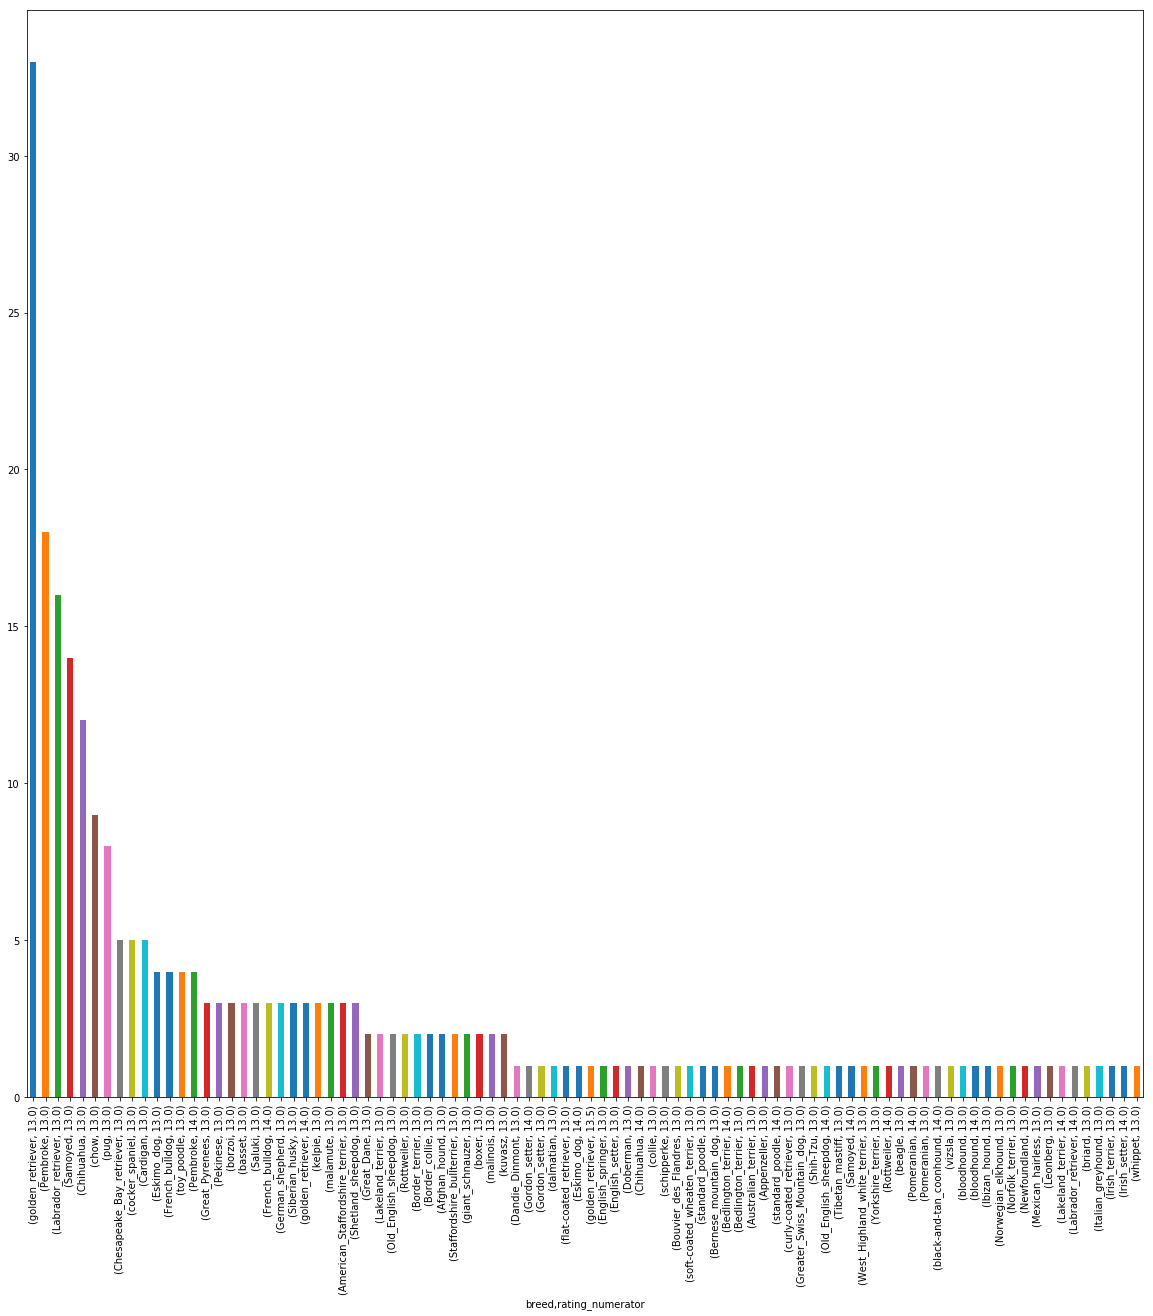

In [208]:
dfs.query('rating > 1.2').groupby([ 'breed','rating_numerator' ]).size().sort_values(ascending=False).plot(kind='bar', figsize=(20,20));

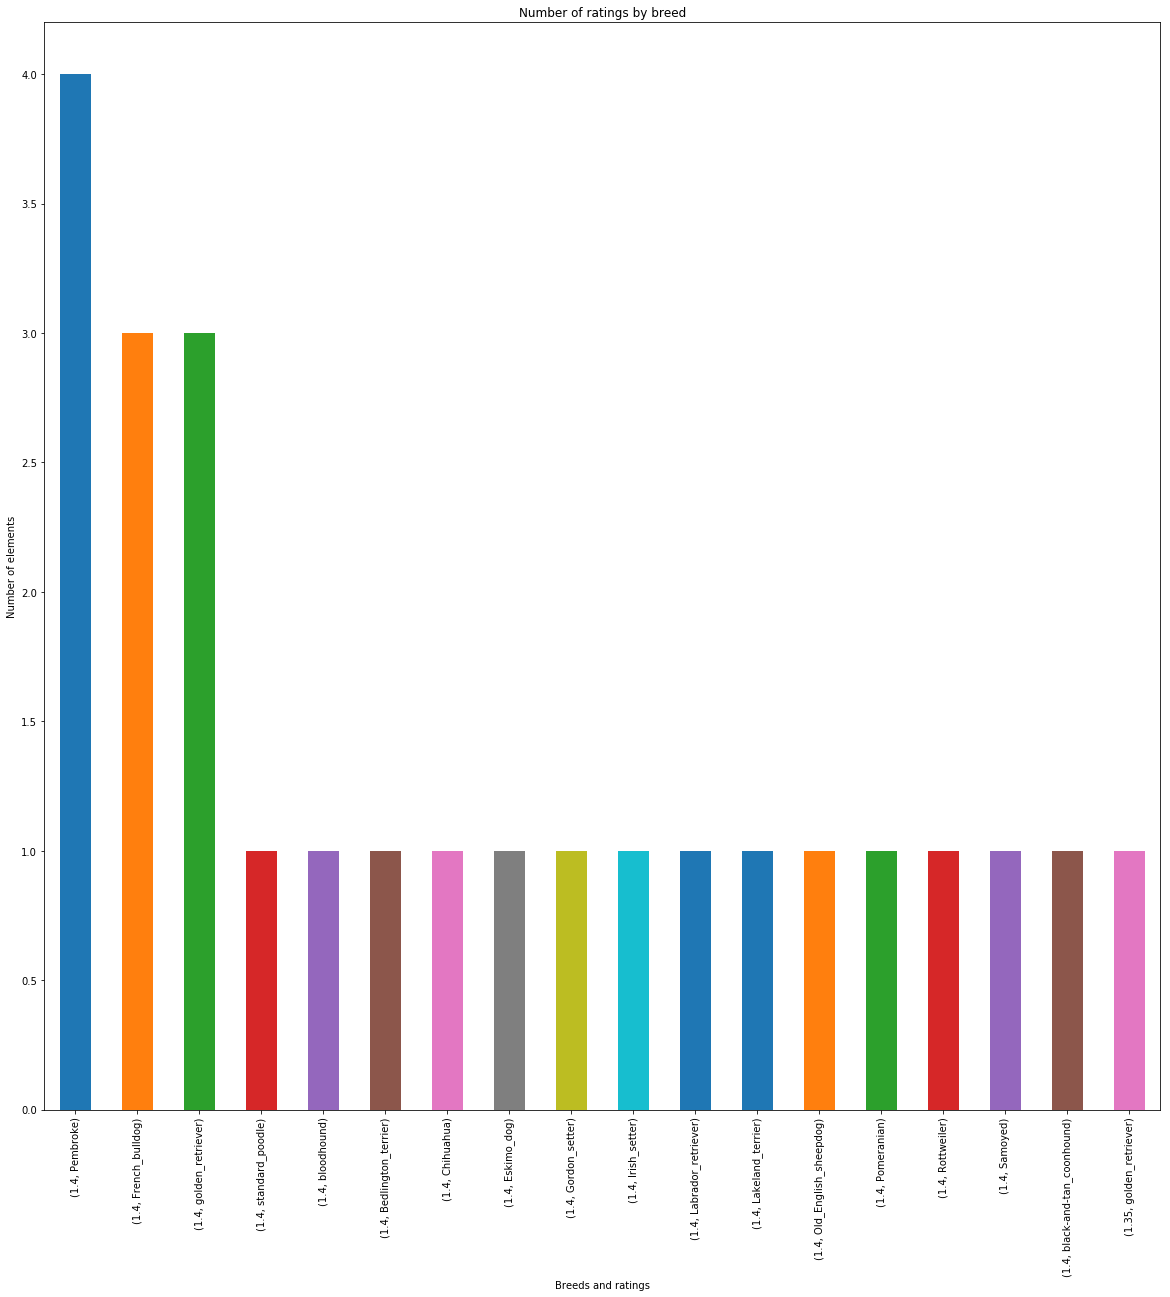

In [209]:
dfs.query('rating >= 1.35').groupby('rating').breed.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.title("Number of ratings by breed")
plt.xlabel("Breeds and ratings")
plt.ylabel("Number of elements");

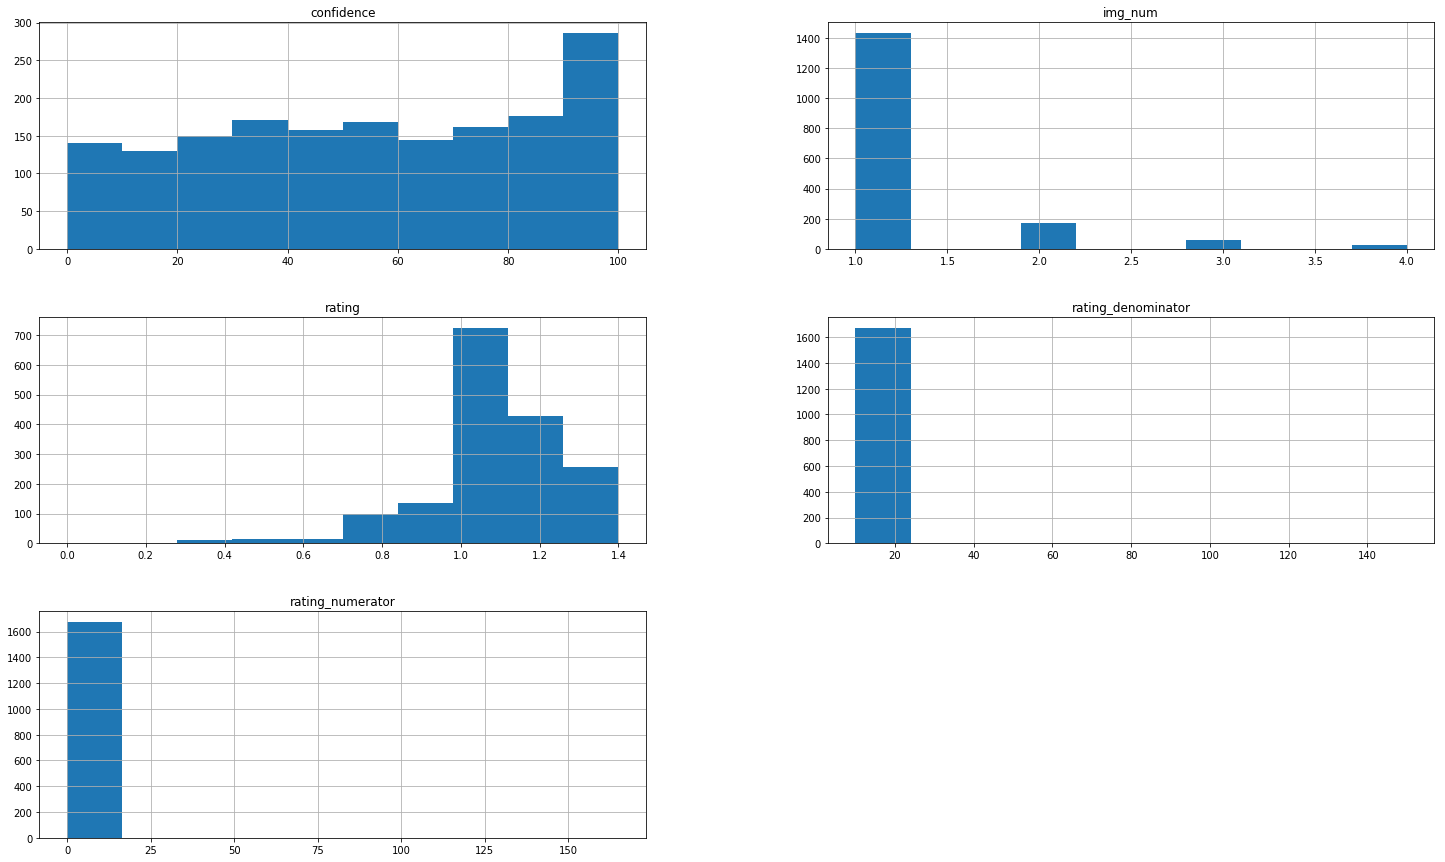

In [210]:
dfs.hist(figsize=(25,15));

In [211]:
dfs.dog_stage.value_counts()

pupper            168
doggo              54
puppo              21
doggo, pupper       8
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

In [212]:
lst_breed = dfs.breed.values
lst_breed

array(['Chihuahua', 'Chihuahua', 'Labrador_retriever', ...,
       'German_shepherd', 'redbone', 'Welsh_springer_spaniel'], dtype=object)

In [213]:
dfs.favorite_count.max()

132810

In [214]:
dfs.query('favorite_count > 100000').sort_values(by= 'favorite_count', ascending=False)

,breed,rating,confidence,favorite_count,retweet_count,dog_stage,tweet_id,text,rating_numerator,rating_denominator,img_num,in_reply_to_status_id,in_reply_to_user_id,text_url,expanded_urls,jpg_url,name,timestamp,source
309,Lakeland_terrier,1.3,19.6015,132810,48265,puppo,822872901745569793,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10,13.0,10.0,1,NaN,NaN,https://t.co/nTz3FtorBc,https://twitter.com/dog_rates/status/822872901745569793/photo/1,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,None,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
773,Labrador_retriever,1.3,82.5333,131075,79515,doggo,744234799360020481,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad),13.0,10.0,1,NaN,NaN,https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,None,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
58,English_springer,1.3,38.3404,107956,45849,NaN,879415818425184262,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici),13.0,10.0,1,NaN,NaN,https://t.co/UDT7ZkcTgY,https://twitter.com/dog_rates/status/879415818425184262/video/1,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,Duddles,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
399,Chihuahua,1.3,50.5370,107015,56625,NaN,807106840509214720,This is Stephan. He just wants to help. 13/10 such a good boy,13.0,10.0,1,NaN,NaN,https://t.co/DkBYaCAg2d,https://twitter.com/dog_rates/status/807106840509214720/video/1,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,Stephan,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
108,French_bulldog,1.3,90.5334,106827,32883,pupper,866450705531457537,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender",13.0,10.0,2,NaN,NaN,https://t.co/wk7TfysWHr,"https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1",https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,Jamesy,2017-05-22 00:28:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"


In this section, I decided to split each insight into two groups. The first was the "evaluation" group, and the second was the "conclusions."

### Insight 01 - Amount of tweets by breed

#### Evaluation

In [215]:
dfs.breed.value_counts()

golden_retriever                  157
Labrador_retriever                108
Pembroke                           95
Chihuahua                          91
pug                                62
toy_poodle                         51
chow                               48
Samoyed                            42
Pomeranian                         42
malamute                           33
French_bulldog                     31
Chesapeake_Bay_retriever           31
cocker_spaniel                     30
miniature_pinscher                 25
Eskimo_dog                         22
German_shepherd                    21
Cardigan                           21
Staffordshire_bullterrier          21
Shih-Tzu                           20
Siberian_husky                     20
beagle                             20
Maltese_dog                        19
Shetland_sheepdog                  19
Rottweiler                         19
Lakeland_terrier                   18
kuvasz                             18
basset      

Another way of showing the results above

[Stack Overflow - Converting a Pandas GroupBy output from Series to DataFrame](https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe)

[Stack Overflow - python, sort descending dataframe with pandas](https://stackoverflow.com/questions/24988873/python-sort-descending-dataframe-with-pandas)

In [216]:
dfs.groupby( [ "breed"] ).size().sort_values(ascending=False)

breed
golden_retriever                  157
Labrador_retriever                108
Pembroke                           95
Chihuahua                          91
pug                                62
toy_poodle                         51
chow                               48
Pomeranian                         42
Samoyed                            42
malamute                           33
Chesapeake_Bay_retriever           31
French_bulldog                     31
cocker_spaniel                     30
miniature_pinscher                 25
Eskimo_dog                         22
Staffordshire_bullterrier          21
Cardigan                           21
German_shepherd                    21
Siberian_husky                     20
beagle                             20
Shih-Tzu                           20
Shetland_sheepdog                  19
Rottweiler                         19
Maltese_dog                        19
kuvasz                             18
Lakeland_terrier                   18
basset

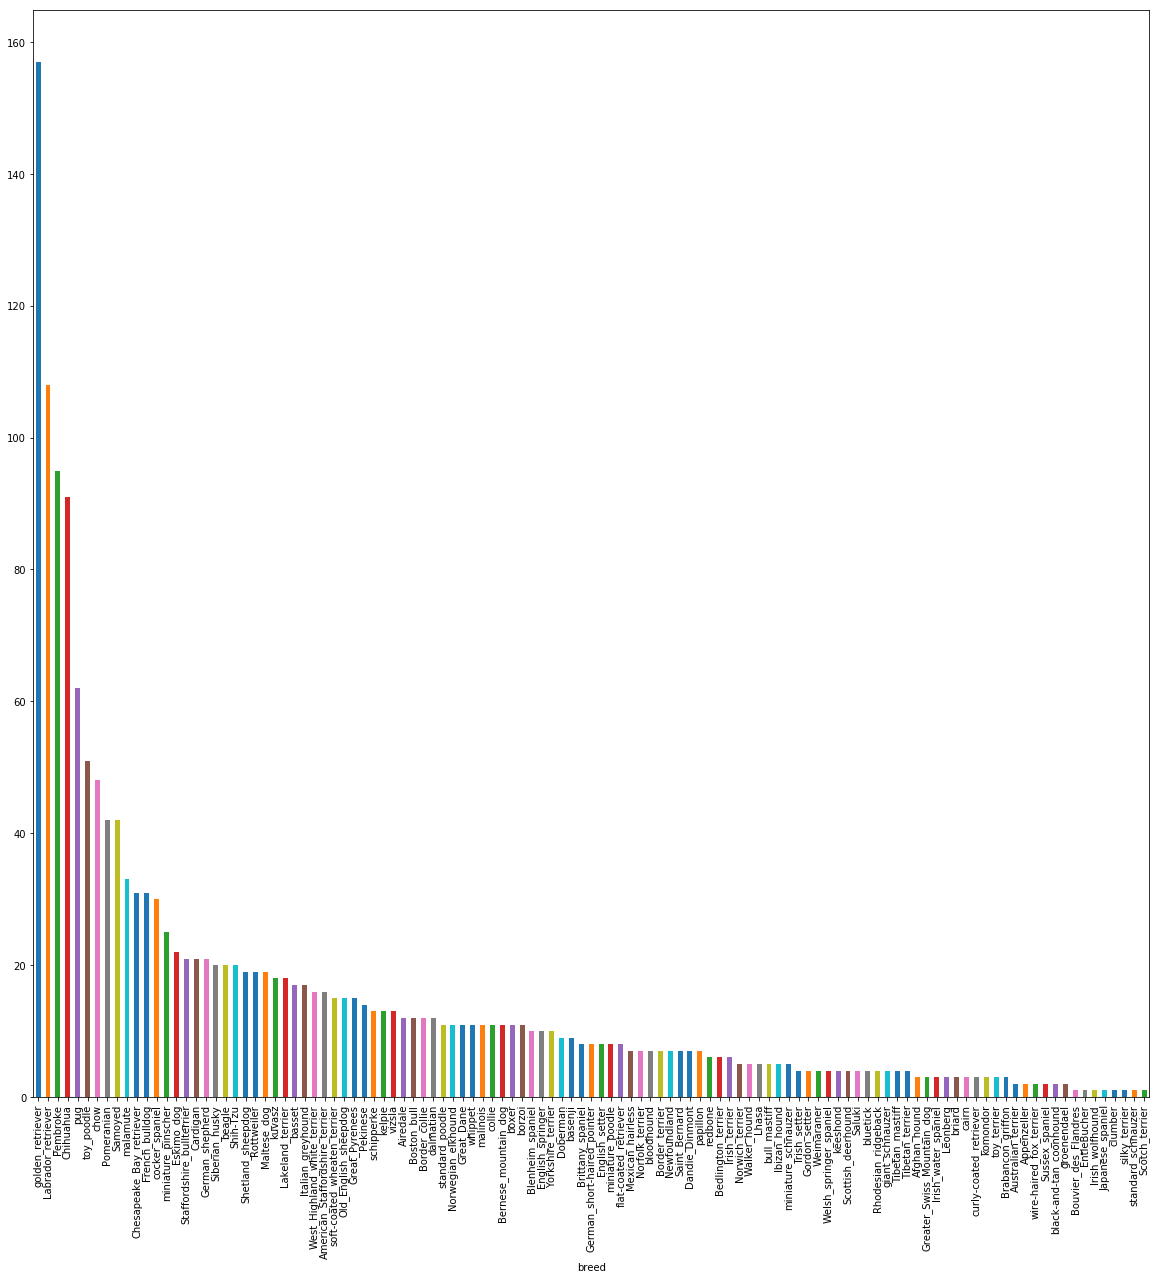

In [217]:
dfs.groupby( [ "breed"] ).size().sort_values(ascending=False).plot(kind='bar', figsize=(20,20));

In [218]:
num_tot = dfs.shape[0]
num_tot

1685

##### Confidence greather than 50%

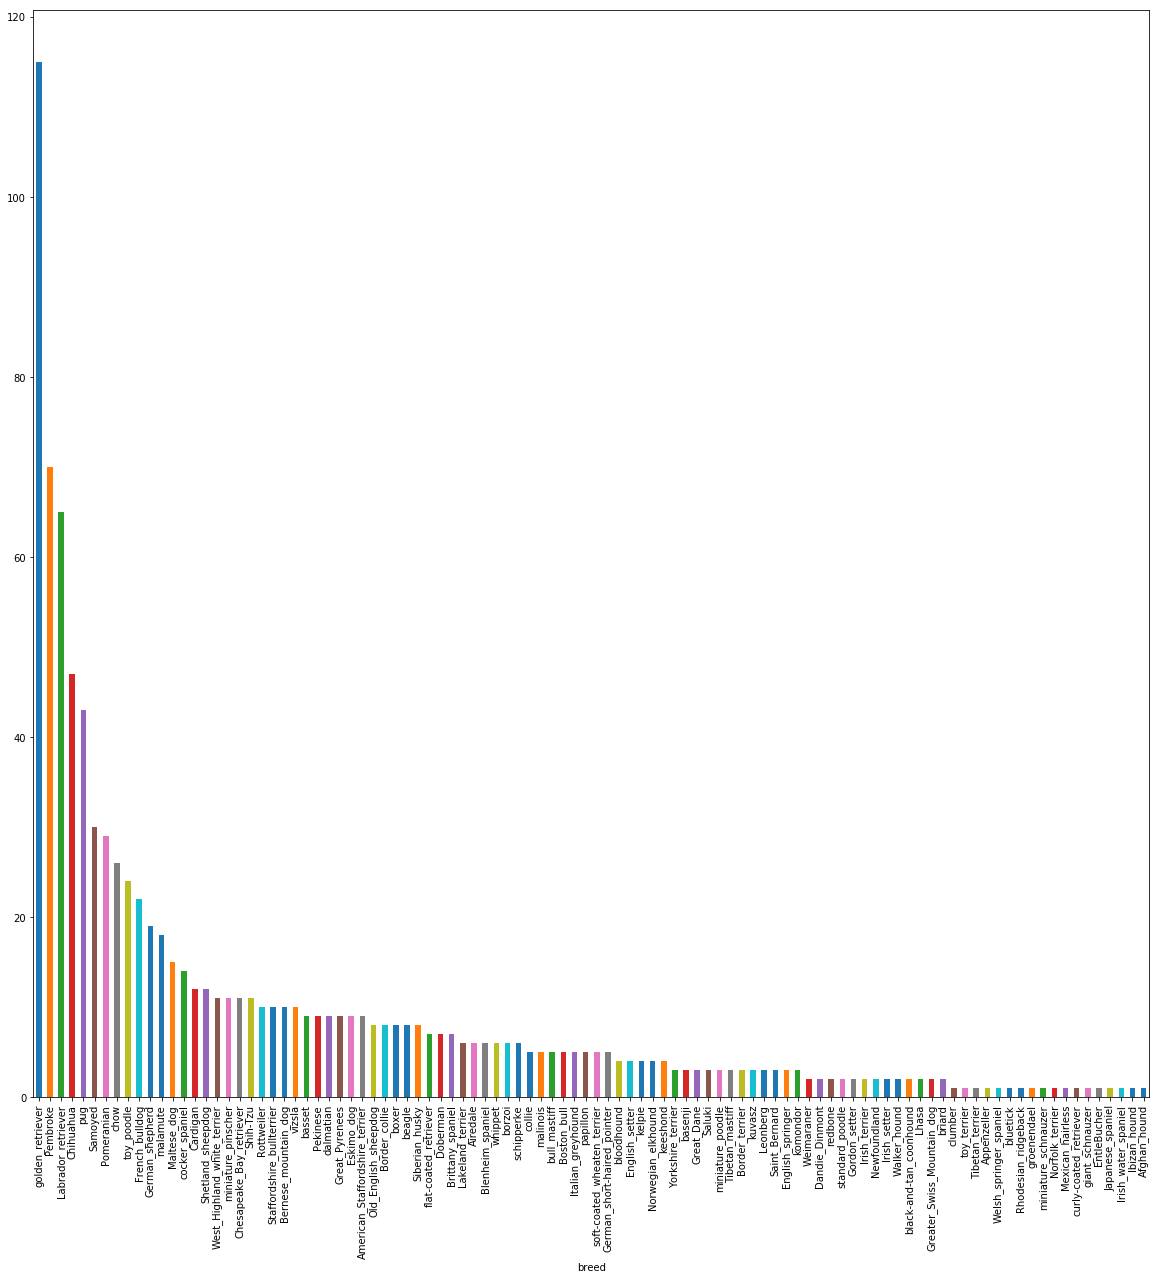

In [219]:
dfs.query('confidence > 50').groupby( [ "breed"] ).size().sort_values(ascending=False).plot(kind='bar',figsize=(20,20));

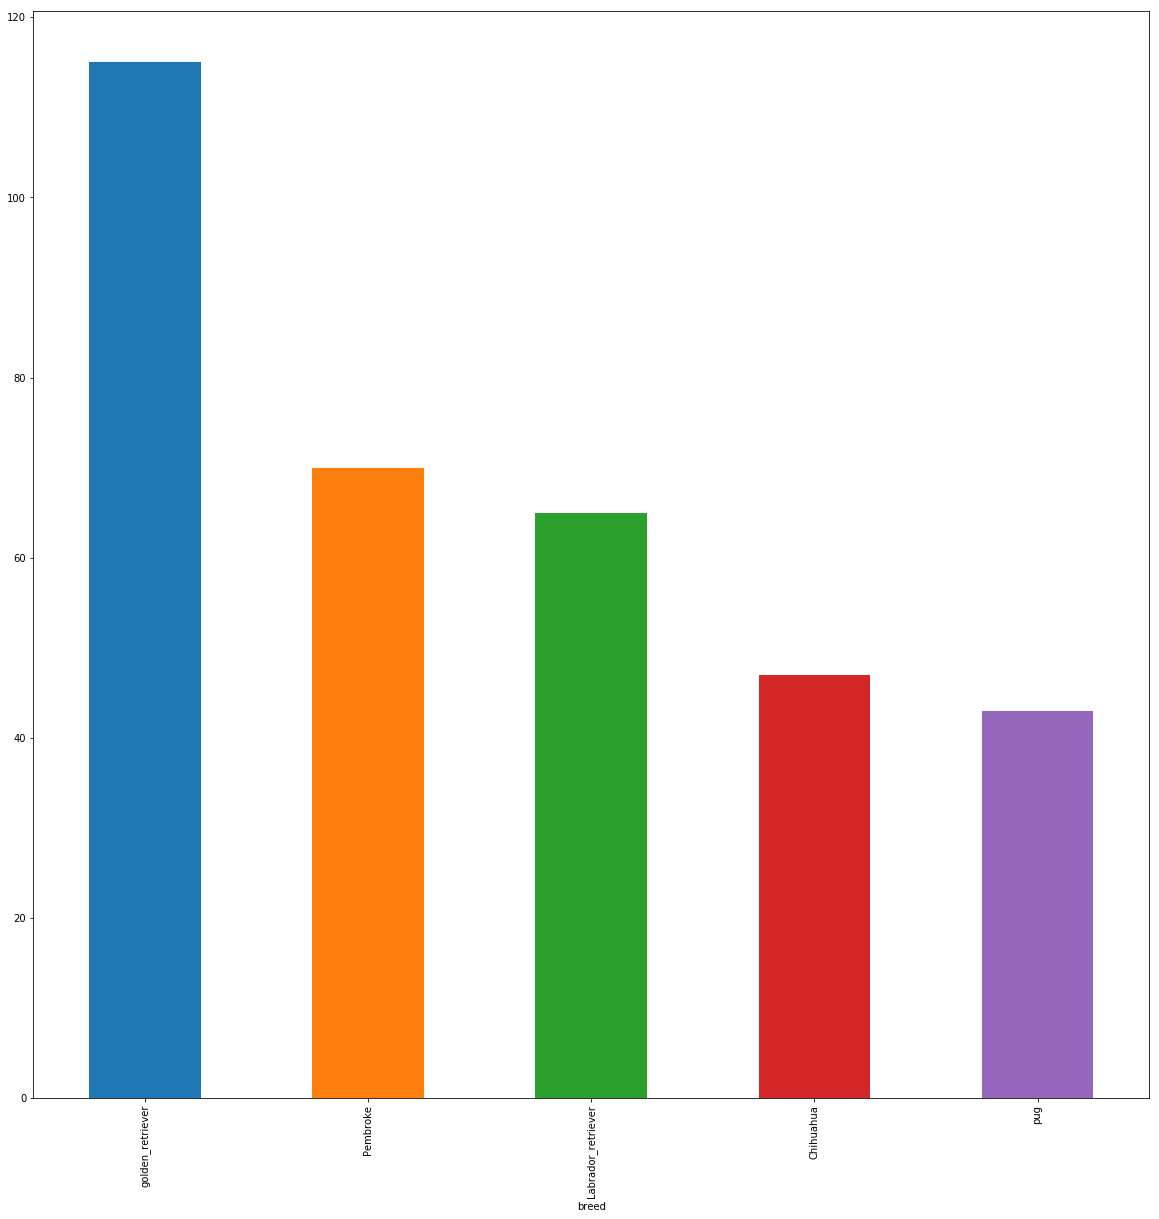

In [220]:
dfs.query('confidence > 50') \
.query('breed == "golden_retriever" or breed == "Pembroke" or breed == "Labrador_retriever" or breed == "Chihuahua" or breed == "pug"') \
.groupby('breed').size().sort_values(ascending=False) \
.plot(kind='bar',figsize=(20,20));

I tested this graphic only to check the breed distribution despite the concentration of the names on the right side.

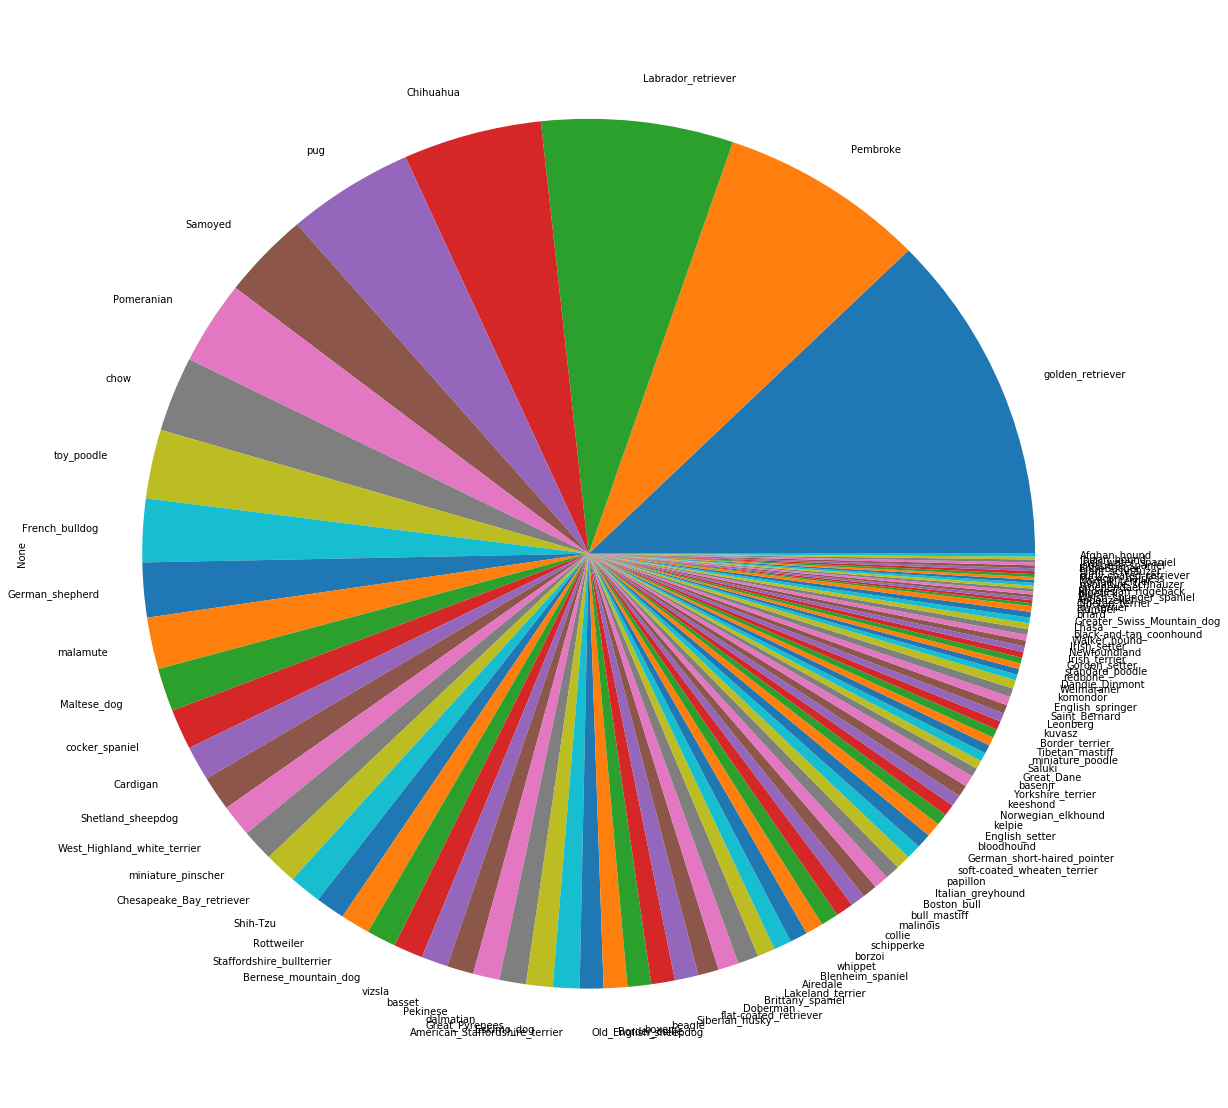

In [221]:
dfs.query('confidence > 50').groupby( [ "breed"] ).size().sort_values(ascending=False).plot(kind='pie',figsize=(20,20));

In [222]:
num_50 = dfs.query('confidence > 50').shape[0]
num_50

936

In [223]:
num_50 / num_tot * 100

55.54896142433235

##### Confidence greather than 75%

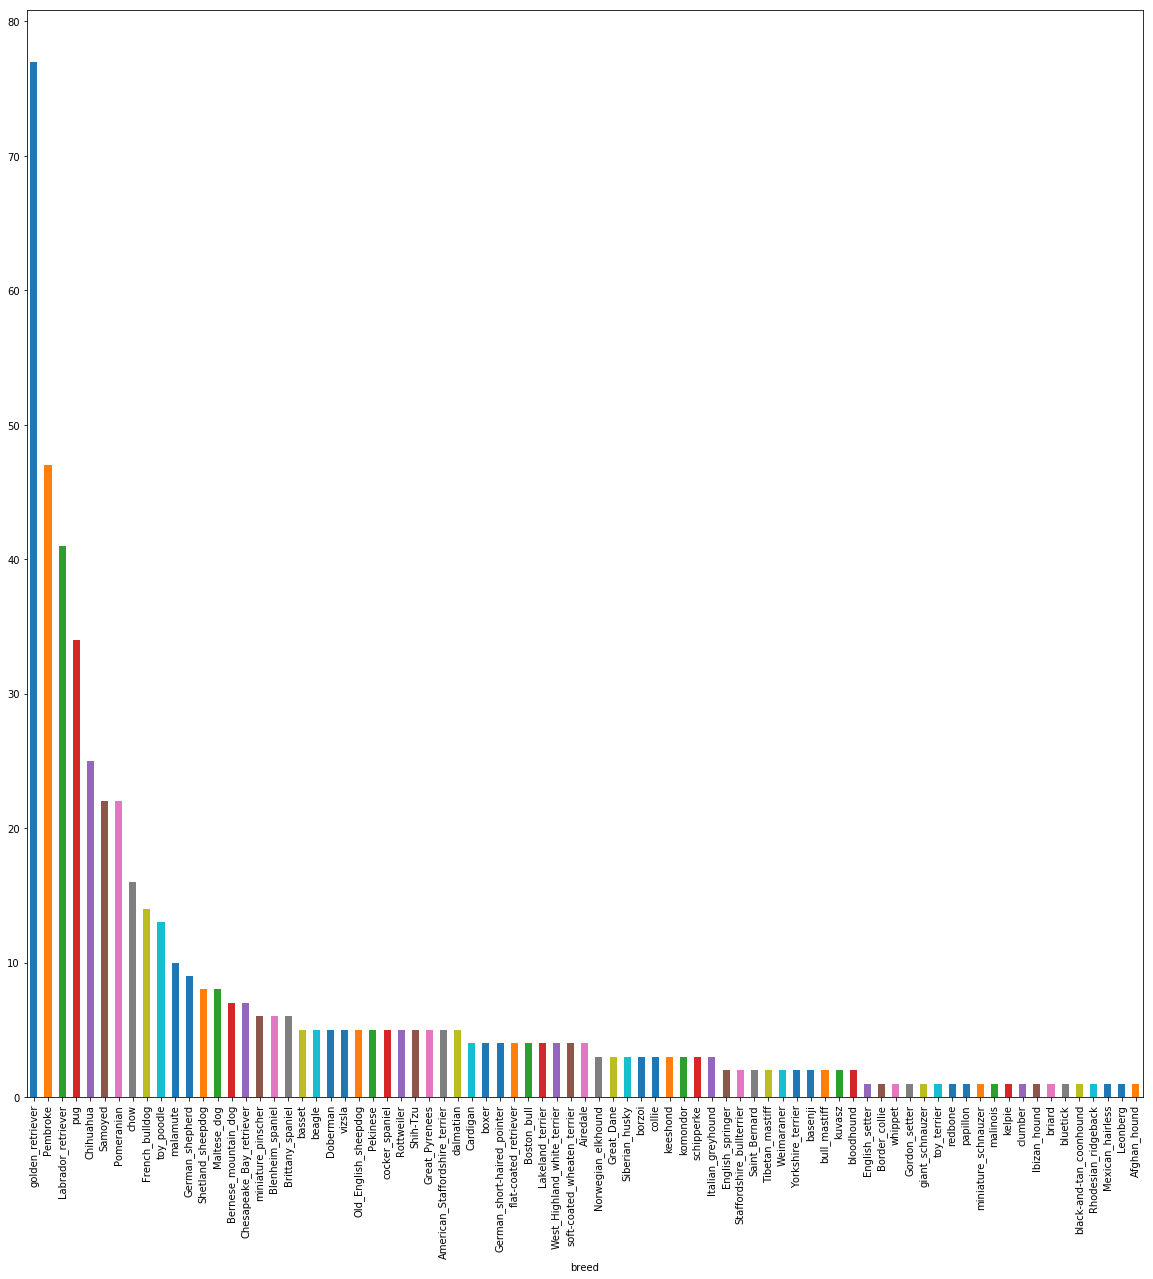

In [224]:
dfs.query('confidence > 75').groupby( [ "breed"] ).size().sort_values(ascending=False).plot(kind='bar',figsize=(20,20));

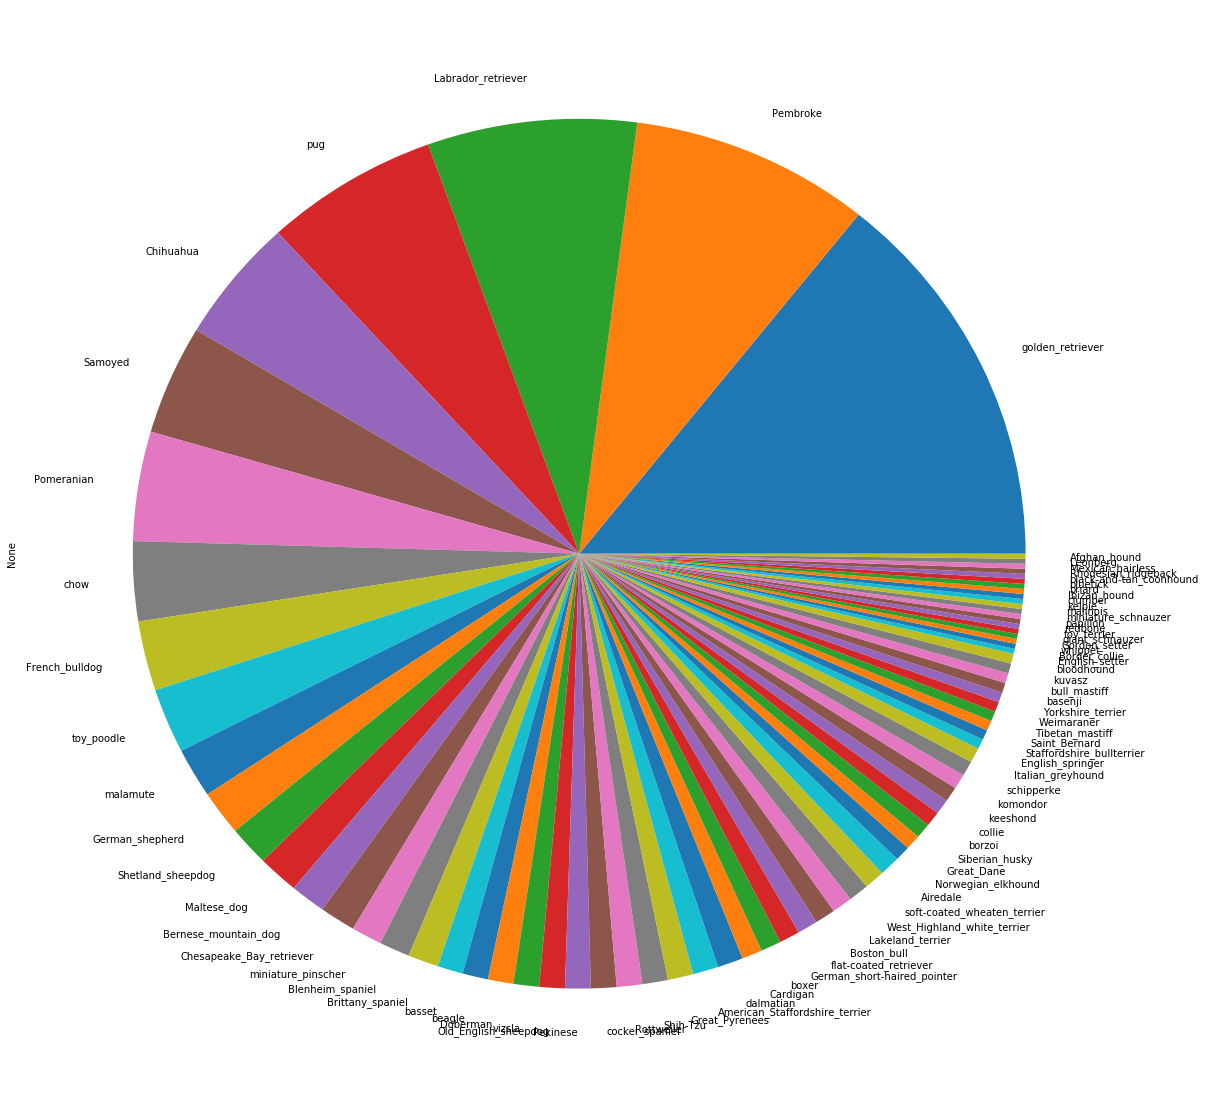

In [225]:
dfs.query('confidence > 75').groupby( [ "breed"] ).size().sort_values(ascending=False).plot(kind='pie',figsize=(20,20));

In [226]:
num_75 = dfs.query('confidence > 75').shape[0]
num_75

541

In [227]:
num_75 / num_tot * 100

32.10682492581603

##### Confidence greather than 25%

In [228]:
num_25 = dfs.query('confidence > 25').shape[0]
num_25

1352

In [229]:
num_25 / num_tot * 100

80.23738872403561

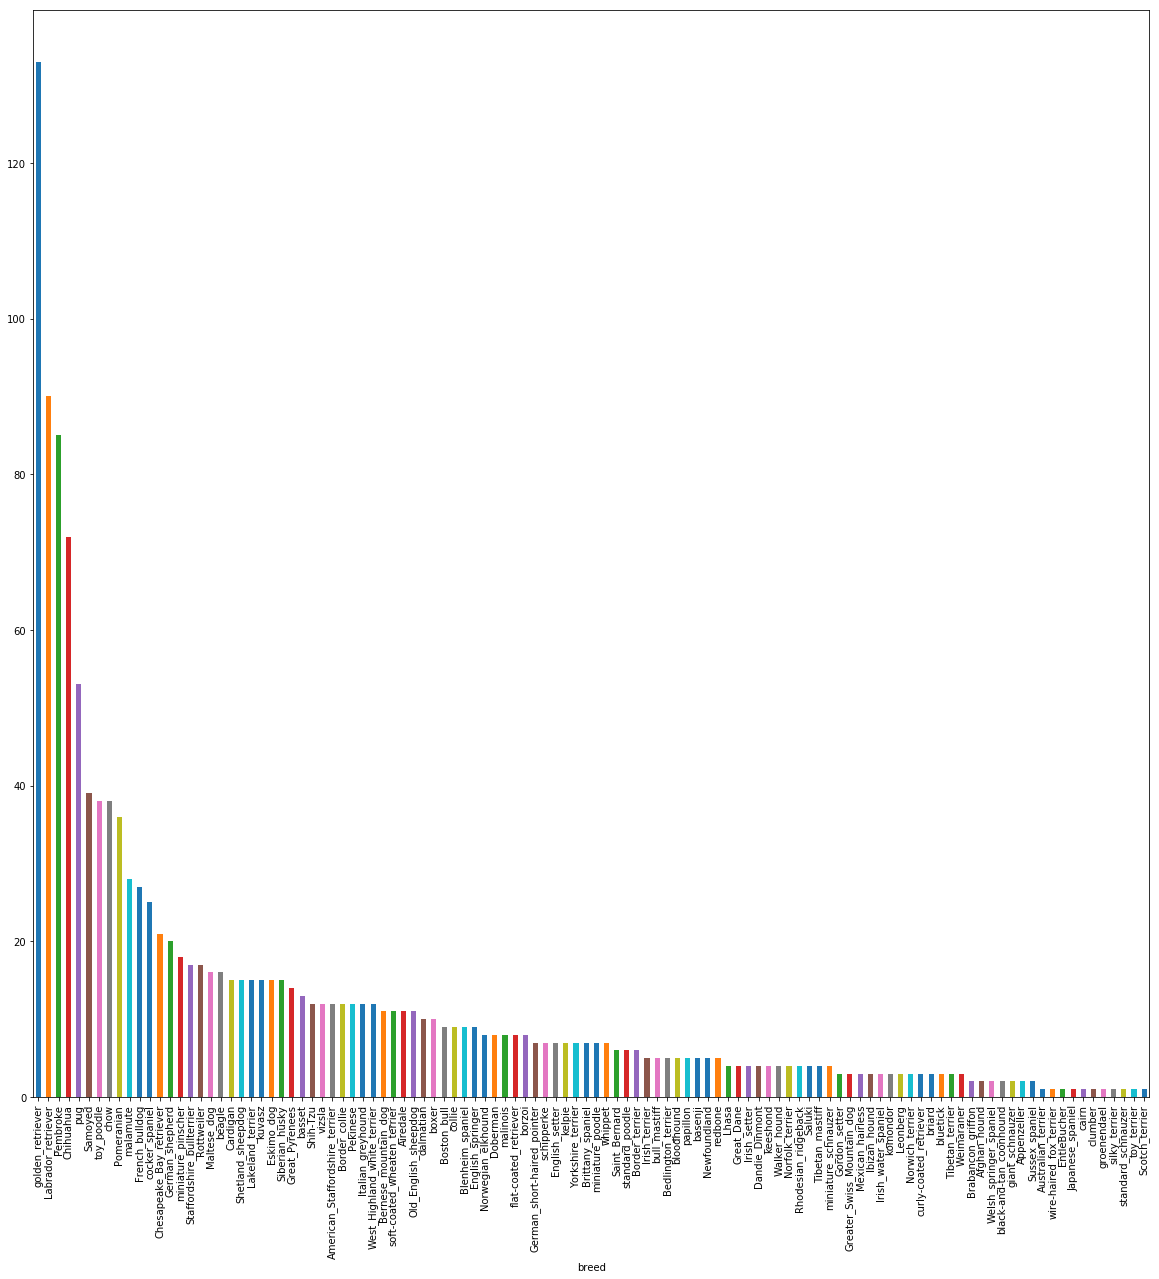

In [230]:
dfs.query('confidence > 25').groupby( [ "breed"] ).size().sort_values(ascending=False).plot(kind='bar',figsize=(20,20));

#### Confidence values and the number of elements in each scenario

I compared the confidence values and the number of elements in each scenario to define the best configuration of many components and image confidence.

I decided to be conservative and selected de scenario with confidence breeds images greater than fifty percent.

Many photos did not have only big images of dogs but also the environment surrounding the animal or some funny situations that influenced the ratings. I adopted this confidence to prioritize pictures representing the actual breed despite reducing the number of elements by half.

In [231]:
num_75 / num_tot * 100

32.10682492581603

In [232]:
num_50 / num_tot * 100

55.54896142433235

In [233]:
num_25 / num_tot * 100

80.23738872403561

In [234]:
dfs.breed.value_counts()

golden_retriever                  157
Labrador_retriever                108
Pembroke                           95
Chihuahua                          91
pug                                62
toy_poodle                         51
chow                               48
Samoyed                            42
Pomeranian                         42
malamute                           33
French_bulldog                     31
Chesapeake_Bay_retriever           31
cocker_spaniel                     30
miniature_pinscher                 25
Eskimo_dog                         22
German_shepherd                    21
Cardigan                           21
Staffordshire_bullterrier          21
Shih-Tzu                           20
Siberian_husky                     20
beagle                             20
Maltese_dog                        19
Shetland_sheepdog                  19
Rottweiler                         19
Lakeland_terrier                   18
kuvasz                             18
basset      

In [235]:
dfs.query('confidence > 25').breed.value_counts()

golden_retriever               133
Labrador_retriever              90
Pembroke                        85
Chihuahua                       72
pug                             53
Samoyed                         39
toy_poodle                      38
chow                            38
Pomeranian                      36
malamute                        28
French_bulldog                  27
cocker_spaniel                  25
Chesapeake_Bay_retriever        21
German_shepherd                 20
miniature_pinscher              18
Staffordshire_bullterrier       17
Rottweiler                      17
Maltese_dog                     16
beagle                          16
Siberian_husky                  15
kuvasz                          15
Lakeland_terrier                15
Eskimo_dog                      15
Shetland_sheepdog               15
Cardigan                        15
Great_Pyrenees                  14
basset                          13
Border_collie                   12
West_Highland_white_

In [236]:
dfs.query('confidence > 50').breed.value_counts()

golden_retriever                  115
Pembroke                           70
Labrador_retriever                 65
Chihuahua                          47
pug                                43
Samoyed                            30
Pomeranian                         29
chow                               26
toy_poodle                         24
French_bulldog                     22
German_shepherd                    19
malamute                           18
Maltese_dog                        15
cocker_spaniel                     14
Cardigan                           12
Shetland_sheepdog                  12
miniature_pinscher                 11
Chesapeake_Bay_retriever           11
West_Highland_white_terrier        11
Shih-Tzu                           11
Staffordshire_bullterrier          10
vizsla                             10
Bernese_mountain_dog               10
Rottweiler                         10
American_Staffordshire_terrier      9
basset                              9
dalmatian   

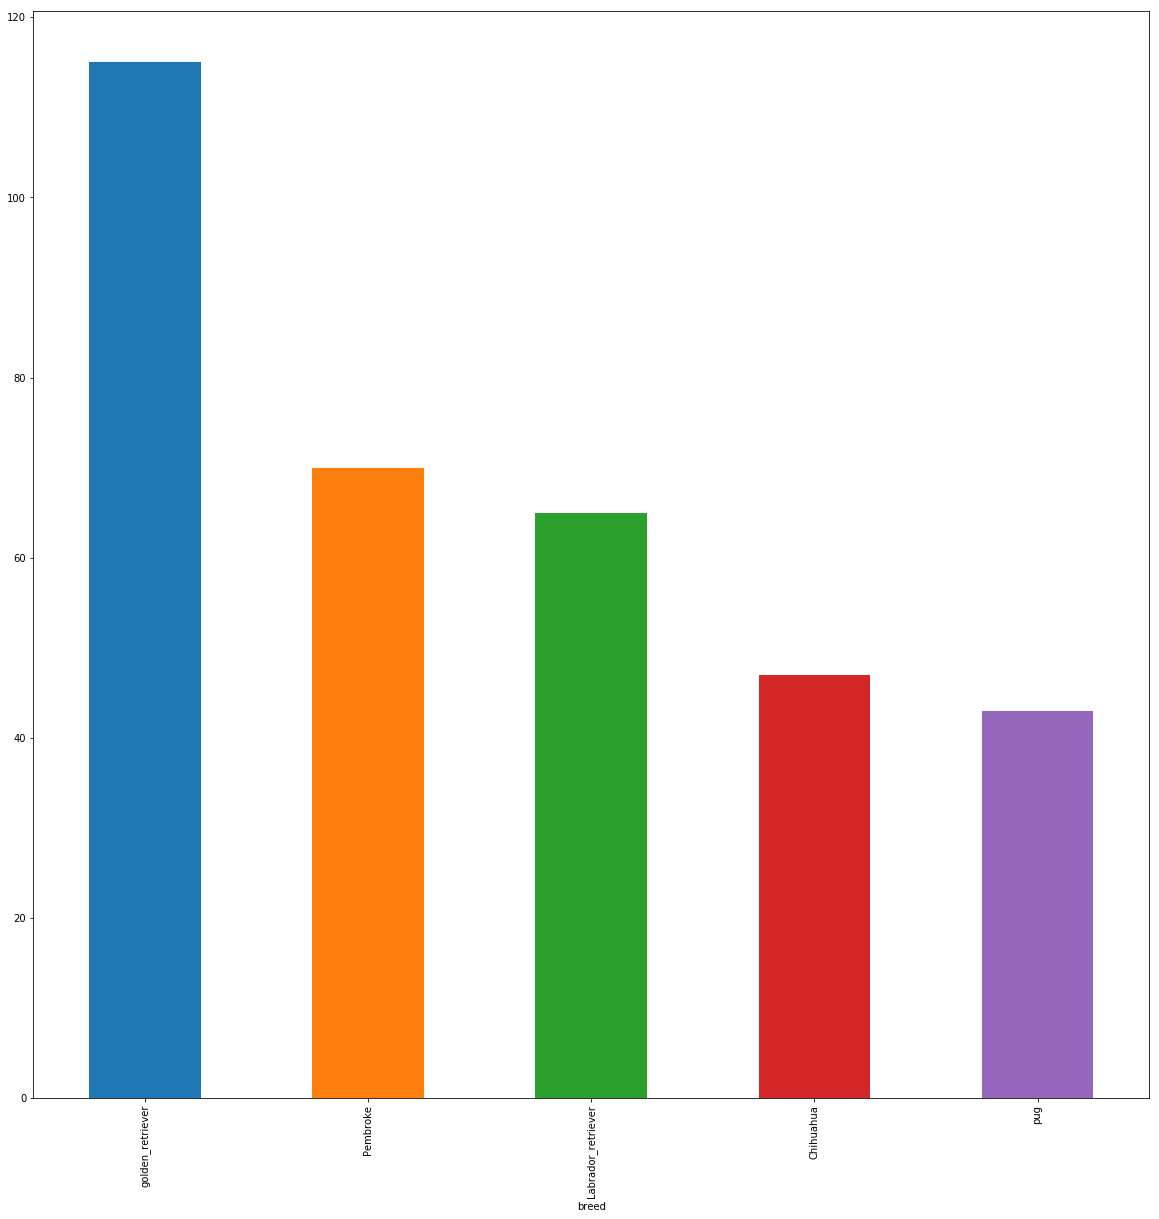

In [237]:
dfs.query('confidence > 50') \
.query('breed == "golden_retriever" or breed == "Pembroke" or breed == "Labrador_retriever" or breed == "Chihuahua" or breed == "pug"') \
.groupby('breed').size().sort_values(ascending=False) \
.plot(kind='bar',figsize=(20,20));

#### Conclusions

As we observed above, the "golden_retriever" group received the majority of tweets, considering the confidence level greater than 50%. We also had many elements of "Pembroke" and "Labrador_retriever" as the second group, considering the confidence level greater than 50%. The third group with more tweets was "Chihuahua" and "pug."

I removed the retweets in this classification and the images that were not a dog. I mainly considered the photos with a confidence interval of breeds superior to 50%.

### Inight 02 - Maximum values of "rating", "favorites" and "retweets" by breed

#### Evaluation

In [238]:
dfs.query('rating == 1.4 and confidence > 50')[['breed','rating']].sort_values('rating', ascending=False)

,breed,rating
9,Pembroke,1.4
313,Pomeranian,1.4
570,Eskimo_dog,1.4
548,Pembroke,1.4
398,golden_retriever,1.4
362,French_bulldog,1.4
324,Gordon_setter,1.4
318,Irish_setter,1.4
297,Rottweiler,1.4
36,Pembroke,1.4


In [239]:
dfs.query('rating == 1.4 and confidence > 50').groupby(['breed']).rating_numerator.size().sort_values(ascending=False)

breed
golden_retriever           3
Pembroke                   3
French_bulldog             2
bloodhound                 1
black-and-tan_coonhound    1
Rottweiler                 1
Pomeranian                 1
Old_English_sheepdog       1
Irish_setter               1
Gordon_setter              1
Eskimo_dog                 1
Chihuahua                  1
Name: rating_numerator, dtype: int64

In [240]:
dfs.rating.max()

1.3999999999999999

In [241]:
dfs.query('favorite_count > 90000 and confidence > 50')[['breed','favorite_count']].sort_values('favorite_count',ascending=False)

,breed,favorite_count
773,Labrador_retriever,131075
399,Chihuahua,107015
108,French_bulldog,106827


In [242]:
dfs.favorite_count.max()

132810

In [243]:
dfs.query('favorite_count == 132810')

,breed,rating,confidence,favorite_count,retweet_count,dog_stage,tweet_id,text,rating_numerator,rating_denominator,img_num,in_reply_to_status_id,in_reply_to_user_id,text_url,expanded_urls,jpg_url,name,timestamp,source
309,Lakeland_terrier,1.3,19.6015,132810,48265,puppo,822872901745569793,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10,13.0,10.0,1,NaN,NaN,https://t.co/nTz3FtorBc,https://twitter.com/dog_rates/status/822872901745569793/photo/1,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,None,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"


[Tweet_id 822872901745569793 - index 309](https://twitter.com/dog_rates/status/822872901745569793)

In [244]:
dfs.query('retweet_count > 32000 and confidence > 50')[['breed','retweet_count']].sort_values('retweet_count',ascending=False)

,breed,retweet_count
773,Labrador_retriever,79515
399,Chihuahua,56625
808,Eskimo_dog,52360
108,French_bulldog,32883


In [245]:
dfs.retweet_count.max()

79515

In [246]:
dfs.query('retweet_count == 79515')

,breed,rating,confidence,favorite_count,retweet_count,dog_stage,tweet_id,text,rating_numerator,rating_denominator,img_num,in_reply_to_status_id,in_reply_to_user_id,text_url,expanded_urls,jpg_url,name,timestamp,source
773,Labrador_retriever,1.3,82.5333,131075,79515,doggo,744234799360020481,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad),13.0,10.0,1,NaN,NaN,https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,None,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"


[Tweet_id 744234799360020481- index 773](https://twitter.com/dog_rates/status/744234799360020481)

#### Conclusions

I analyzed the most appreciated breeds, considering the max values of "ratings," "favorites," and "retweets."

Considering the `rating` values and confidence greater than fifty, the most well-evaluated breeds were "golden_retriever" and "Pembroke", and the third was "French_bulldog".

The groups "Labrador_retriever," "Chihuahua," and "French_bulldog" received more likes.

I considered the favorites evaluations more critical than the retweets in this analysis. But we could realize that the main breeds are the same in these two cases.

This kind of evaluation above considered only the max values of each breed. In the following assessment, I considered the average values, and the results are more significant than these.

### Insight 03 - Average rating by breed

#### Evaluation

In [247]:
dfs.query('confidence > 50').rating.value_counts().sort_values(ascending=False)

1.200    256
1.100    204
1.000    197
1.300    144
0.900     58
0.800     31
1.400     17
0.700     13
0.500      8
0.600      3
0.300      1
1.127      1
1.350      1
0.200      1
0.400      1
Name: rating, dtype: int64

In [248]:
dfs.query('confidence > 50').rating.describe()

count    936.000000
mean       1.105638
std        0.162248
min        0.200000
25%        1.000000
50%        1.100000
75%        1.200000
max        1.400000
Name: rating, dtype: float64

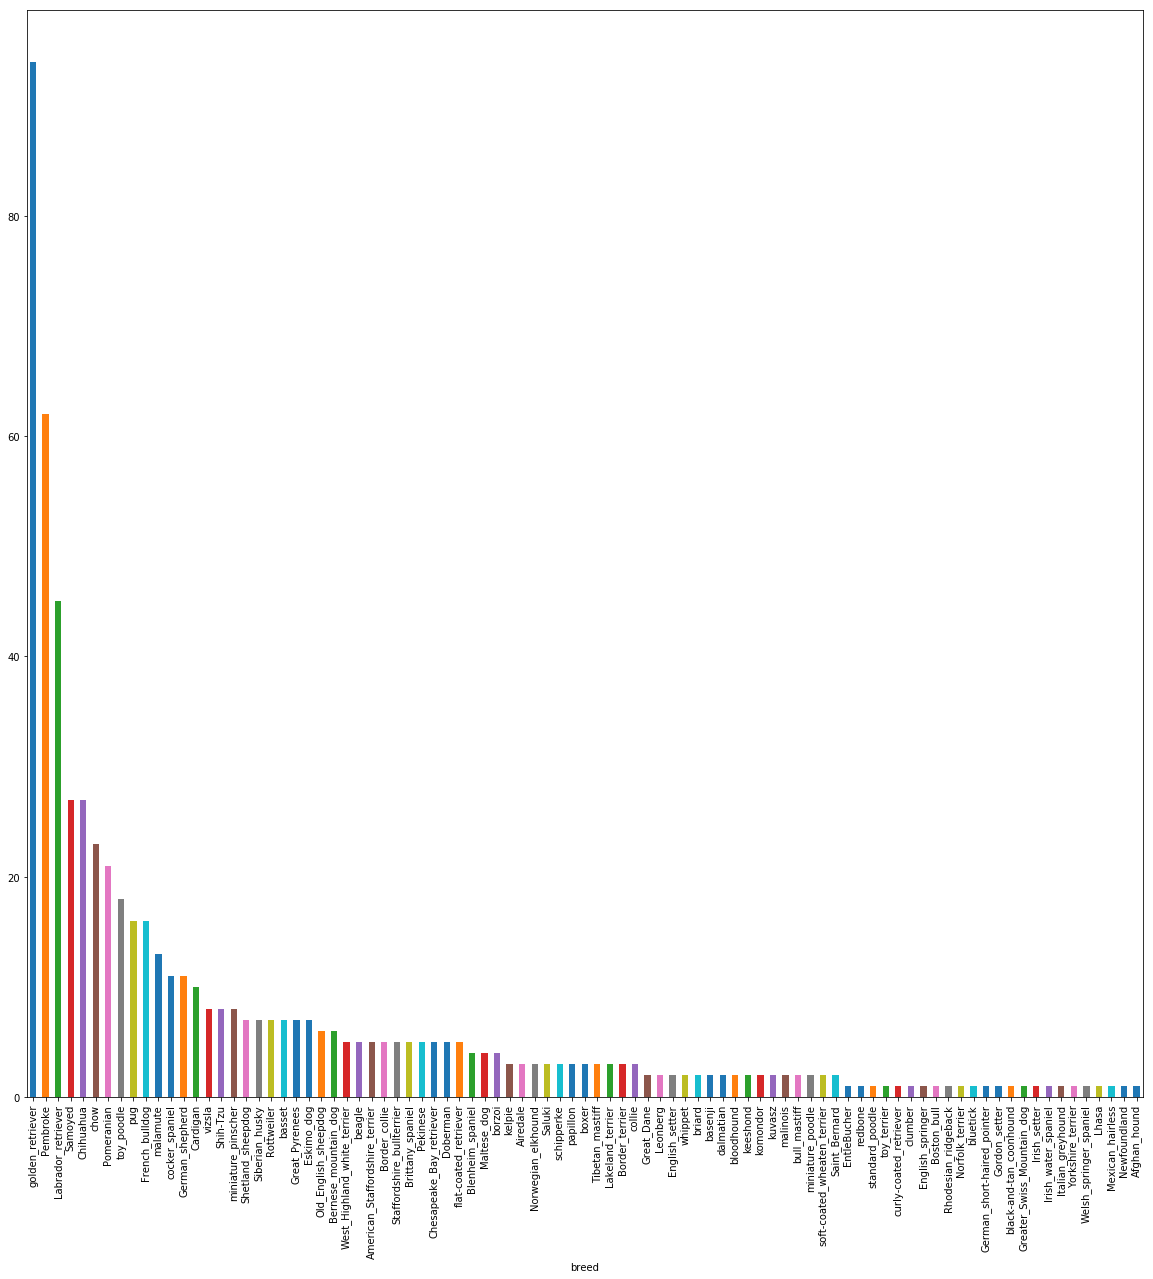

In [249]:
dfs.query('rating >= 1.1 and confidence > 50').groupby( [ "breed"] ).size().sort_values(ascending=False).plot(kind='bar', figsize=(20,20));

In this graph above, we could consider that the most well-evaluated breeds are the "golden_retiever," "Pembroke," "Labrador retriever," "Samoyed," "Chihuahua," and "chow." The number of tweets influences this evaluation. <b>The most adequate way to deal with rating is to consider the average.</b>

In [250]:
lst_breed = dfs.breed.values
lst_breed

array(['Chihuahua', 'Chihuahua', 'Labrador_retriever', ...,
       'German_shepherd', 'redbone', 'Welsh_springer_spaniel'], dtype=object)

[Stack Overflow - Removing duplicates in lists](https://stackoverflow.com/questions/7961363/removing-duplicates-in-lists)

[Geeks for Geeks - Python – Ways to remove duplicates from list](https://www.geeksforgeeks.org/python-ways-to-remove-duplicates-from-list/)

In [251]:
lst_breed = list(set(lst_breed))
lst_breed

['borzoi',
 'Shetland_sheepdog',
 'Newfoundland',
 'miniature_schnauzer',
 'Irish_wolfhound',
 'toy_poodle',
 'Siberian_husky',
 'bull_mastiff',
 'redbone',
 'Lakeland_terrier',
 'Walker_hound',
 'clumber',
 'golden_retriever',
 'Staffordshire_bullterrier',
 'black-and-tan_coonhound',
 'German_shepherd',
 'miniature_poodle',
 'Blenheim_spaniel',
 'German_short-haired_pointer',
 'malinois',
 'Bouvier_des_Flandres',
 'Airedale',
 'groenendael',
 'English_setter',
 'Welsh_springer_spaniel',
 'vizsla',
 'Great_Pyrenees',
 'toy_terrier',
 'papillon',
 'Tibetan_terrier',
 'Cardigan',
 'Rottweiler',
 'flat-coated_retriever',
 'Boston_bull',
 'Japanese_spaniel',
 'dalmatian',
 'Tibetan_mastiff',
 'Chihuahua',
 'Norwich_terrier',
 'Samoyed',
 'curly-coated_retriever',
 'bloodhound',
 'Bedlington_terrier',
 'kelpie',
 'Norwegian_elkhound',
 'Pekinese',
 'Italian_greyhound',
 'briard',
 'Scottish_deerhound',
 'Pembroke',
 'Border_terrier',
 'soft-coated_wheaten_terrier',
 'Eskimo_dog',
 'keeshond

In [252]:
type(lst_breed)

list

In [253]:
# The unique() code is another way to create one list without repetition.
# Reference: Search 12
dfs.breed.unique()

array(['Chihuahua', 'Labrador_retriever', 'basset',
       'Chesapeake_Bay_retriever', 'Appenzeller', 'Pomeranian',
       'Irish_terrier', 'Pembroke', 'Samoyed', 'French_bulldog',
       'golden_retriever', 'whippet', 'Siberian_husky', 'Mexican_hairless',
       'kuvasz', 'pug', 'Blenheim_spaniel', 'malamute',
       'Italian_greyhound', 'chow', 'German_shepherd', 'Doberman',
       'Eskimo_dog', 'Weimaraner', 'Saluki', 'miniature_pinscher',
       'German_short-haired_pointer', 'English_springer', 'vizsla',
       'bloodhound', 'Bernese_mountain_dog', 'West_Highland_white_terrier',
       'cocker_spaniel', 'flat-coated_retriever', 'Cardigan',
       'Newfoundland', 'Shetland_sheepdog', 'komondor', 'kelpie',
       'Greater_Swiss_Mountain_dog', 'Border_collie', 'bull_mastiff',
       'Staffordshire_bullterrier', 'Lakeland_terrier',
       'Australian_terrier', 'Bouvier_des_Flandres', 'Bedlington_terrier',
       'Boston_bull', 'Old_English_sheepdog', 'black-and-tan_coonhound',
       

In [254]:
dfs_avg = pd.DataFrame()
lst_rat_avg = []
lst_fav_avg = []
lst_ret_avg = []
for brd in lst_breed:
    count = 0
    num = 0
    fav = 0
    ret = 0
    for idx in dfs.index:
        if dfs.loc[idx,'breed'] == brd:
            count+=1
            num+= dfs.loc[idx,'rating']
            fav+= dfs.loc[idx,'favorite_count']
            ret+= dfs.loc[idx,'retweet_count']
    lst_rat_avg.append(round(num/count, 2))
    lst_fav_avg.append(round(fav/count, 2))
    lst_ret_avg.append(round(ret/count, 2))
dfs_avg['breed'] = lst_breed
dfs_avg['rat_avg'] = lst_rat_avg
dfs_avg['fav_avg'] = lst_fav_avg
dfs_avg['ret_avg'] = lst_ret_avg

In [255]:
dfs_avg.head()

,breed,rat_avg,fav_avg,ret_avg
0,borzoi,1.03,5273.09,1659.91
1,Shetland_sheepdog,1.05,8910.05,2440.21
2,Newfoundland,0.99,6861.43,1618.71
3,miniature_schnauzer,0.96,3409.00,936.60
4,Irish_wolfhound,1.10,1534.00,819.00


In [256]:
dfs_avg.shape

(113, 4)

I also decided to check only the tweets with `confidence` greather than 50%.

In [257]:
dfs_avg50 = pd.DataFrame()
lst_rat_avg = []
lst_fav_avg = []
lst_ret_avg = []
for brd in lst_breed:
    count = 0
    num = 0
    fav = 0
    ret = 0
    for idx in dfs.index:
        if dfs.loc[idx,'breed'] == brd and dfs.loc[idx,'confidence'] > 50:
            count+=1
            num+= dfs.loc[idx,'rating']
            fav+= dfs.loc[idx,'favorite_count']
            ret+= dfs.loc[idx,'retweet_count']
    if count != 0:
        lst_rat_avg.append(round(num/count, 2))
        lst_fav_avg.append(round(fav/count, 2))
        lst_ret_avg.append(round(ret/count, 2))
    else:
        lst_rat_avg.append(0)
        lst_fav_avg.append(0)
        lst_ret_avg.append(0)
dfs_avg50['breed'] = lst_breed
dfs_avg50['rat_avg'] = lst_rat_avg
dfs_avg50['fav_avg'] = lst_fav_avg
dfs_avg50['ret_avg'] = lst_ret_avg

In [258]:
dfs_avg50.head()

,breed,rat_avg,fav_avg,ret_avg
0,borzoi,1.12,7756.50,2400.67
1,Shetland_sheepdog,1.08,8802.42,2593.25
2,Newfoundland,1.15,16014.50,3055.50
3,miniature_schnauzer,0.50,763.00,349.00
4,Irish_wolfhound,0.00,0.00,0.00


## 5+

In [259]:
dfs_avg.query('rat_avg >= 1.21').sort_values('rat_avg', ascending=False)

,breed,rat_avg,fav_avg,ret_avg
20,Bouvier_des_Flandres,1.30,18032.00,4479.00
69,Saluki,1.25,24060.00,5133.75
36,Tibetan_mastiff,1.23,12173.50,4193.00
47,briard,1.23,9511.67,2966.67
50,Border_terrier,1.21,13578.00,3377.14


In [260]:
dfs_avg.query('rat_avg >= 1.21')[['breed','rat_avg']].sort_values('rat_avg', ascending=False)

,breed,rat_avg
20,Bouvier_des_Flandres,1.30
69,Saluki,1.25
36,Tibetan_mastiff,1.23
47,briard,1.23
50,Border_terrier,1.21


[Stack Overflow - AttributeError: Cannot access callable attribute 'groupby' of 'DataFrameGroupBy' objects](https://stackoverflow.com/questions/53406056/attributeerror-cannot-access-callable-attribute-groupby-of-dataframegroupby)

In [261]:
dfs_avg.query('rat_avg >= 1.21').set_index(['breed','rat_avg']).sort_values('rat_avg',ascending=False)

,,fav_avg,ret_avg
breed,rat_avg,,
Bouvier_des_Flandres,1.30,18032.00,4479.00
Saluki,1.25,24060.00,5133.75
Tibetan_mastiff,1.23,12173.50,4193.00
briard,1.23,9511.67,2966.67
Border_terrier,1.21,13578.00,3377.14


In [262]:
dfs_avg.query('rat_avg >= 1.21').set_index(['breed']).rat_avg.sort_values(ascending=False)

breed
Bouvier_des_Flandres    1.30
Saluki                  1.25
briard                  1.23
Tibetan_mastiff         1.23
Border_terrier          1.21
Name: rat_avg, dtype: float64

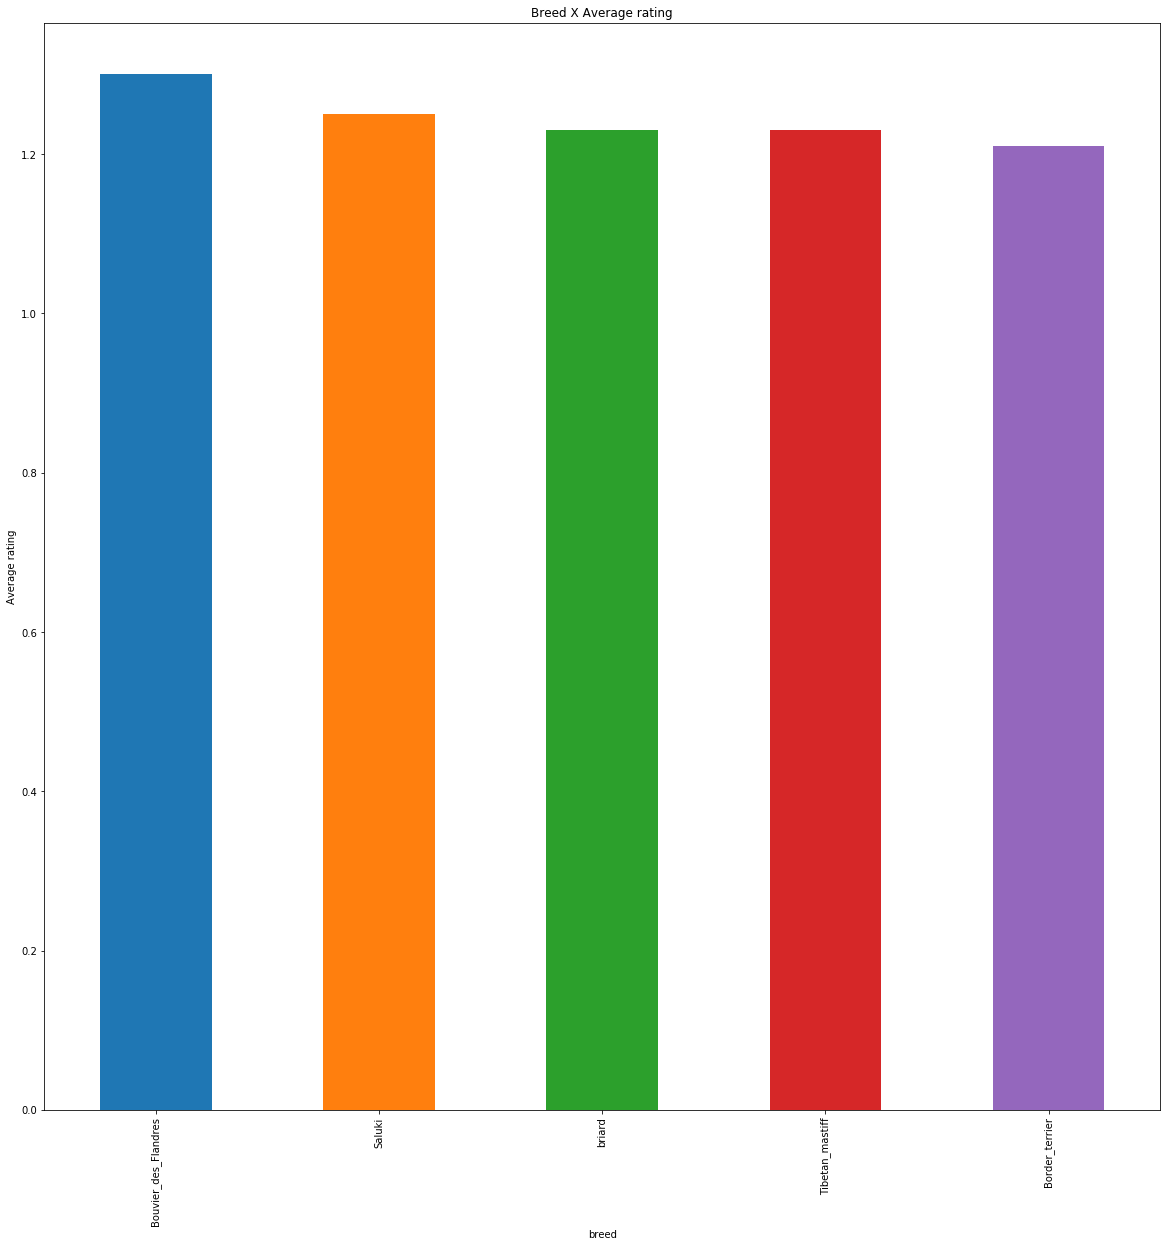

In [263]:
dfs_avg.query('rat_avg >= 1.21').set_index(['breed']).rat_avg.sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.title("Breed X Average rating")
plt.ylabel("Average rating");

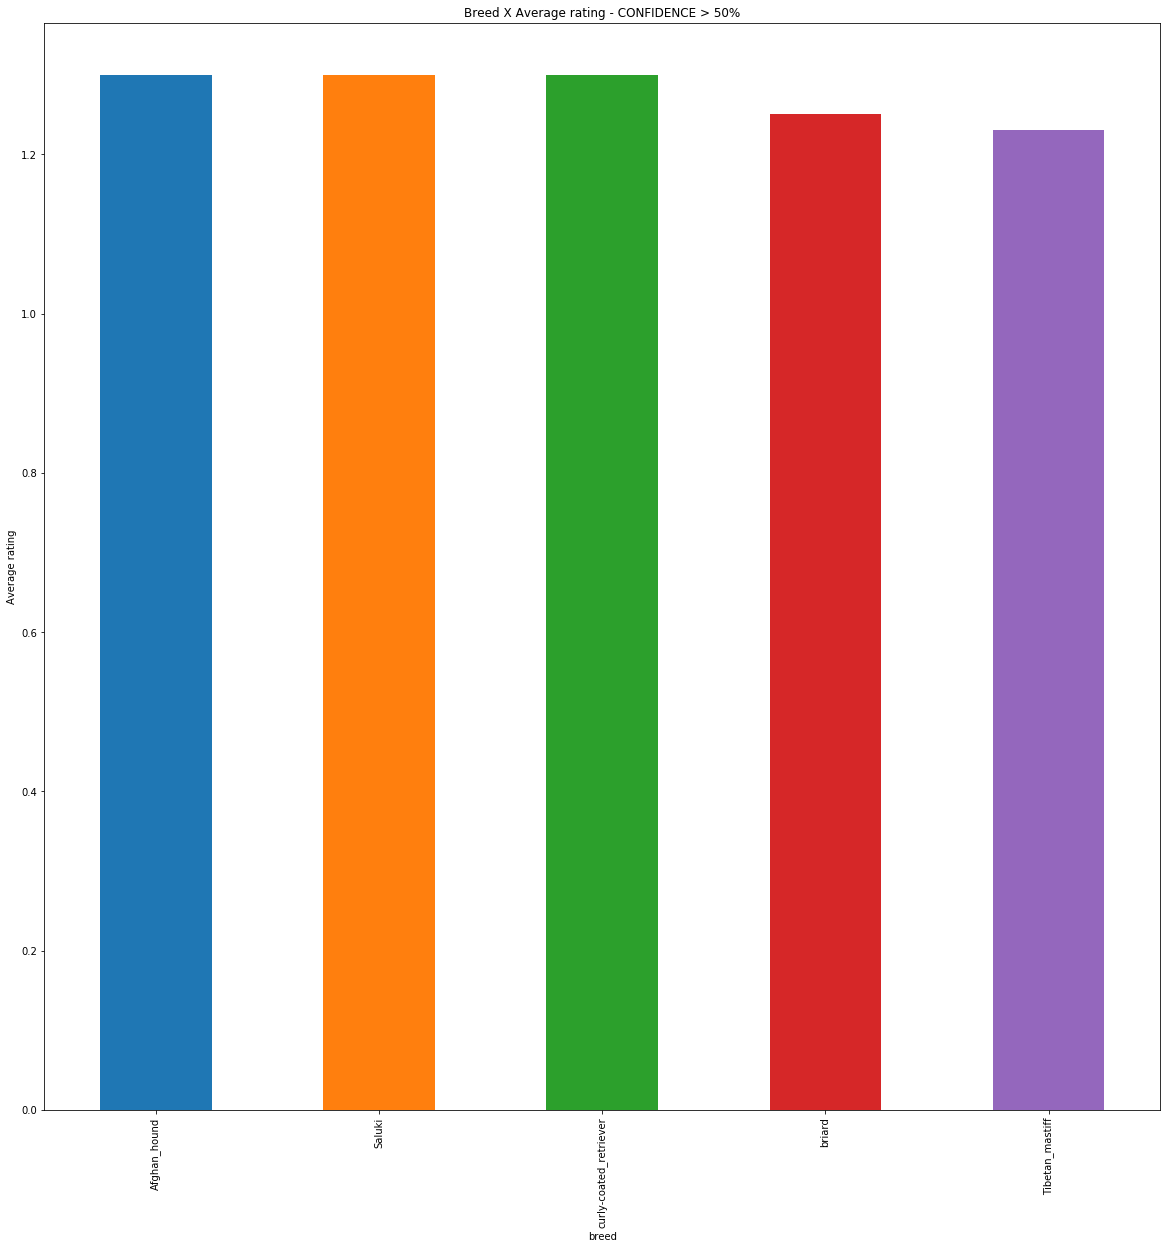

In [264]:
dfs_avg50.query('rat_avg >= 1.21').set_index(['breed']).rat_avg.sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.title("Breed X Average rating - CONFIDENCE > 50%")
plt.ylabel("Average rating");

In [265]:
dfs_avg50.query('rat_avg >= 1.20').set_index(['breed']).rat_avg.sort_values(ascending=False)

breed
Afghan_hound              1.30
Saluki                    1.30
curly-coated_retriever    1.30
briard                    1.25
Tibetan_mastiff           1.23
Norfolk_terrier           1.20
Irish_setter              1.20
Irish_water_spaniel       1.20
bluetick                  1.20
Border_terrier            1.20
toy_terrier               1.20
Name: rat_avg, dtype: float64

In [266]:
dfs_avg50.query('breed == "Bouvier_des_Flandres"')

,breed,rat_avg,fav_avg,ret_avg
20,Bouvier_des_Flandres,0.0,0.0,0.0


In [267]:
dfs_avg50.query('breed == "golden_retriever"')

,breed,rat_avg,fav_avg,ret_avg
12,golden_retriever,1.17,12538.29,3658.19


#### Conclusion

When we adopted the average to check the ratings and considering the confidence greater than fifty percent, we realized that "Saluki," "curly-coated_retriever," "Afghan_hound," "briard," and "Tibetan_mastiff" were the most well-evaluated breeds.

I preferred considering more than fifty percent of confidence to be more conservative. But "Border_terrier" was present in these two analyses in a different way than "Bouvier_des_Flandres."

The "golden_retriever" breed had average values not as high as the other breeds mentioned above.

### Insight 04 - Highest average values of favorites and retweets by dog breed

#### Evaluation

Favorites

In [268]:
dfs_avg50.query('fav_avg > 17000').set_index(['breed']).fav_avg.sort_values(ascending=False)

breed
Saluki                     30932.00
Irish_water_spaniel        25225.00
French_bulldog             18099.36
Afghan_hound               17305.00
Eskimo_dog                 17148.00
black-and-tan_coonhound    17012.00
Name: fav_avg, dtype: float64

In [269]:
dfs_avg.query('fav_avg > 10600').set_index(['breed']).fav_avg.sort_values(ascending=False)

breed
Saluki                     24060.00
Bedlington_terrier         21153.17
French_bulldog             18416.81
Bouvier_des_Flandres       18032.00
Afghan_hound               17326.67
black-and-tan_coonhound    17012.00
flat-coated_retriever      16791.62
Irish_water_spaniel        16400.00
Leonberg                   14934.33
English_springer           14138.30
standard_poodle            13912.82
Samoyed                    13902.52
Mexican_hairless           13590.57
cocker_spaniel             13580.40
Border_terrier             13578.00
whippet                    12911.45
Cardigan                   12840.19
Great_Pyrenees             12456.47
golden_retriever           12363.10
Tibetan_mastiff            12173.50
Weimaraner                 11982.75
Labrador_retriever         11801.17
Lakeland_terrier           11793.78
basset                     11762.06
Norwegian_elkhound         11293.55
Australian_terrier         11127.50
bloodhound                 11080.29
Pembroke              

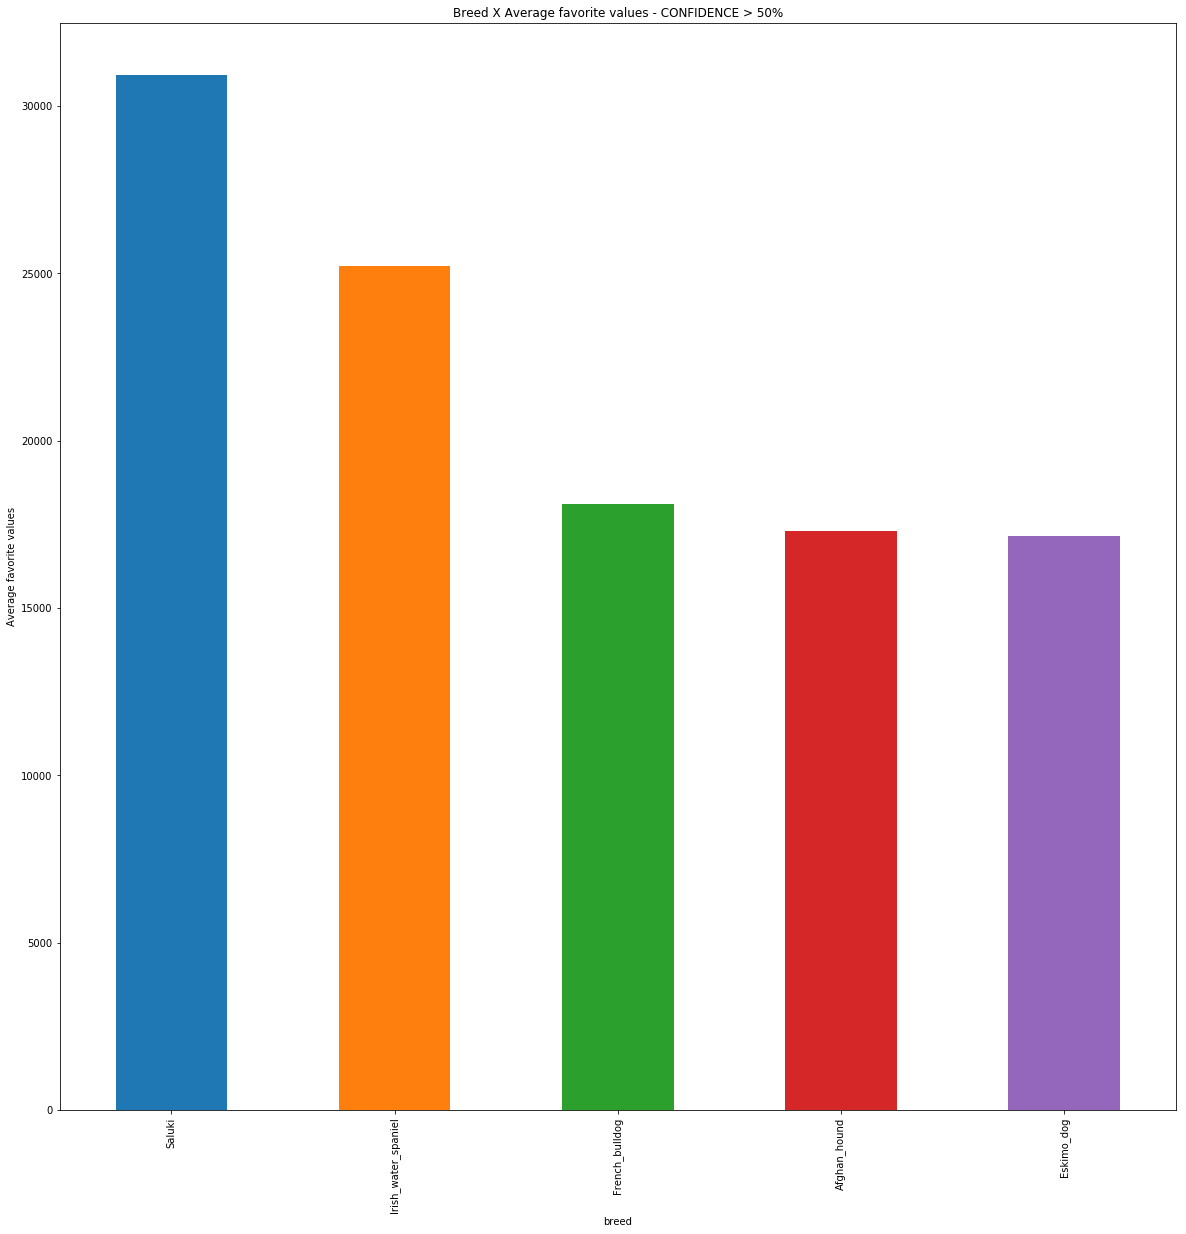

In [270]:
dfs_avg50.query('fav_avg > 17100').set_index(['breed']).fav_avg.sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.title("Breed X Average favorite values - CONFIDENCE > 50%")
plt.ylabel("Average favorite values");

Retweets

In [271]:
dfs_avg50.query('ret_avg >= 5330').sort_values('ret_avg', ascending=False)

,breed,rat_avg,fav_avg,ret_avg
52,Eskimo_dog,1.19,17148.00,7826.56
69,Saluki,1.30,30932.00,6508.00
86,Irish_water_spaniel,1.20,25225.00,6039.00
92,Irish_setter,1.20,16162.50,5645.50
26,Great_Pyrenees,1.14,14735.33,5337.00


In [272]:
dfs_avg50.query('ret_avg > 5330').set_index(['breed']).ret_avg.sort_values(ascending=False)

breed
Eskimo_dog             7826.56
Saluki                 6508.00
Irish_water_spaniel    6039.00
Irish_setter           5645.50
Great_Pyrenees         5337.00
Name: ret_avg, dtype: float64

In [273]:
dfs_avg.query('ret_avg > 4200').set_index(['breed']).ret_avg.sort_values(ascending=False)

breed
Bedlington_terrier       7510.17
Afghan_hound             5976.00
standard_poodle          5508.91
English_springer         5401.60
Saluki                   5133.75
French_bulldog           5039.68
cocker_spaniel           4858.10
Samoyed                  4843.95
whippet                  4840.27
Great_Pyrenees           4533.87
flat-coated_retriever    4520.25
Irish_water_spaniel      4500.67
Bouvier_des_Flandres     4479.00
Mexican_hairless         4254.86
Eskimo_dog               4235.59
Name: ret_avg, dtype: float64

In [274]:
dfs_avg.query('breed == "Irish_setter"')

,breed,rat_avg,fav_avg,ret_avg
92,Irish_setter,1.17,10581.75,3374.0


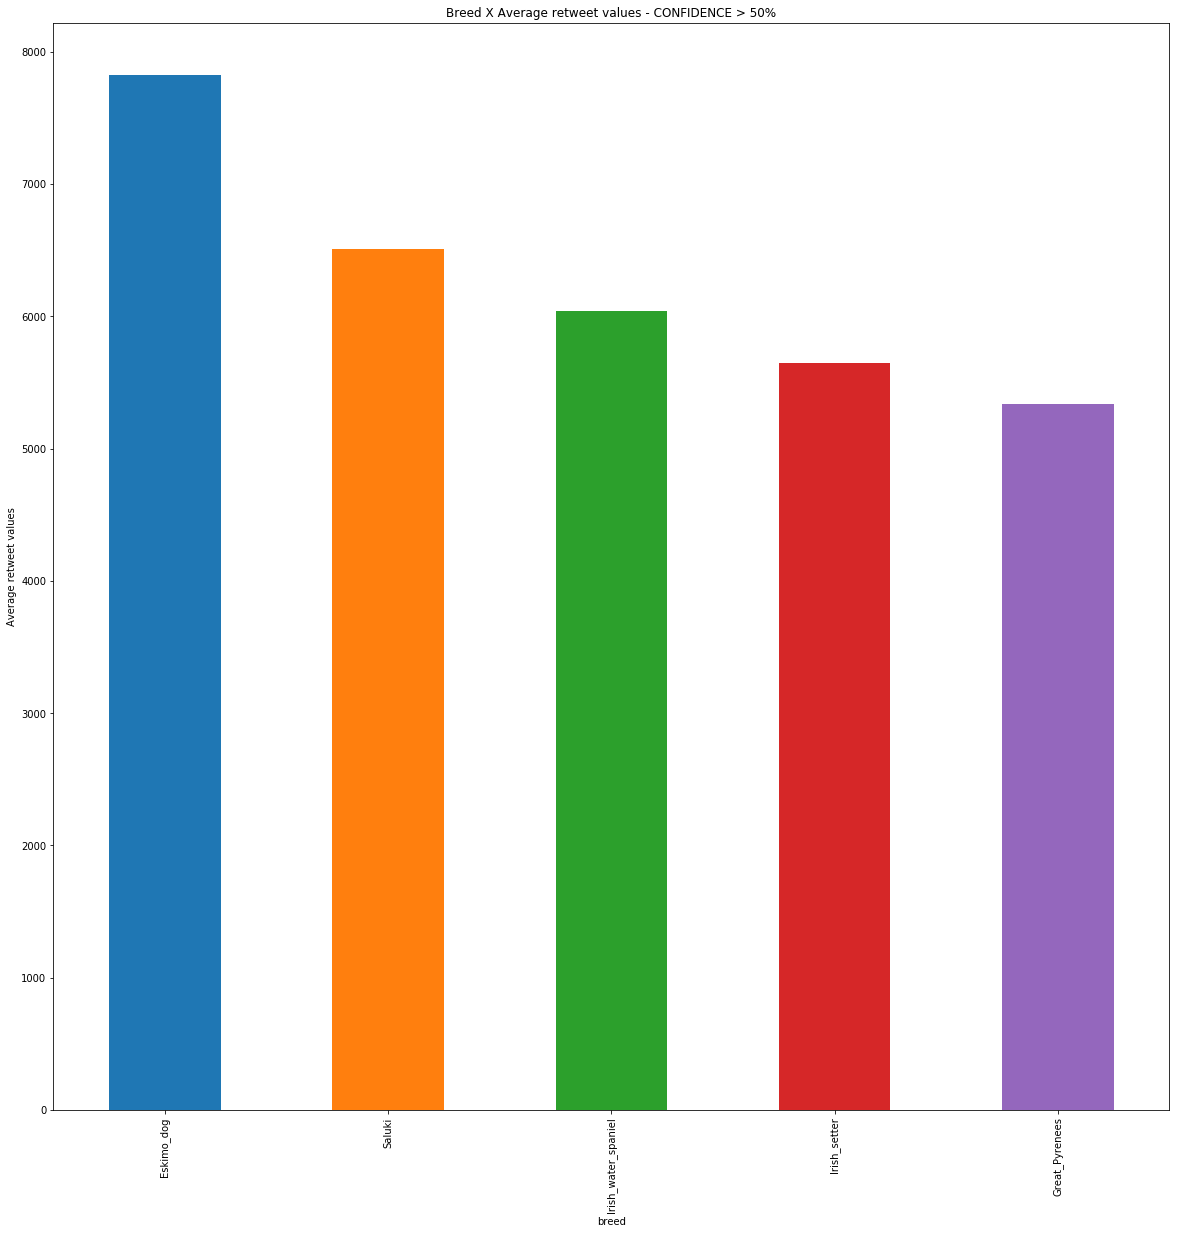

In [275]:
dfs_avg50.query('ret_avg > 5330').set_index(['breed']).ret_avg.sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.title("Breed X Average retweet values - CONFIDENCE > 50%")
plt.ylabel("Average retweet values");

#### Conclusion

There were two ways to analyze the favorites and retweets. The first way is to check values considering the high values, as we saw in "Insight 02".

In this evaluation, we considered de average values of each breed. For example, in the query below, we have the average favorite values of the population of "golden_retriever" with a confidence greater than fifty percent.

In [276]:
dfs_avg50.query('breed == "golden_retriever"')

,breed,rat_avg,fav_avg,ret_avg
12,golden_retriever,1.17,12538.29,3658.19


Considering the average value of each breed, we could realize that the "Saluki," "Irish_water_spaniel," "French_bulldog," "Afghan_hound," and "Eskimo_dog" were the most critical breeds, considering the favorites received and one confidence interval greater than fifty percent.
The "black-and-tan_coonhound" breed also had a more significant number of likes.

The number of average retweets by breed was more remarkable for the species "Eskimo_dog," "Saluki," "Irish_water_spaniel," "Irish_setter," and "Great_Pyrenees."

### Insights:

#### 1. Amount of tweets by breed

The "golden_retriever" group received the majority of tweets. We also had many elements of "Pembroke" as the second group and "Labrador_retriever" as the third group, considering the confidence level greater than 50%. The next group with more tweets were "Chihuahua" and "pug."

I removed the retweets and images that were not natural dogs in this classification. I mainly considered the photos with a confidence interval of breeds superior to 50%.

Reference: Insight 01 in Analyzing and Visualizing Data.

#### 2.Average rating numerator by breed

When we adopted the average to check the ratings and considering the confidence greater than fifty percent, we realized that "curly-coated_retriever," "Afghan_hound," "Saluki," "briard," and "Tibetan_mastiff" were the most well-evaluated breeds.

I preferred considering more than fifty percent of confidence to be more conservative. But "Border_terrier" was present in these two analyses in a different way than "Bouvier_des_Flandres."

The "golden_retriever" breed had average values not as high as the other breeds mentioned above.

Reference: Insight 03 in Analyzing and Visualizing Data.

#### 3. Highest average values of favorites and retweets by dog breed

Considering the average value of each breed, we could realize that the "Saluki," "Irish_water_spaniel," "French_bulldog," "Afghan_hound," and "Eskimo_dog" were the most critical breeds, considering the favorites received and one confidence interval greater than fifty percent.
The "black-and-tan_coonhound" breed also had a more significant number of likes.

The number of average retweets by breed was more remarkable for the species "Eskimo_dog," "Saluki," "Irish_water_spaniel," "Irish_setter," and "Great_Pyrenees."

Reference: Insight 04 in Analyzing and Visualizing Data.

### Visualization

1. Amount of tweets by breed

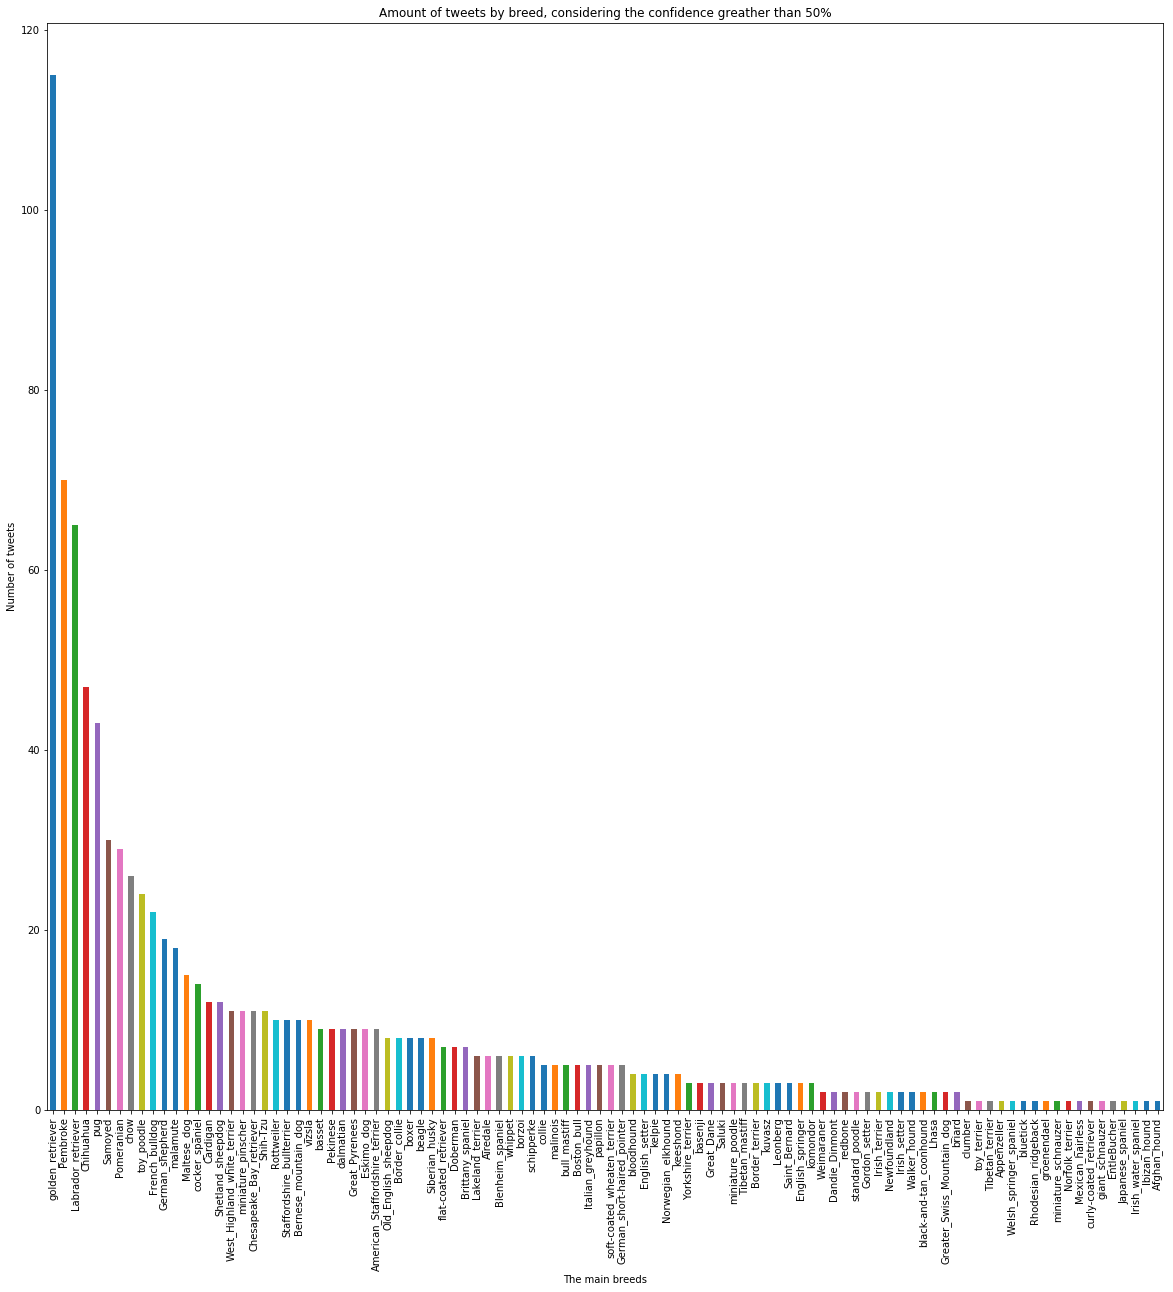

In [277]:
dfs.query('confidence > 50').groupby( [ "breed"] ).size().sort_values(ascending=False).plot(kind='bar',figsize=(20,20))
plt.title("Amount of tweets by breed, considering the confidence greather than 50%")
plt.xlabel("The main breeds")
plt.ylabel("Number of tweets");

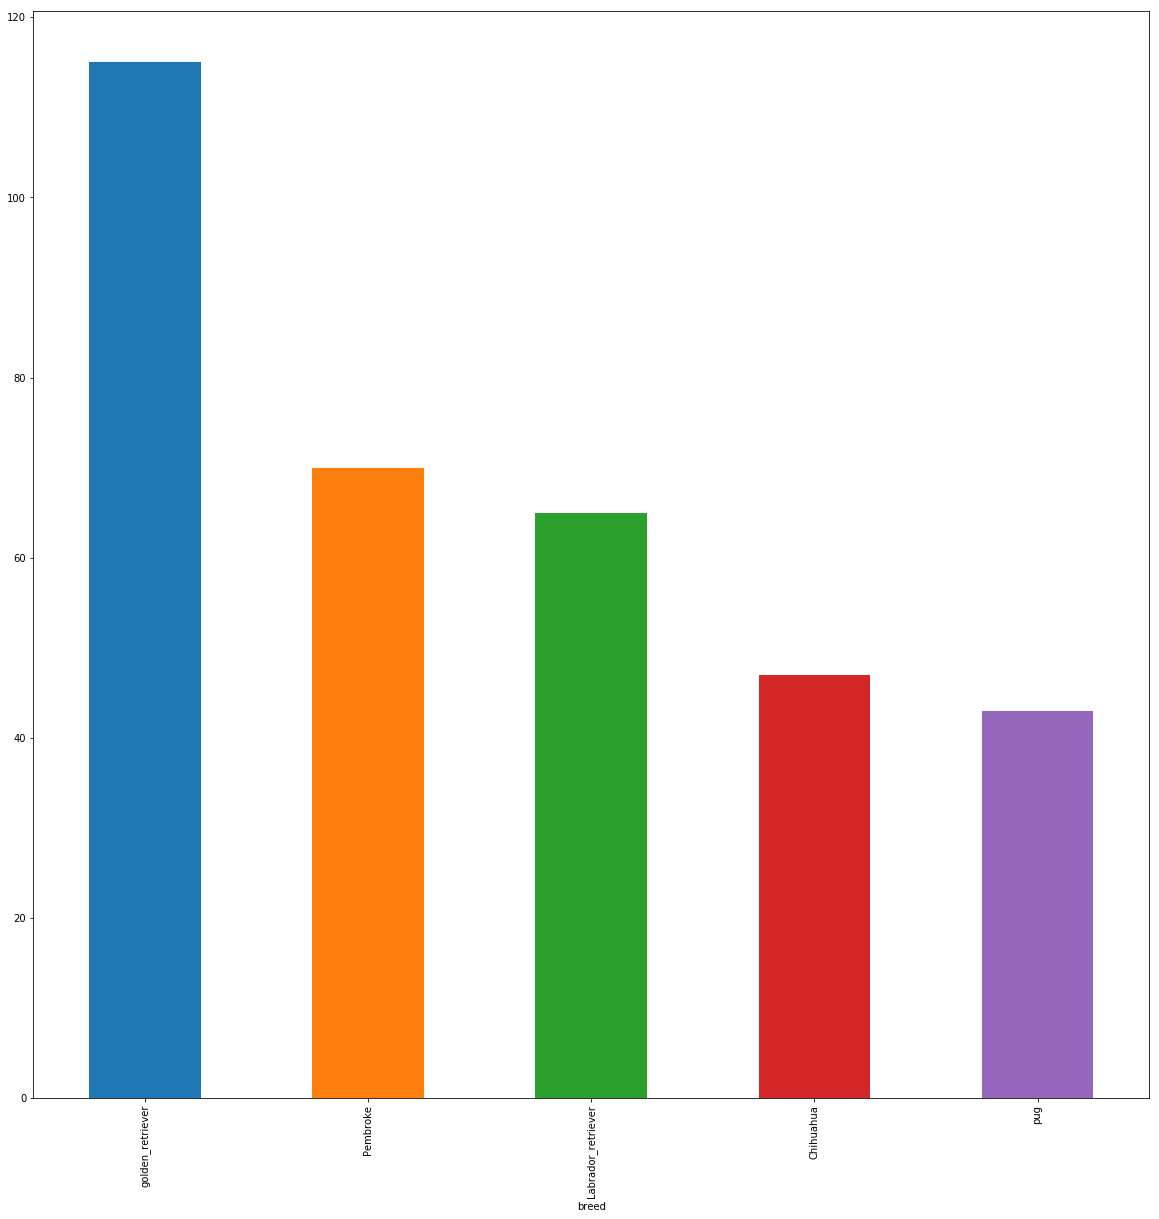

In [278]:
dfs.query('confidence > 50') \
.query('breed == "golden_retriever" or breed == "Pembroke" or breed == "Labrador_retriever" or breed == "Chihuahua" or breed == "pug"') \
.groupby('breed').size().sort_values(ascending=False) \
.plot(kind='bar',figsize=(20,20));

2.Average rating by breed

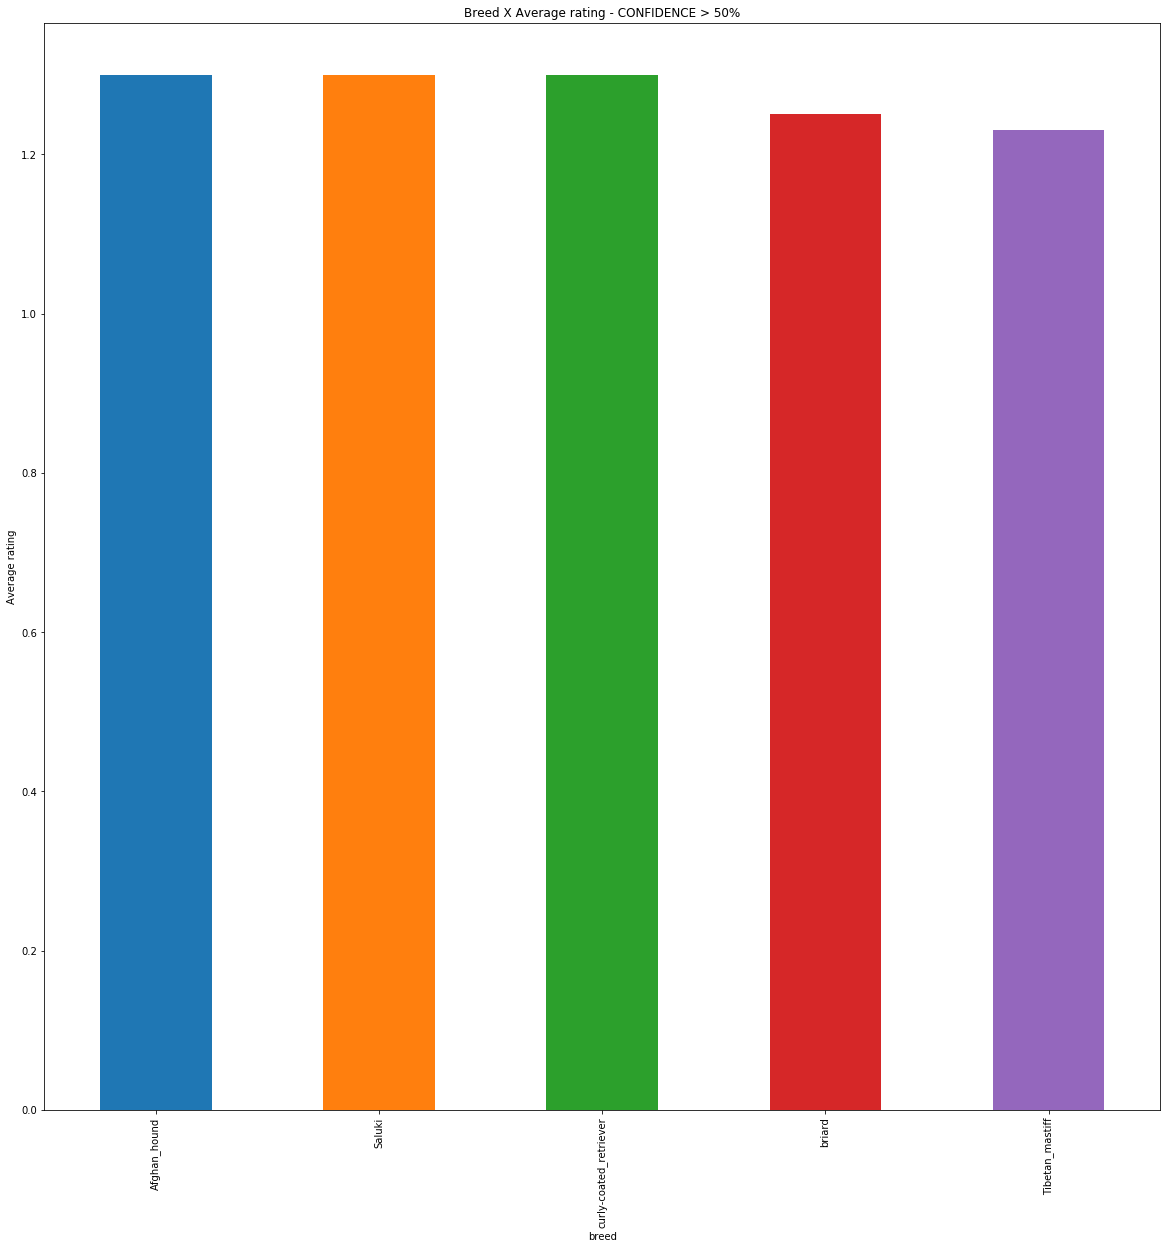

In [279]:
dfs_avg50.query('rat_avg >= 1.21').set_index(['breed']).rat_avg.sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.title("Breed X Average rating - CONFIDENCE > 50%")
plt.ylabel("Average rating");

3. Highest average values of favorites and retweets by dog breed

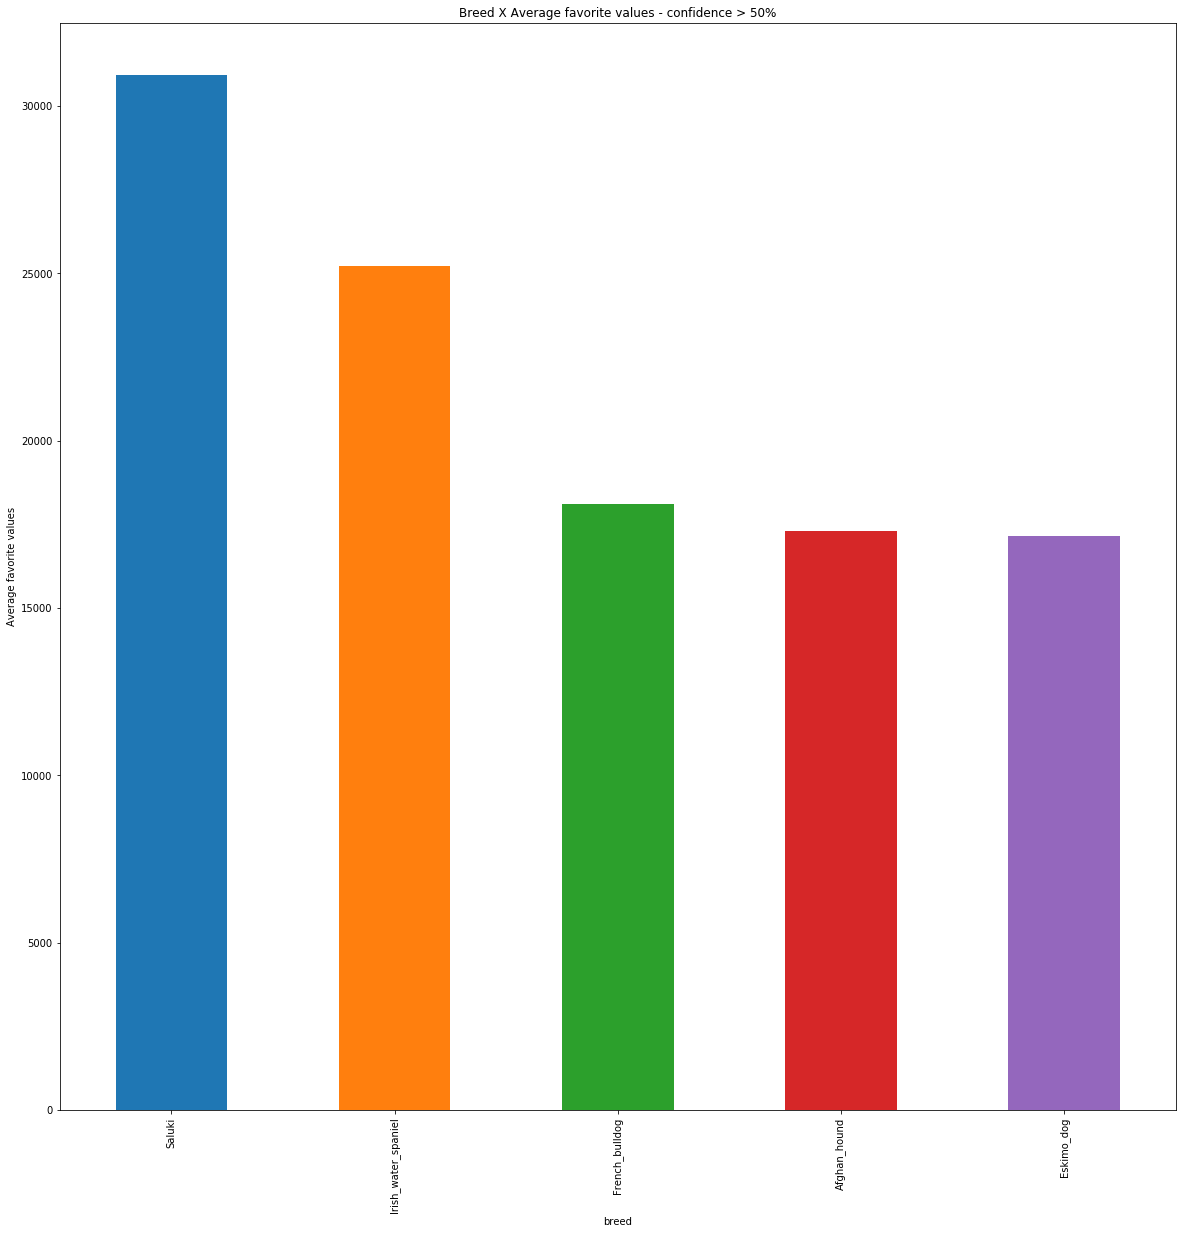

In [280]:
dfs_avg50.query('fav_avg > 17100').set_index(['breed']).fav_avg.sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.title("Breed X Average favorite values - confidence > 50%")
plt.ylabel("Average favorite values");

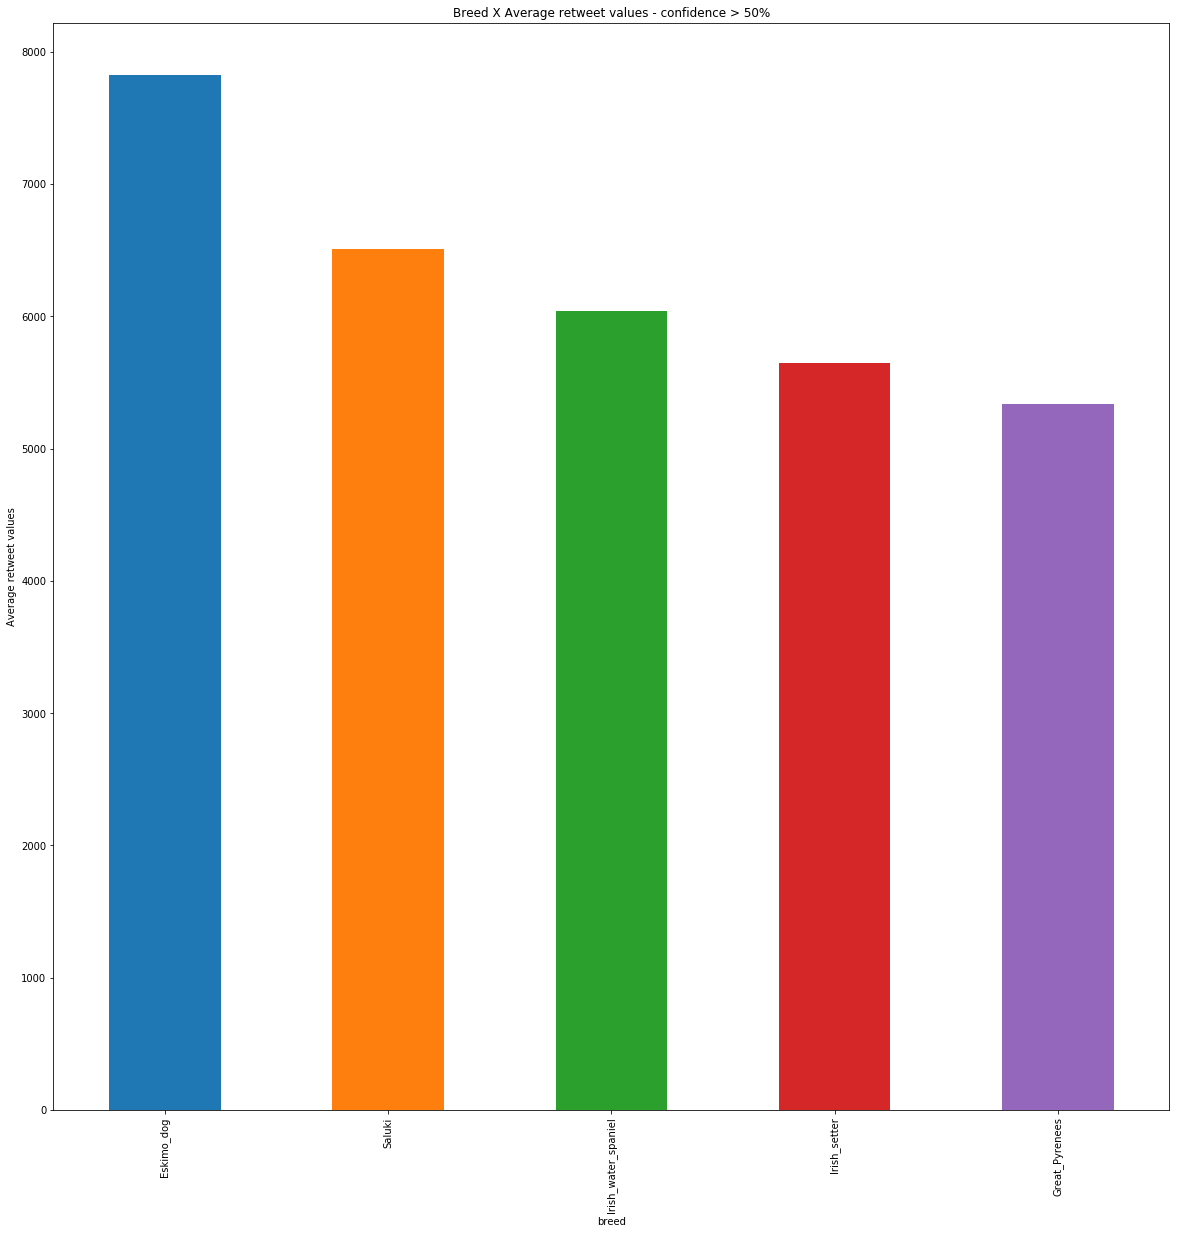

In [281]:
dfs_avg50.query('ret_avg > 5330').set_index(['breed']).ret_avg.sort_values(ascending=False).plot(kind='bar', figsize=(20,20))
plt.title("Breed X Average retweet values - confidence > 50%")
plt.ylabel("Average retweet values");

# Searching for similar works
<br>Search01: [Project: Wrangle and Analyze Data - FAQ](https://sites.google.com/udacity.com/dataanalyst-project4/home)
<br><br>Search02: [Harshit Kumar - kHarshit - GitHub - kHarshit/udacity-nanodegree-projects](https://github.com/kHarshit/udacity-nanodegree-projects/blob/master/DAND_data_analyst_nanodegree/p4_wrangle_and_analyze_data/wrangle_act.ipynb)
<br><br>Search03: [Jem Chang - jemc36 - GitHub - Project: Twitter API: tweet archive of Twitter user @dog_rates data](https://github.com/jemc36/Udacity-DAND-DataWrangling-TwitterAPI-WeRateDogs/blob/master/wrangle_act.ipynb)
<br><br>Search04: [Brice Pulley - Kaggle - Project: Data Wrangling](https://www.kaggle.com/code/pulleyba/project-data-wrangling/notebook)
<br><br>Search05: [Krzysztof Satola - GitHub - WeRateDogs Twitter Data Wrangling](https://ksatola.github.io/projects/wrangle_act.html)  ,  [Krzysztof Satola - GitHub](https://github.com/ksatola/WeRateDogs-Twitter-Data-Wrangling)
<br><br>Search06: [Nadeem Tabbaa - Kaggle - WeRateDogs Tweet Data Wrangling](https://www.kaggle.com/code/msytnadeem/weratedogs-tweet-data-wrangling)
<br><br>Search07: [Anderson Uyekita - GitHub - AndersonUyekita/ND111_data_science_foundations_02](https://github.com/AndersonUyekita/ND111_data_science_foundations_02/blob/master/03-Chapter03/00-Project_02/wrangle_act.ipynb)<br><br>Search03: [John Chen - Towardsdatascience - Data Analysis Project — WeRateDogs](https://towardsdatascience.com/data-analysis-project-weratedogs-16aad3f6c8c2)
<br><br>Search08: [Matthew Unrue - The Statistics of WeRateDogs](https://www.matthewunrue.com/Projects/Udacity/WeRateDogs/Project.html)
<br><br>Search09: [TheSeaGiraffe - GitHub - Wrangle WeRateDogs Data](https://github.com/siderealsasquatch/udacity-we-rate-dogs-project/blob/master/wrangle_act.ipynb)
<br><br>Search10: [Evan Chen - GitHub - WeRateDogs Twitter Data Wrangling & Analysis](https://github.com/evanchen13/weratedogs/blob/master/wrangle_act.ipynb)
<br><br>Search11: [Sakina Fakhruddin - Medium - ‘We Rate Dogs’: Twitter Data Analysis](https://medium.com/ub-women-data-scholars/we-rate-dogs-twitter-data-analysis-672e1a8903b4)
<br><br>Search12: [Ricardo Roggia - Kaggle - No-show medical appointments](https://www.kaggle.com/code/ricardoroggia/no-show-medical-appointments)